# RNN Model Approach for Battery Capacity Degradation Model [CALCE]

Reference:

- `S. Ansari, A. Ayob, M. S. Hossain Lipu, A. Hussain, and M. H. M. Saad, “Data-driven
remaining useful life prediction for lithium-ion batteries using multi-charging profile frame-
work: A recurrent neural network approach”, Sustainability, vol. 13, no. 23, 2021, issn: 2071-1050. doi: 10 . 3390 / su132313333. [Online]. Available: https : / / www . mdpi . com / 2071 -
1050/13/23/13333`

## Import google drive

In [ ]:
# import google drive
from google.colab import drive

# mount drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


## Import Python Modules

In [ ]:
# Import modules
import numpy as np
import random
import math
import os
import sys
import copy
import shutil
import zipfile
import scipy.io
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
%matplotlib inline

from torch import optim
from math import sqrt
from datetime import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from pathlib import Path

## Set-up device-agnostic code

In [ ]:
# Setting up device-agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Moving files to Working Director

In [ ]:
# zipfiles complete path
b1 = '/content/drive/MyDrive/CS2/Cycled at constant current of 1C/CS2_35.zip'
b2 = '/content/drive/MyDrive/CS2/Cycled at constant current of 1C/CS2_36.zip'
b3 = '/content/drive/MyDrive/CS2/Cycled at constant current of 1C/CS2_37.zip'
b4 = '/content/drive/MyDrive/CS2/Cycled at constant current of 1C/CS2_38.zip'

battery_list = [b1, b2, b3, b4]
Battery_names = ['CS2_35', 'CS2_36', 'CS2_37', 'CS2_38']
# Setup path to date folder
data_path = Path("data/")
calce_datapath = data_path / "calce"

# If the dataset folder doesn't exist download it and prepare it...
if calce_datapath.is_dir():
    print(f"{calce_datapath} directory exists.")
else:
    print(f"Did not find {calce_datapath} directory, creating one...")
    calce_datapath.mkdir(parents=True, exist_ok=True)

    # move zip file to data_path
    print("Moving zip files to calce-battery directory...")
    for bat in battery_list:
        filename = bat.split("/")[-1].split(".")[0]
        filepath = bat.split("/")[-1]
        print(f"Moving {filename}.zip ...")
        shutil.copy(bat, data_path)
        with zipfile.ZipFile(data_path / filepath, "r") as zip_ref:
            print(f"Unzipping {filepath} ...")
            zip_ref.extractall(calce_datapath)

Did not find data/calce directory, creating one...
Moving zip files to calce-battery directory...
Moving CS2_35.zip ...
Unzipping CS2_35.zip ...
Moving CS2_36.zip ...
Unzipping CS2_36.zip ...
Moving CS2_37.zip ...
Unzipping CS2_37.zip ...
Moving CS2_38.zip ...
Unzipping CS2_38.zip ...


### Sorting filenames (faster way)

In [ ]:
import pandas as pd
import glob

Battery_list = ['CS2_35', 'CS2_36', 'CS2_37', 'CS2_38']
dir_path = '/content/data/calce/'

path = glob.glob(dir_path + Battery_list[0] + '/*.xlsx')
path

['/content/data/calce/CS2_35/CS2_35_1_10_11.xlsx',
 '/content/data/calce/CS2_35/CS2_35_9_30_10.xlsx',
 '/content/data/calce/CS2_35/CS2_35_1_24_11.xlsx',
 '/content/data/calce/CS2_35/CS2_35_8_30_10.xlsx',
 '/content/data/calce/CS2_35/CS2_35_9_21_10.xlsx',
 '/content/data/calce/CS2_35/CS2_35_11_01_10.xlsx',
 '/content/data/calce/CS2_35/CS2_35_11_23_10.xlsx',
 '/content/data/calce/CS2_35/CS2_35_8_18_10.xlsx',
 '/content/data/calce/CS2_35/CS2_35_9_7_10.xlsx',
 '/content/data/calce/CS2_35/CS2_35_11_24_10.xlsx',
 '/content/data/calce/CS2_35/CS2_35_8_19_10.xlsx',
 '/content/data/calce/CS2_35/CS2_35_12_06_10.xlsx',
 '/content/data/calce/CS2_35/CS2_35_12_20_10.xlsx',
 '/content/data/calce/CS2_35/CS2_35_1_18_11.xlsx',
 '/content/data/calce/CS2_35/CS2_35_12_23_10.xlsx',
 '/content/data/calce/CS2_35/CS2_35_2_4_11.xlsx',
 '/content/data/calce/CS2_35/CS2_35_2_10_11.xlsx',
 '/content/data/calce/CS2_35/CS2_35_11_08_10.xlsx',
 '/content/data/calce/CS2_35/CS2_35_9_8_10.xlsx',
 '/content/data/calce/CS2_3

In [ ]:
dates = []
for p in path:    
    file_path = p.split("/")[-1].split(".")[0].split("_")[-3:]
    date_str = str(file_path[0] + "/" + file_path[1] + "/" + file_path[2]) 
    date = datetime.strptime(date_str, '%m/%d/%y')
    dates.append(date)

dates

[datetime.datetime(2011, 1, 10, 0, 0),
 datetime.datetime(2010, 9, 30, 0, 0),
 datetime.datetime(2011, 1, 24, 0, 0),
 datetime.datetime(2010, 8, 30, 0, 0),
 datetime.datetime(2010, 9, 21, 0, 0),
 datetime.datetime(2010, 11, 1, 0, 0),
 datetime.datetime(2010, 11, 23, 0, 0),
 datetime.datetime(2010, 8, 18, 0, 0),
 datetime.datetime(2010, 9, 7, 0, 0),
 datetime.datetime(2010, 11, 24, 0, 0),
 datetime.datetime(2010, 8, 19, 0, 0),
 datetime.datetime(2010, 12, 6, 0, 0),
 datetime.datetime(2010, 12, 20, 0, 0),
 datetime.datetime(2011, 1, 18, 0, 0),
 datetime.datetime(2010, 12, 23, 0, 0),
 datetime.datetime(2011, 2, 4, 0, 0),
 datetime.datetime(2011, 2, 10, 0, 0),
 datetime.datetime(2010, 11, 8, 0, 0),
 datetime.datetime(2010, 9, 8, 0, 0),
 datetime.datetime(2010, 10, 15, 0, 0),
 datetime.datetime(2010, 10, 29, 0, 0),
 datetime.datetime(2011, 1, 28, 0, 0),
 datetime.datetime(2010, 12, 13, 0, 0),
 datetime.datetime(2010, 8, 17, 0, 0),
 datetime.datetime(2010, 10, 22, 0, 0)]

In [ ]:
idx = np.argsort(dates)
idx

array([23,  7, 10,  3,  8, 18,  4,  1, 19, 24, 20,  5, 17,  6,  9, 11, 22,
       12, 14,  0, 13,  2, 21, 15, 16])

In [ ]:
path_sorted = np.array(path)[idx]
path_sorted

array(['/content/data/calce/CS2_35/CS2_35_8_17_10.xlsx',
       '/content/data/calce/CS2_35/CS2_35_8_18_10.xlsx',
       '/content/data/calce/CS2_35/CS2_35_8_19_10.xlsx',
       '/content/data/calce/CS2_35/CS2_35_8_30_10.xlsx',
       '/content/data/calce/CS2_35/CS2_35_9_7_10.xlsx',
       '/content/data/calce/CS2_35/CS2_35_9_8_10.xlsx',
       '/content/data/calce/CS2_35/CS2_35_9_21_10.xlsx',
       '/content/data/calce/CS2_35/CS2_35_9_30_10.xlsx',
       '/content/data/calce/CS2_35/CS2_35_10_15_10.xlsx',
       '/content/data/calce/CS2_35/CS2_35_10_22_10.xlsx',
       '/content/data/calce/CS2_35/CS2_35_10_29_10.xlsx',
       '/content/data/calce/CS2_35/CS2_35_11_01_10.xlsx',
       '/content/data/calce/CS2_35/CS2_35_11_08_10.xlsx',
       '/content/data/calce/CS2_35/CS2_35_11_23_10.xlsx',
       '/content/data/calce/CS2_35/CS2_35_11_24_10.xlsx',
       '/content/data/calce/CS2_35/CS2_35_12_06_10.xlsx',
       '/content/data/calce/CS2_35/CS2_35_12_13_10.xlsx',
       '/content/data/ca

In [ ]:
import pandas as pd
import glob

Battery_list = ['CS2_35', 'CS2_36', 'CS2_37', 'CS2_38']
dir_path = '/content/data/calce/'

path = glob.glob(dir_path + Battery_list[0] + '/*.xlsx')
dates = []
for p in path:    
    file_path = p.split("/")[-1].split(".")[0].split("_")[-3:]
    date_str = str(file_path[0] + "/" + file_path[1] + "/" + file_path[2]) 
    date = datetime.strptime(date_str, '%m/%d/%y')
    dates.append(date)
idx = np.argsort(dates)
path_sorted = np.array(path)[idx]
path_sorted

array(['/content/data/calce/CS2_35/CS2_35_8_17_10.xlsx',
       '/content/data/calce/CS2_35/CS2_35_8_18_10.xlsx',
       '/content/data/calce/CS2_35/CS2_35_8_19_10.xlsx',
       '/content/data/calce/CS2_35/CS2_35_8_30_10.xlsx',
       '/content/data/calce/CS2_35/CS2_35_9_7_10.xlsx',
       '/content/data/calce/CS2_35/CS2_35_9_8_10.xlsx',
       '/content/data/calce/CS2_35/CS2_35_9_21_10.xlsx',
       '/content/data/calce/CS2_35/CS2_35_9_30_10.xlsx',
       '/content/data/calce/CS2_35/CS2_35_10_15_10.xlsx',
       '/content/data/calce/CS2_35/CS2_35_10_22_10.xlsx',
       '/content/data/calce/CS2_35/CS2_35_10_29_10.xlsx',
       '/content/data/calce/CS2_35/CS2_35_11_01_10.xlsx',
       '/content/data/calce/CS2_35/CS2_35_11_08_10.xlsx',
       '/content/data/calce/CS2_35/CS2_35_11_23_10.xlsx',
       '/content/data/calce/CS2_35/CS2_35_11_24_10.xlsx',
       '/content/data/calce/CS2_35/CS2_35_12_06_10.xlsx',
       '/content/data/calce/CS2_35/CS2_35_12_13_10.xlsx',
       '/content/data/ca

In [ ]:
from timeit import default_timer as timer
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from collections import Counter
import linecache
import os
import tracemalloc

# Compute for accuracy
def accuracy(y_test, y_pred):
  error = np.abs(y_pred-y_test)/y_test
  acc = np.ones_like(error) - error
  acc = np.sum(acc)/len(y_pred)
  return float(acc)

# Print Inference Time
def print_inference_time(start: float,
                         end: float,
                         device: torch.device = None):
    
  """
  Prints difference between start and end time
  """

  total_time = end - start
  print(f"Inference time on {device}: {total_time:.3f} seconds")

  return total_time

# Print Memory Usage

def memory_stats(snapshot, key_type='lineno'):
  snapshot = snapshot.filter_traces((
      tracemalloc.Filter(False, "<frozen importlib._bootstrap>"),
      tracemalloc.Filter(False, "<unknown>"),
  ))
  usage_stat = snapshot.statistics(key_type)

  total = sum(stat.size for stat in usage_stat)

  print("Allocated memory: %.1f KiB" % (total / 1024))

In [ ]:
# Setting up device-agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## Convert `.csv` files to pandas dataframe

In [ ]:
# drop outliers to get indexes
def drop_outlier(array, count, bins):
    index = []
    out_range = np.arange(1, count, bins)
    for i in out_range[:-1]:
        array_lim = array[i : i + bins]
        sigma = np.std(array_lim)
        mean = np.mean(array_lim)
        th_max, th_min = mean + sigma*2, mean - sigma*2
        idx = np.where((array_lim < th_max) & (array_lim > th_min))
        idx = idx[0] + i
        index.extend(list(idx))
    return np.array(index)

In [ ]:
import pandas as pd
import glob

start_time = timer()
Battery_list = ['CS2_35', 'CS2_36', 'CS2_37', 'CS2_38']

dir_path = '/content/data/calce/'
Battery = {}
Charge_Profiles = {}
for name in Battery_list:
    print('Load Dataset ' + name + ' ...')
    path = glob.glob(dir_path + name + '/*.xlsx')
    dates = []
    for p in path:
        df = pd.read_excel(p, sheet_name=1)
        print('Load ' + str(p) + ' ...')
        dates.append(df['Date_Time'][0])
    idx = np.argsort(dates)
    path_sorted = np.array(path)[idx]
    
    count = 0
    discharge_capacities = []
    #health_indicator = []
    internal_resistance = []
    #CCCT = []
    #CVCT = []
    #data = []
    d1 = {}
    volt = []
    amp = []
    print('=========================sorted=========================')
    for p in path_sorted:
        df = pd.read_excel(p,sheet_name=1)
        print('Load ' + str(p) + ' ...')
        cycles = list(set(df['Cycle_Index']))
        for c in cycles:
            df_lim = df[df['Cycle_Index'] == c]
            #Charging
            df_c = df_lim[(df_lim['Step_Index'] == 2)|(df_lim['Step_Index'] == 4)]
            c_v = np.array(df_c['Voltage(V)'])
            c_c = np.array(df_c['Current(A)'])
            c_t = df_c['Test_Time(s)']

            volt.append(c_v)
            amp.append(c_c)
            
            #CC or CV
            '''
            df_cc = df_lim[df_lim['Step_Index'] == 2]
            df_cv = df_lim[df_lim['Step_Index'] == 4]
            CCCT.append(np.max(df_cc['Test_Time(s)'])-np.min(df_cc['Test_Time(s)']))
            CVCT.append(np.max(df_cv['Test_Time(s)'])-np.min(df_cv['Test_Time(s)']))
            '''
            #Discharging
            df_d = df_lim[df_lim['Step_Index'] == 7]
            d_v = df_d['Voltage(V)']
            d_c = df_d['Current(A)']
            d_t = df_d['Test_Time(s)']
            d_im = df_d['Internal_Resistance(Ohm)']

            if(len(list(d_c)) != 0):
                time_diff = np.diff(list(d_t))
                d_c = np.array(list(d_c))[1:]
                discharge_capacity = time_diff*d_c/3600 # Q = A*h
                discharge_capacity = [np.sum(discharge_capacity[:n]) for n in range(discharge_capacity.shape[0])]
                discharge_capacities.append(-1*discharge_capacity[-1])
                
                '''
                dec = np.abs(np.array(d_v) - 3.8)[1:]
                start = np.array(discharge_capacity)[np.argmin(dec)]
                dec = np.abs(np.array(d_v) - 3.4)[1:]
                end = np.array(discharge_capacity)[np.argmin(dec)]
                health_indicator.append(-1 * (end - start))
                '''
                
                internal_resistance.append(np.mean(np.array(d_im)))
                count += 1
            
    
    #data.append(d1)
    discharge_capacities = np.array(discharge_capacities)
    internal_resistance = np.array(internal_resistance)
    '''
    health_indicator = np.array(health_indicator)
    CCCT = np.array(CCCT)
    CVCT = np.array(CVCT)
    '''

    idx = drop_outlier(discharge_capacities, count, 40)
    df_result = pd.DataFrame({'cycle':np.linspace(1,idx.shape[0],idx.shape[0]),
                              'capacity':discharge_capacities[idx],
                              #'SoH':health_indicator[idx],
                              'resistance':internal_resistance[idx]})
                              #'CCCT':CCCT[idx],
                              #'CVCT':CVCT[idx]})
    volt = [volt[idx[i]] for i in range(len(idx))]
    amp = [amp[idx[i]] for i in range(len(idx))]
    d1['Voltage'], d1['Current'] = volt, amp
                              
    Battery[name] = df_result
    Charge_Profiles[name] = d1
end_time = timer()
print_inference_time(start_time, end_time, device)

Load Dataset CS2_35 ...
Load /content/data/calce/CS2_35/CS2_35_1_10_11.xlsx ...
Load /content/data/calce/CS2_35/CS2_35_9_30_10.xlsx ...
Load /content/data/calce/CS2_35/CS2_35_1_24_11.xlsx ...
Load /content/data/calce/CS2_35/CS2_35_8_30_10.xlsx ...
Load /content/data/calce/CS2_35/CS2_35_9_21_10.xlsx ...
Load /content/data/calce/CS2_35/CS2_35_11_01_10.xlsx ...
Load /content/data/calce/CS2_35/CS2_35_11_23_10.xlsx ...
Load /content/data/calce/CS2_35/CS2_35_8_18_10.xlsx ...
Load /content/data/calce/CS2_35/CS2_35_9_7_10.xlsx ...
Load /content/data/calce/CS2_35/CS2_35_11_24_10.xlsx ...
Load /content/data/calce/CS2_35/CS2_35_8_19_10.xlsx ...
Load /content/data/calce/CS2_35/CS2_35_12_06_10.xlsx ...
Load /content/data/calce/CS2_35/CS2_35_12_20_10.xlsx ...
Load /content/data/calce/CS2_35/CS2_35_1_18_11.xlsx ...
Load /content/data/calce/CS2_35/CS2_35_12_23_10.xlsx ...
Load /content/data/calce/CS2_35/CS2_35_2_4_11.xlsx ...
Load /content/data/calce/CS2_35/CS2_35_2_10_11.xlsx ...
Load /content/data/c

606.767506354

### modified code to load the files faster (1.5x)

In [ ]:
import pandas as pd
import glob

start_time = timer()
Battery_list = ['CS2_35', 'CS2_36', 'CS2_37', 'CS2_38']

dir_path = '/content/data/calce/'
Battery = {}
Charge_Profiles = {}
for name in Battery_list:
    print('Load Dataset ' + name + ' ...')
    path = glob.glob(dir_path + name + '/*.xlsx')
    dates = []
    for p in path:    
        file_path = p.split("/")[-1].split(".")[0].split("_")[-3:]
        date_str = str(file_path[0] + "/" + file_path[1] + "/" + file_path[2]) 
        date = datetime.strptime(date_str, '%m/%d/%y')
        dates.append(date)
    idx = np.argsort(dates)
    path_sorted = np.array(path)[idx]
    
    count = 0
    discharge_capacities = []
    #health_indicator = []
    internal_resistance = []
    #CCCT = []
    #CVCT = []
    #data = []
    d1 = {}
    volt = []
    amp = []
    print('=========================sorted=========================')
    for p in path_sorted:
        df = pd.read_excel(p,sheet_name=1)
        print('Load ' + str(p) + ' ...')
        cycles = list(set(df['Cycle_Index']))
        for c in cycles:
            df_lim = df[df['Cycle_Index'] == c]
            #Charging
            df_c = df_lim[(df_lim['Step_Index'] == 2)|(df_lim['Step_Index'] == 4)]
            c_v = np.array(df_c['Voltage(V)'])
            c_c = np.array(df_c['Current(A)'])
            c_t = df_c['Test_Time(s)']

            volt.append(c_v)
            amp.append(c_c)
            
            #CC or CV
            '''
            df_cc = df_lim[df_lim['Step_Index'] == 2]
            df_cv = df_lim[df_lim['Step_Index'] == 4]
            CCCT.append(np.max(df_cc['Test_Time(s)'])-np.min(df_cc['Test_Time(s)']))
            CVCT.append(np.max(df_cv['Test_Time(s)'])-np.min(df_cv['Test_Time(s)']))
            '''
            #Discharging
            df_d = df_lim[df_lim['Step_Index'] == 7]
            d_v = df_d['Voltage(V)']
            d_c = df_d['Current(A)']
            d_t = df_d['Test_Time(s)']
            d_im = df_d['Internal_Resistance(Ohm)']

            if(len(list(d_c)) != 0):
                time_diff = np.diff(list(d_t))
                d_c = np.array(list(d_c))[1:]
                discharge_capacity = time_diff*d_c/3600 # Q = A*h
                discharge_capacity = [np.sum(discharge_capacity[:n]) for n in range(discharge_capacity.shape[0])]
                discharge_capacities.append(-1*discharge_capacity[-1])
                
                '''
                dec = np.abs(np.array(d_v) - 3.8)[1:]
                start = np.array(discharge_capacity)[np.argmin(dec)]
                dec = np.abs(np.array(d_v) - 3.4)[1:]
                end = np.array(discharge_capacity)[np.argmin(dec)]
                health_indicator.append(-1 * (end - start))
                '''
                
                internal_resistance.append(np.mean(np.array(d_im)))
                count += 1
            
    
    #data.append(d1)
    discharge_capacities = np.array(discharge_capacities)
    internal_resistance = np.array(internal_resistance)
    '''
    health_indicator = np.array(health_indicator)
    CCCT = np.array(CCCT)
    CVCT = np.array(CVCT)
    '''

    idx = drop_outlier(discharge_capacities, count, 40)
    df_result = pd.DataFrame({'cycle':np.linspace(1,idx.shape[0],idx.shape[0]),
                              'capacity':discharge_capacities[idx],
                              #'SoH':health_indicator[idx],
                              'resistance':internal_resistance[idx]})
                              #'CCCT':CCCT[idx],
                              #'CVCT':CVCT[idx]})
    volt = [volt[idx[i]] for i in range(len(idx))]
    amp = [amp[idx[i]] for i in range(len(idx))]
    d1['Voltage'], d1['Current'] = volt, amp
                              
    Battery[name] = df_result
    Charge_Profiles[name] = d1
end_time = timer()
print_inference_time(start_time, end_time, device)

Load Dataset CS2_35 ...
=========================sorted=========================
Load /content/data/calce/CS2_35/CS2_35_8_17_10.xlsx ...
Load /content/data/calce/CS2_35/CS2_35_8_18_10.xlsx ...
Load /content/data/calce/CS2_35/CS2_35_8_19_10.xlsx ...
Load /content/data/calce/CS2_35/CS2_35_8_30_10.xlsx ...
Load /content/data/calce/CS2_35/CS2_35_9_7_10.xlsx ...
Load /content/data/calce/CS2_35/CS2_35_9_8_10.xlsx ...
Load /content/data/calce/CS2_35/CS2_35_9_21_10.xlsx ...
Load /content/data/calce/CS2_35/CS2_35_9_30_10.xlsx ...
Load /content/data/calce/CS2_35/CS2_35_10_15_10.xlsx ...
Load /content/data/calce/CS2_35/CS2_35_10_22_10.xlsx ...
Load /content/data/calce/CS2_35/CS2_35_10_29_10.xlsx ...
Load /content/data/calce/CS2_35/CS2_35_11_01_10.xlsx ...
Load /content/data/calce/CS2_35/CS2_35_11_08_10.xlsx ...
Load /content/data/calce/CS2_35/CS2_35_11_23_10.xlsx ...
Load /content/data/calce/CS2_35/CS2_35_11_24_10.xlsx ...
Load /content/data/calce/CS2_35/CS2_35_12_06_10.xlsx ...
Load /content/dat

241.60523829299996

## Plots

In [ ]:
df_result.head()

,cycle,capacity,resistance
0,1.0,1.126385,0.094009
1,2.0,1.126160,0.091661
2,3.0,1.125966,0.094649
3,4.0,1.118508,0.091413
4,5.0,1.117210,0.091413


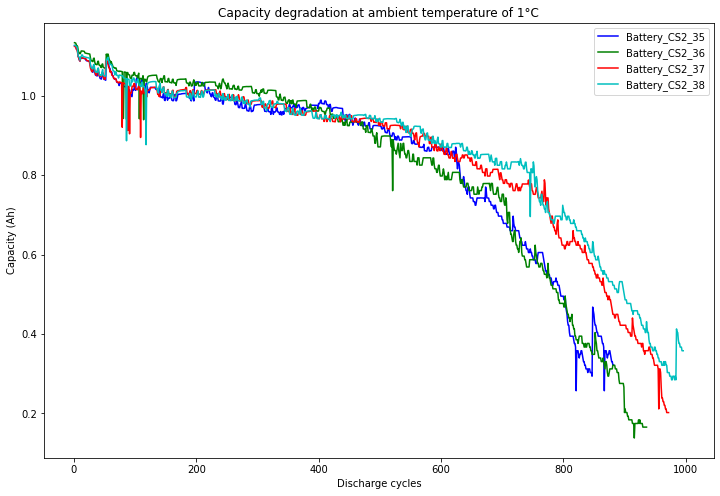

In [ ]:
# Rated_Capacity = 1.1
fig, ax = plt.subplots(1, figsize=(12,8))
color_list = ['b', 'g', 'r', 'c']
for name,color in zip(Battery_list, color_list):
    df_result = Battery[name]
    ax.plot(df_result['cycle'], df_result['capacity'], color, label = 'Battery_'+name)
ax.set(xlabel = 'Discharge cycles', ylabel = 'Capacity (Ah)', title = 'Capacity degradation at ambient temperature of 1°C')
plt.legend()

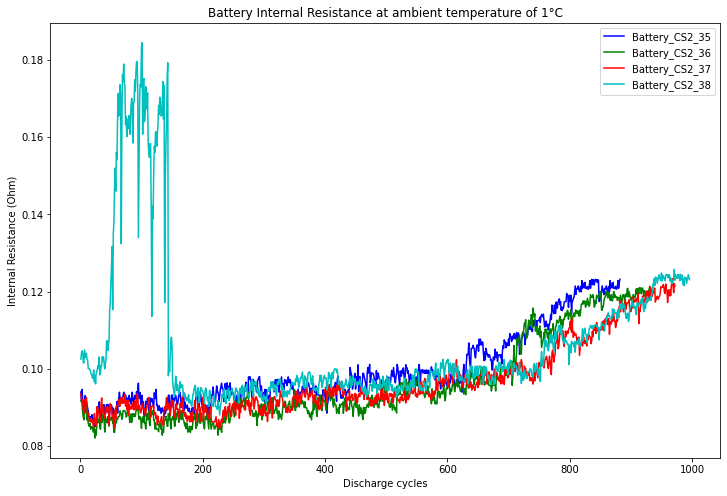

In [ ]:
# Rated_Capacity = 1.1
fig, ax = plt.subplots(1, figsize=(12,8))
color_list = ['b', 'g', 'r', 'c']
for name,color in zip(Battery_list, color_list):
    df_result = Battery[name]
    ax.plot(df_result['cycle'], df_result['resistance'], color, label = 'Battery_'+name)
ax.set(xlabel = 'Discharge cycles', ylabel = 'Internal Resistance (Ohm)', title = 'Battery Internal Resistance at ambient temperature of 1°C')
plt.legend()

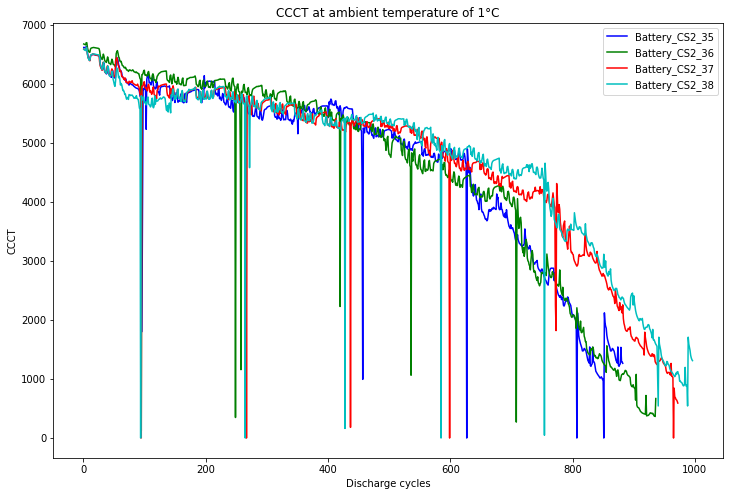

In [ ]:
# Rated_Capacity = 1.1
fig, ax = plt.subplots(1, figsize=(12,8))
color_list = ['b', 'g', 'r', 'c']
for name,color in zip(Battery_list, color_list):
    df_result = Battery[name]
    ax.plot(df_result['cycle'], df_result['CCCT'], color, label = 'Battery_'+name)
ax.set(xlabel = 'Discharge cycles', ylabel = 'CCCT', title = 'CCCT at ambient temperature of 1°C')
plt.legend()

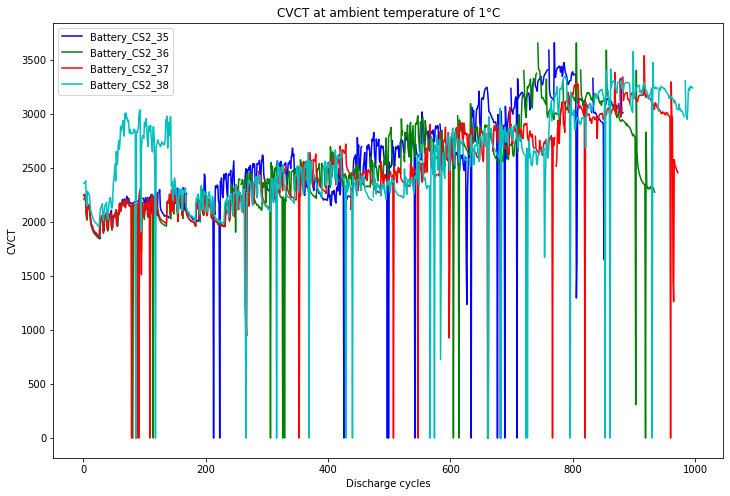

In [ ]:
# Rated_Capacity = 1.1
fig, ax = plt.subplots(1, figsize=(12,8))
color_list = ['b', 'g', 'r', 'c']
for name,color in zip(Battery_list, color_list):
    df_result = Battery[name]
    ax.plot(df_result['cycle'], df_result['CVCT'], color, label = 'Battery_'+name)
ax.set(xlabel = 'Discharge cycles', ylabel = 'CVCT', title = 'CVCT at ambient temperature of 1°C')
plt.legend()

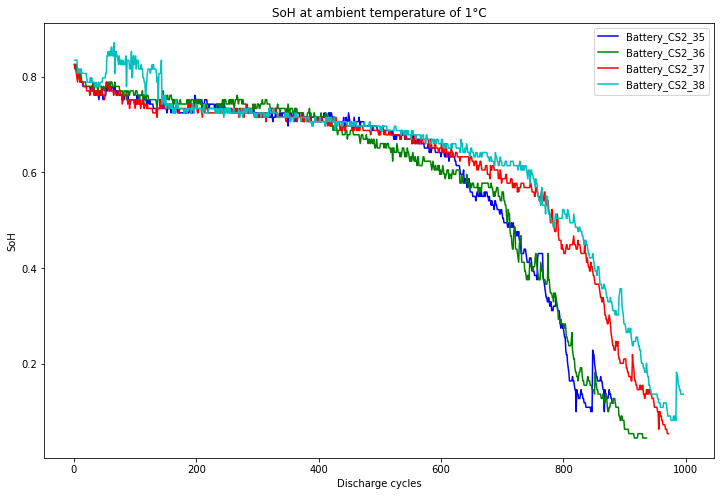

In [ ]:
# Rated_Capacity = 1.1
fig, ax = plt.subplots(1, figsize=(12,8))
color_list = ['b', 'g', 'r', 'c']
for name,color in zip(Battery_list, color_list):
    df_result = Battery[name]
    ax.plot(df_result['cycle'], df_result['SoH'], color, label = 'Battery_'+name)
ax.set(xlabel = 'Discharge cycles', ylabel = 'SoH', title = 'SoH at ambient temperature of 1°C')
plt.legend()

In [ ]:
df_cp = Charge_Profiles['CS2_35']
len(df_cp['Voltage'])

936

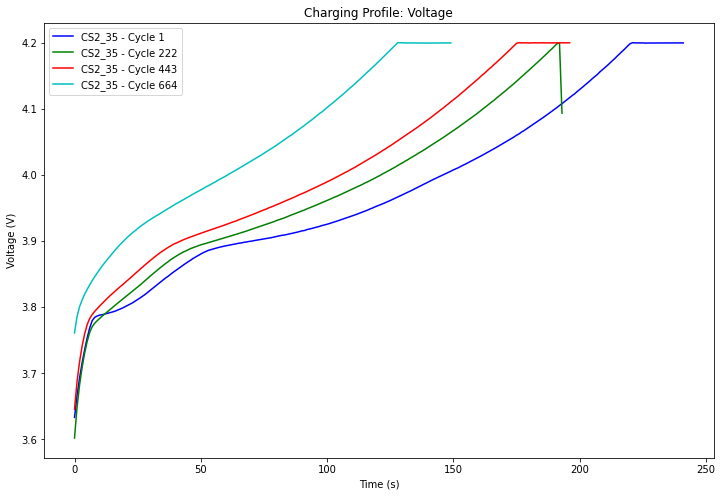

In [ ]:
fig, ax = plt.subplots(1, figsize=(12, 8))
color_list = ['b', 'g', 'r', 'c']
sample_size = 4
df_result = Charge_Profiles['CS2_35']
population = len(df_result['Voltage'])
step = math.ceil(population/sample_size)
selected_index = np.arange(1, population, step)
df_result = Charge_Profiles['CS2_35']
for idx in range(sample_size): 
    x = range(len(df_result['Voltage'][selected_index[idx]]))
    ax.plot(x, df_result['Voltage'][selected_index[idx]], color_list[idx], label= 'CS2_35 - Cycle '+ str(selected_index[idx]))
ax.set(xlabel='Time (s)', ylabel='Voltage (V)', title='Charging Profile: Voltage')
plt.legend()

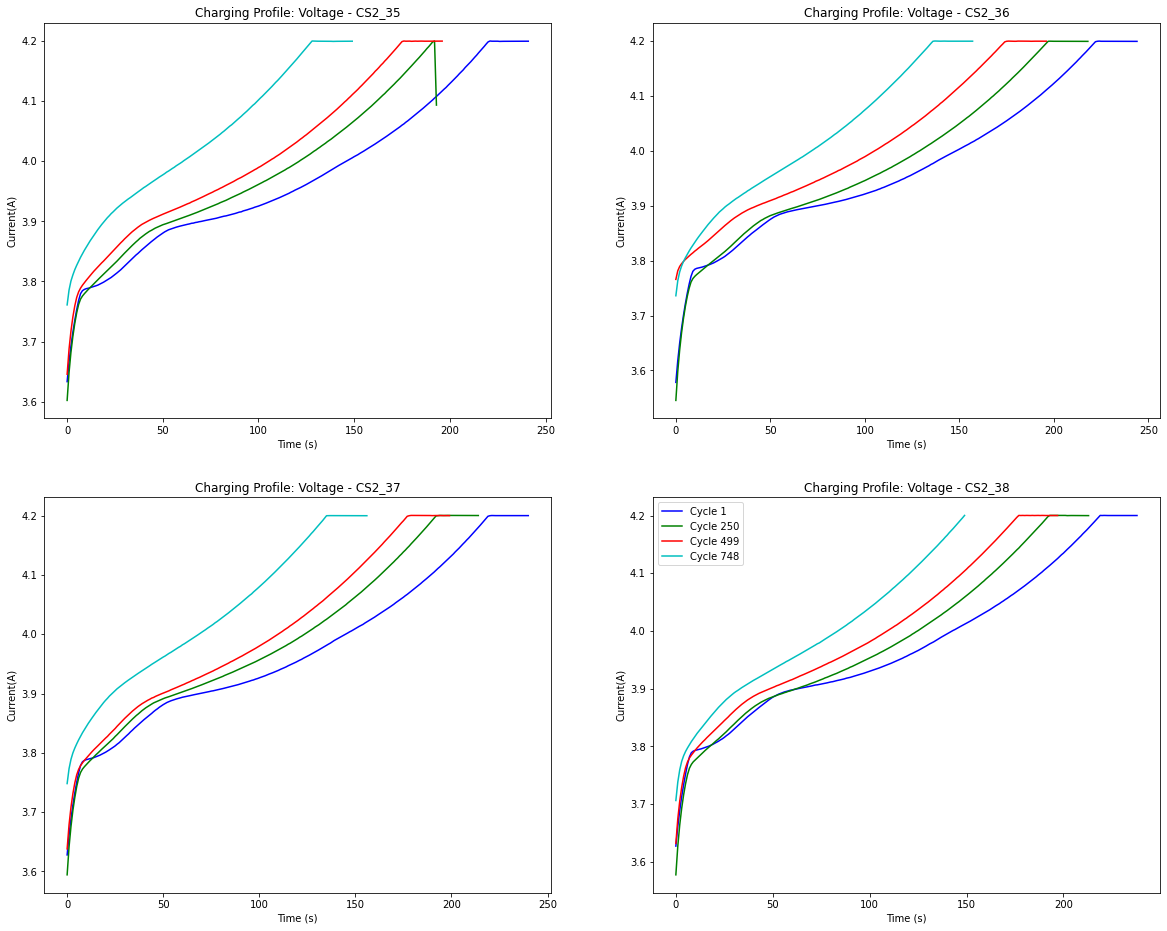

In [ ]:
fig, ax = plt.subplots(2,2, figsize = (20, 16))
x = [0, 0, 1, 1]
y = [0, 1, 0, 1]
for i in range(0,4):
    df_result = Charge_Profiles[Battery_list[i]]
    color_list = ['b', 'g', 'r', 'c']
    sample_size = 4
    population = len(df_result['Voltage'])
    step = math.ceil(population/sample_size)
    selected_index = np.arange(1, population, step)
    for idx in range(sample_size): 
        time = range(len(df_result['Voltage'][selected_index[idx]]))
        ax[x[i], y[i]].plot(time, df_result['Voltage'][selected_index[idx]], color_list[idx], label= 'Cycle '+ str(selected_index[idx]))
    ax[x[i], y[i]].set(xlabel='Time (s)', ylabel='Current(A)', title='Charging Profile: Voltage - '+ Battery_list[i])
plt.legend()

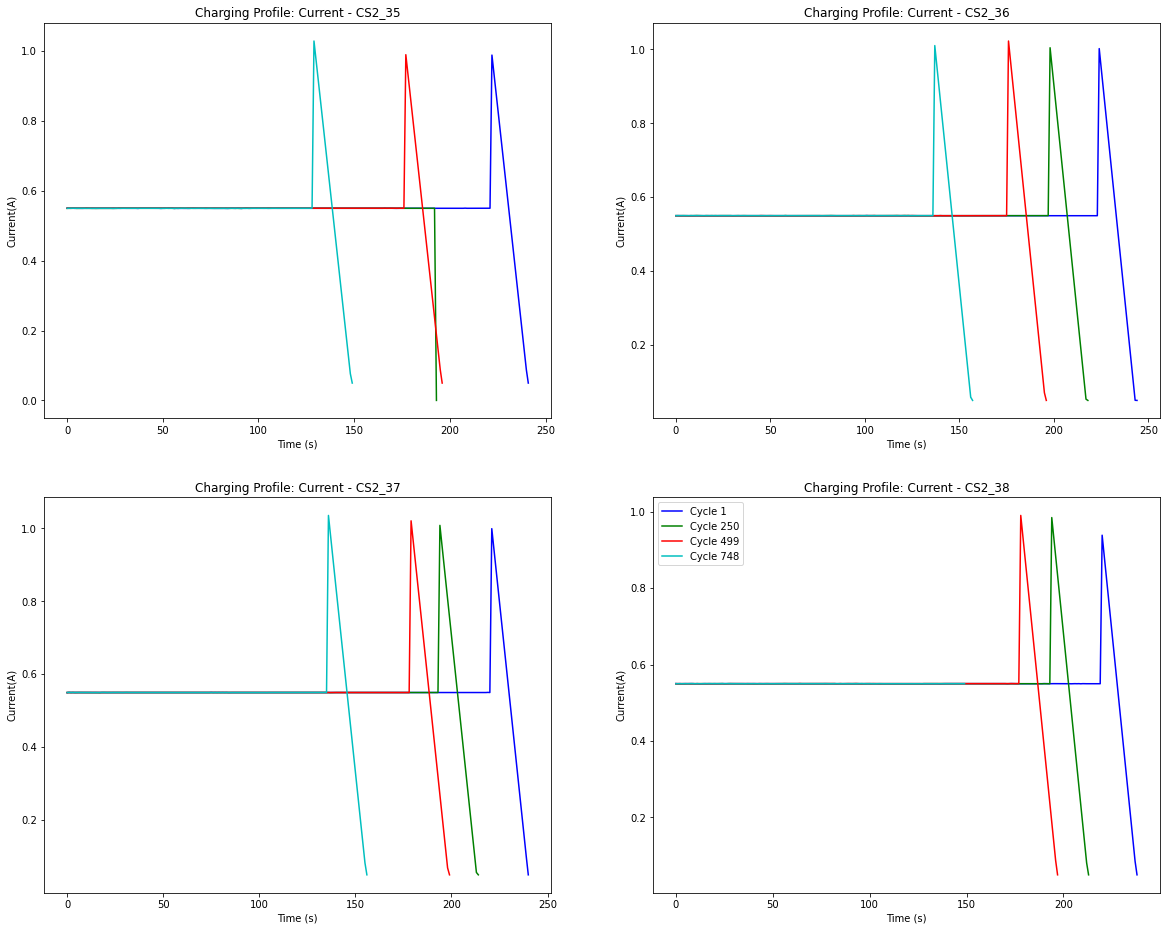

In [ ]:
fig, ax = plt.subplots(2,2, figsize = (20, 16))
x = [0, 0, 1, 1]
y = [0, 1, 0, 1]
for i in range(0,4):
    df_result = Charge_Profiles[Battery_list[i]]
    color_list = ['b', 'g', 'r', 'c']
    sample_size = 4
    population = len(df_result['Current'])
    step = math.ceil(population/sample_size)
    selected_index = np.arange(1, population, step)
    for idx in range(sample_size): 
        time = range(len(df_result['Current'][selected_index[idx]]))
        ax[x[i], y[i]].plot(time, df_result['Current'][selected_index[idx]], color_list[idx], label= 'Cycle '+ str(selected_index[idx]))
    ax[x[i], y[i]].set(xlabel='Time (s)', ylabel='Current(A)', title='Charging Profile: Current - '+ Battery_list[i])
plt.legend()

## Data Processing

Variables:

- `Battery_list = ['CS2_35', 'CS2_36', 'CS2_37', 'CS2_38']`
- `Battery[name]` - contains the cycle, capacity and internal resistance
- `Charge_Profiles[name]` - contains the voltage and current

For this version, we are only using 22 Dimension Input, since the battery temperature wasn't measured. We are replacing the battery temperature, with the internal resistance. As seen in the plot above, as the battery ages over time, the internal resistance measured from the battery increases. 

### Normalizing the Charge_Profiles and the Battery Capacity

#### Normalizing and Sampling Voltage and Current 

In [ ]:
def FindMinMax(df, Battery_list, params):
    final_max = -(sys.maxsize)
    final_min = sys.maxsize
    for name in Battery_list:
        batt_max = []
        batt_min = []
        for i in range(len(df[name][params])):
            set_max, set_min = np.nanmax(df[name][params][i]), np.nanmin(df[name][params][i])
            batt_max.append(set_max)
            batt_min.append(set_min)
        temp_max = max(batt_max)
        temp_min = min(batt_min)
        if temp_max > final_max:
            final_max = temp_max
        
        if temp_min < final_min:
            final_min = temp_min
        print(f"Battery[{name}] - Max: {temp_max} | Min: {temp_min}")
    print(f"Maximum: {final_max} | Minimum: {final_min}") 
    return final_max, final_min

def NormalizeData(Charge_Profiles, Battery_list):
    parameters = ['Voltage', 'Current']
    df = copy.deepcopy(Charge_Profiles)
    for params in parameters:
        oa_max, oa_min = FindMinMax(df, Battery_list, params)
        for name in Battery_list:
            for i in range(len(df[name][params])):
                for j in range(len(df[name][params][i])):
                    df[name][params][i][j] = (df[name][params][i][j] - oa_min) / (oa_max - oa_min)
    print("Normalization Done!")
    return df


In [ ]:
df = NormalizeData(Charge_Profiles, Battery_list)

Battery[CS2_35] - Max: 4.200300693511963 | Min: 3.4794235229492188
Battery[CS2_36] - Max: 4.200854301452637 | Min: 3.419985055923462
Battery[CS2_37] - Max: 4.2155985832214355 | Min: 3.466411590576172
Battery[CS2_38] - Max: 4.212934494018555 | Min: 3.4727344512939453
Maximum: 4.2155985832214355 | Minimum: 3.419985055923462
Battery[CS2_35] - Max: 1.0738835334777832 | Min: 0.0001613661734154448
Battery[CS2_36] - Max: 1.0815509557724 | Min: -0.6620013117790222
Battery[CS2_37] - Max: 1.1539158821105957 | Min: 0.00140577950514853
Battery[CS2_38] - Max: 1.0766491889953613 | Min: -0.00017375434981659055
Maximum: 1.1539158821105957 | Minimum: -0.6620013117790222
Normalization Done!


In [ ]:
### Systematic Sampling for Voltages and Currents
def SystematicSampling(df, sample_size):
    random.seed(1)
    population = len(df)
    step = math.ceil(population/sample_size)
    selected_index = np.arange(0, population, step)
    if len(selected_index) < 10:
        len_list = list(range(0, population))
        selected_index = random.sample(len_list, sample_size)
        selected_index.sort()
    ''' 
        selected_index = np.append(selected_index, population-2)
        selected_index = np.append(selected_index, population-1)
    elif len(selected_index) < 10:
        selected_index = np.append(selected_index, population-1)
    '''
    samples = []
    for i in range(len(selected_index)):
        selected_sample = df[selected_index[i]]
        samples.append(selected_sample)
    return samples

def ChargeProfileSampling(df, Battery_list, sample_size):
    parameters = ['Voltage', 'Current']
    sampled_profiles = {}
    for name in Battery_list:
        d1 = {}
        for params in parameters:
            samples = []
            for i in range(len(df[name][params])):
                sampled_list = SystematicSampling(df=df[name][params][i], 
                                                  sample_size=sample_size)
                samples.append(sampled_list)
            d1[params] = samples
        sampled_profiles[name] = d1
    return sampled_profiles

In [ ]:
sampled_profile = ChargeProfileSampling(df, Battery_list, sample_size=10)

#### Normalizing Battery Capacity and Internal Resistance

- `Battery_list`
- `Battery[name]` - `['capacity', 'resistance']`

In [ ]:
def Normalize_CapRes(Battery, Battery_list):
    df = copy.deepcopy(Battery)
    parameters = ['capacity', 'resistance']
    for params in parameters:
        arr_max = []
        arr_min = []
        for name in Battery_list:
            step_max, step_min = np.nanmax(df[name][params]), np.nanmin(df[name][params])
            arr_max.append(step_max)
            arr_min.append(step_min)
        fin_max, fin_min = max(arr_max), min(arr_min)
        print(f"{params}: {fin_max} | {fin_min}")

        for name in Battery_list:
            for i in range(len(df[name][params])):
                df[name][params][i] = (df[name][params][i] - fin_min) / (fin_max - fin_min)
    return df

In [ ]:
normalized = Normalize_CapRes(Battery, Battery_list)

capacity: 1.1338066110520781 | 0.13754795953533758
resistance: 0.18449176847934723 | 0.0820472314953804


### Combining to create an Input Dimension

variables
- `normalized` - contains normalized capacity and internal resistance
- `sampled_profile` - contains the sampled voltages and currents 

In [ ]:
def concatCPandCap(sampled_profile, normalized, Battery_list):
    Input22Dim = {}
    for name in Battery_list:
        V = sampled_profile[name]['Voltage']
        V.pop(-1)
        C = sampled_profile[name]['Current']
        C.pop(-1)
        IR = list(normalized[name]['resistance'])
        IR.pop(-1)
        Cap = list(normalized[name]['capacity'])
        Cap.pop(-1)

        inputs = []
        for i in range(len(V)):
            one_row = [*V[i], *C[i], IR[i], Cap[i]]
            inputs.append(one_row)
        
        Input22Dim[name] = inputs
    return Input22Dim

In [ ]:
Input22Dim = concatCPandCap(sampled_profile, normalized, Battery_list)

In [ ]:
input = torch.Tensor(Input22Dim['CS2_38'])

In [ ]:
input.shape

torch.Size([995, 22])

### Preparing y_train values

In [ ]:
y_battery = {}
for name in Battery_names:
  df_cap = copy.deepcopy(Battery[name]['capacity'])
  df_cap = list(df_cap)
  df_cap.pop(0)                                 # remove first element
  print(f"New length of {name}: {len(df_cap)}")
  y_battery[name] = df_cap

New length of CS2_35: 881
New length of CS2_36: 935
New length of CS2_37: 971
New length of CS2_38: 995


## RNN Model 

In [ ]:
class RNNScratch(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNScratch, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.i2h = nn.Linear(input_size, hidden_size, bias=False)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden_state):
        x = self.i2h(x)
        hidden_state = self.h2h(hidden_state)
        hidden_state = F.relu(x + hidden_state)
        out = self.h2o(hidden_state)
        return out, hidden_state

    def init_zero_hidden(self):
        return torch.zeros(1, self.hidden_size)

## Metrics

In [ ]:
from timeit import default_timer as timer
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from collections import Counter
import linecache
import os
import tracemalloc

# Compute for accuracy
def accuracy(y_test, y_pred):
  error = np.abs(y_pred-y_test)/y_test
  acc = np.ones_like(error) - error
  acc = np.sum(acc)/len(y_pred)
  return float(acc)

# Print Inference Time
def print_inference_time(start: float,
                         end: float,
                         device: torch.device = None):
    
  """
  Prints difference between start and end time
  """

  total_time = end - start
  print(f"Inference time on {device}: {total_time:.3f} seconds")

  return total_time

# Print Memory Usage

def memory_stats(snapshot, key_type='lineno'):
  snapshot = snapshot.filter_traces((
      tracemalloc.Filter(False, "<frozen importlib._bootstrap>"),
      tracemalloc.Filter(False, "<unknown>"),
  ))
  usage_stat = snapshot.statistics(key_type)

  total = sum(stat.size for stat in usage_stat)

  print("Allocated memory: %.1f KiB" % (total / 1024))

## Training Using Datasets CS2_35, CS2_36 and CS2_37 and Test on CS2_38

In [ ]:
# Setting up device-agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
from tqdm.auto import tqdm
import sys
torch.manual_seed(42)

input_size = 22
hidden_size = 10
output_size = 1
model_0 = RNNScratch(input_size=input_size, 
                     hidden_size=hidden_size, 
                     output_size=output_size)
model_0 = model_0.to(device)

loss_fn = nn.HuberLoss()
#loss_fn = nn.MSELoss()
learning_rate = 0.005
epochs = 1000
#weight_decay = 1e-4
optimizer = torch.optim.Adam(model_0.parameters(), lr=learning_rate) #, weight_decay=weight_decay)

In [ ]:
def train(model, input_data, y_battery, epochs, train_names, test_name, iterations):
    best_model = None
    min_val_loss = sys.maxsize
    for i in range(iterations):
        print(f"Iteration: {i}")
        total_loss = {}
        for epoch in tqdm(range(epochs)):
            for name in train_names:
                model.train()
                x_train = torch.tensor(input_data[name], dtype=torch.float32)
                y_train = torch.tensor(y_battery[name], dtype=torch.float32).unsqueeze(1)
                epoch_loss = []
                X = x_train.to(device)
                Y = y_train.to(device)
            
                hidden = model.init_zero_hidden()
                hidden = hidden.to(device)
                out = []
                for i in range(X.size()[0]):
                    # 1. Forward Pass
                    output, hidden = model(X[i], hidden)
                    out.append(output)

                y = torch.stack(out).to(device)
                # 2. Calculate Loss
                loss = loss_fn(y.squeeze(-1), Y) 
        
                # 3. Optimizer zero grad
                optimizer.zero_grad()

                # 4. Loss backwards
                loss.backward()

                # 5. Optimizer step
                optimizer.step()

                # Testing
                model.eval()
                with torch.inference_mode():
                    x_test = torch.tensor(input_data[test_name], dtype=torch.float32)
                    y_test = torch.tensor(y_battery[test_name], dtype=torch.float32).unsqueeze(1)
                    X_test = x_test.to(device)
                    Y_test = y_test.to(device)
                    hidden = model.init_zero_hidden()
                    hidden = hidden.to(device)
                    test_out = []
                    for i in range(X_test.size()[0]):
                        # 1. Forward Pass
                        test_output, hidden = model(X_test[i], hidden)
                        test_out.append(test_output)
                
                    y_pred = torch.stack(test_out).to(device)
                    # 2. Calculate Loss
                    test_loss = loss_fn(y_pred.squeeze(-1), Y_test)
                
                    # get best model
                    if test_loss.item() < min_val_loss:
                        best_model = copy.deepcopy(model).to(device)
                        min_val_loss = test_loss.item()


                if epoch % 100 == 0:
                    print(f"Train Set: {name} | Epoch: {epoch} | Train Loss: {loss:.6f} | Test Set: {test_name} Test Loss: {test_loss:.6f}")
                    epoch_loss.append(loss)
            total_loss[name] = epoch_loss

    return total_loss, best_model, min_val_loss

In [ ]:
train_names = ['CS2_35', 'CS2_36', 'CS2_37']
test_name = 'CS2_38'
iterations = 1
total_loss, best_model_B38, min_val_loss_B38 = train(model_0, Input22Dim, y_battery, epochs, train_names, test_name, iterations)

Iteration: 0


  0%|          | 0/1000 [00:00<?, ?it/s]

Train Set: CS2_35 | Epoch: 0 | Train Loss: 0.387386 | Test Set: CS2_38 Test Loss: 0.345284
Train Set: CS2_36 | Epoch: 0 | Train Loss: 0.331787 | Test Set: CS2_38 Test Loss: 0.311148
Train Set: CS2_37 | Epoch: 0 | Train Loss: 0.306188 | Test Set: CS2_38 Test Loss: 0.287334
Train Set: CS2_35 | Epoch: 100 | Train Loss: 0.000459 | Test Set: CS2_38 Test Loss: 0.004174
Train Set: CS2_36 | Epoch: 100 | Train Loss: 0.000448 | Test Set: CS2_38 Test Loss: 0.004240
Train Set: CS2_37 | Epoch: 100 | Train Loss: 0.000418 | Test Set: CS2_38 Test Loss: 0.004377
Train Set: CS2_35 | Epoch: 200 | Train Loss: 0.000318 | Test Set: CS2_38 Test Loss: 0.003049
Train Set: CS2_36 | Epoch: 200 | Train Loss: 0.000342 | Test Set: CS2_38 Test Loss: 0.003149
Train Set: CS2_37 | Epoch: 200 | Train Loss: 0.000268 | Test Set: CS2_38 Test Loss: 0.003293
Train Set: CS2_35 | Epoch: 300 | Train Loss: 0.000227 | Test Set: CS2_38 Test Loss: 0.001714
Train Set: CS2_36 | Epoch: 300 | Train Loss: 0.000266 | Test Set: CS2_38 Tes

In [ ]:
def trainv2(model, input_data, y_battery, epochs, train_names, iterations):
    #best_model = None
    #min_val_loss = sys.maxsize
    for i in range(iterations):
        print(f"Iteration: {i}")
        total_loss = {}
        for epoch in tqdm(range(epochs)):
            train_set = random.sample(train_names, k=2)
            val_set = list(set(train_names).difference(train_set))
            for name in train_set:
                model.train()
                x_train = torch.tensor(input_data[name], dtype=torch.float32)
                y_train = torch.tensor(y_battery[name], dtype=torch.float32).unsqueeze(1)
                epoch_loss = []
                X = x_train.to(device)
                Y = y_train.to(device)
            
                hidden = model.init_zero_hidden()
                hidden = hidden.to(device)
                out = []
                for i in range(X.size()[0]):
                    # 1. Forward Pass
                    output, hidden = model(X[i], hidden)
                    out.append(output)

                y = torch.stack(out).to(device)
                # 2. Calculate Loss
                loss = loss_fn(y.squeeze(-1), Y) 
        
                # 3. Optimizer zero grad
                optimizer.zero_grad()

                # 4. Loss backwards
                loss.backward()

                # 5. Optimizer step
                optimizer.step()

                # Testing
                model.eval()
                with torch.inference_mode():
                    x_test = torch.tensor(input_data[val_set[0]], dtype=torch.float32)
                    y_test = torch.tensor(y_battery[val_set[0]], dtype=torch.float32).unsqueeze(1)
                    X_test = x_test.to(device)
                    Y_test = y_test.to(device)
                    hidden = model.init_zero_hidden()
                    hidden = hidden.to(device)
                    test_out = []
                    for i in range(X_test.size()[0]):
                        # 1. Forward Pass
                        test_output, hidden = model(X_test[i], hidden)
                        test_out.append(test_output)
                
                    y_pred = torch.stack(test_out).to(device)
                    # 2. Calculate Loss
                    test_loss = loss_fn(y_pred.squeeze(-1), Y_test)
                
                    # get best model
                    #if test_loss.item() < min_val_loss:
                        #best_model = copy.deepcopy(model).to(device)
                        #min_val_loss = test_loss.item()


                if epoch % 100 == 0:
                    print(f"Train Set: {name} | Epoch: {epoch} | Train Loss: {loss:.6f} | Test Set: {val_set[0]} Test Loss: {test_loss:.6f}")
                    epoch_loss.append(loss)
            total_loss[name] = epoch_loss

    return total_loss

In [ ]:
train_names = ['CS2_35', 'CS2_36', 'CS2_37']
iterations = 1
total_loss = trainv2(model_0, Input22Dim, y_battery, epochs, train_names, iterations)

Iteration: 0


  0%|          | 0/1000 [00:00<?, ?it/s]

Train Set: CS2_36 | Epoch: 0 | Train Loss: 0.371161 | Test Set: CS2_35 Test Loss: 0.345979
Train Set: CS2_37 | Epoch: 0 | Train Loss: 0.339288 | Test Set: CS2_35 Test Loss: 0.312178
Train Set: CS2_35 | Epoch: 100 | Train Loss: 0.000466 | Test Set: CS2_37 Test Loss: 0.000520
Train Set: CS2_36 | Epoch: 100 | Train Loss: 0.000572 | Test Set: CS2_37 Test Loss: 0.000502
Train Set: CS2_37 | Epoch: 200 | Train Loss: 0.000381 | Test Set: CS2_35 Test Loss: 0.000492
Train Set: CS2_36 | Epoch: 200 | Train Loss: 0.000370 | Test Set: CS2_35 Test Loss: 0.000556
Train Set: CS2_36 | Epoch: 300 | Train Loss: 0.000519 | Test Set: CS2_37 Test Loss: 0.000510
Train Set: CS2_35 | Epoch: 300 | Train Loss: 0.000326 | Test Set: CS2_37 Test Loss: 0.000487
Train Set: CS2_37 | Epoch: 400 | Train Loss: 0.000250 | Test Set: CS2_35 Test Loss: 0.000351
Train Set: CS2_36 | Epoch: 400 | Train Loss: 0.000264 | Test Set: CS2_35 Test Loss: 0.000389
Train Set: CS2_35 | Epoch: 500 | Train Loss: 0.000218 | Test Set: CS2_36 T

In [ ]:
def test(best_model, input_data, y_battery, test_name):
    best_model.eval()
    with torch.inference_mode():
        x_test = torch.tensor(input_data[test_name], dtype=torch.float32)
        y_test = torch.tensor(y_battery[test_name], dtype=torch.float32).unsqueeze(1)
        X_test = x_test.to(device)
        Y_test = y_test.to(device)
        hidden = best_model.init_zero_hidden()
        hidden = hidden.to(device)
        test_out = []
        for i in range(X_test.size()[0]):
            # 1. Forward Pass
            test_output, hidden = best_model(X_test[i], hidden)
            test_out.append(test_output)
                
        y_pred = torch.stack(test_out).to(device)
        # 2. Calculate Loss
        test_loss = loss_fn(y_pred.squeeze(-1), Y_test)
    return test_loss, Y_test, y_pred

Test Loss: 0.0001 | MAE: 0.0089 | MSE: 0.0158 | Accuracy: 0.99
Inference time on cuda: 0.132 seconds
Allocated memory: 20.1 KiB


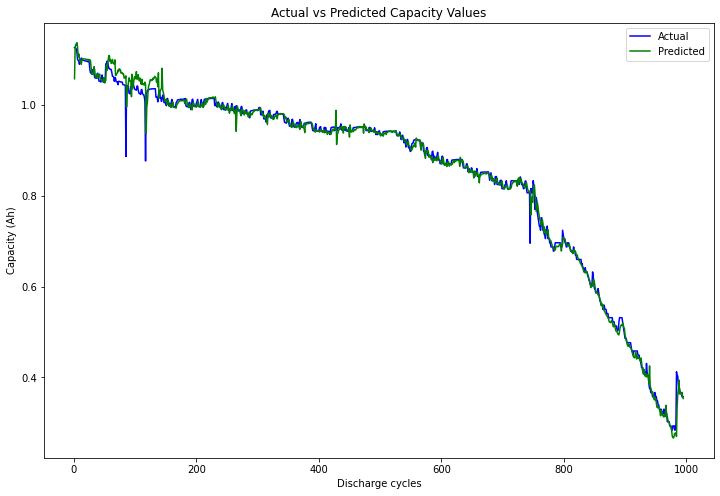

In [ ]:
# timer
start_time = timer()
tracemalloc.start()

test_name = 'CS2_38'
test_loss, Y_test, y_pred = test(best_model=best_model_B38,
                                 input_data=Input22Dim,
                                 y_battery=y_battery,
                                 test_name=test_name)

acc = accuracy(Y_test.cpu().detach().numpy(), y_pred.squeeze(-1).cpu().detach().numpy())
mae = mean_absolute_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy())
mse = sqrt(mean_squared_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy()))
print(f"Test Loss: {test_loss:.4f} | MAE: {mae:.4f} | MSE: {mse:.4f} | Accuracy: {acc:.2f}")

end_time = timer()
snapshot = tracemalloc.take_snapshot()

print_inference_time(start_time, end_time, device)
memory_stats(snapshot)
y_pred = y_pred.cpu().detach().numpy().squeeze()
fig, ax = plt.subplots(1, figsize=(12, 8))
color_list = ['b:', 'g--', 'r-.', 'c.']
y = list(range(1, len(y_pred)+1))
ax.plot(y, y_battery[test_name], 'b', label='Actual')
ax.plot(y, y_pred, 'g', label='Predicted')
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Actual vs Predicted Capacity Values')
plt.legend()

Test Loss: 0.0004 | MAE: 0.0163 | MSE: 0.0290 | Accuracy: 0.98
True RUL: 752 | Prediction RUL: 755 | RUL Error: -3
Inference time on cuda: 0.247 seconds
Allocated memory: 1442.6 KiB


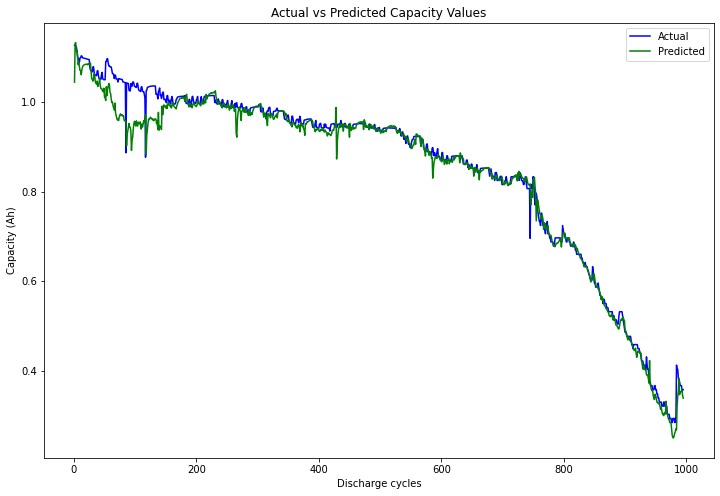

In [ ]:
# timer
start_time = timer()
tracemalloc.start()
Rated_Capacity = 1.1
test_name = 'CS2_38'
test_loss, Y_test, y_pred = test(best_model=model_0,
                                 input_data=Input22Dim,
                                 y_battery=y_battery,
                                 test_name=test_name)

acc = accuracy(Y_test.cpu().detach().numpy(), y_pred.squeeze(-1).cpu().detach().numpy())
mae = mean_absolute_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy())
mse = sqrt(mean_squared_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy()))
# Computing RUL Error
Threshold = 0.7 * Rated_Capacity
idx_true = (Y_test<Threshold).nonzero().squeeze()
RUL_true = idx_true[0][0]
if(torch.Tensor(Y_test[int(RUL_true + 1)])>Threshold):
    RUL_true = idx_true[1][0]

idx_pred = (y_pred<Threshold).nonzero().squeeze()  # search idx less than threshold
RUL_pred = idx_pred[0][0]                        # first entry is pred RUL
if(torch.Tensor(Y_test[int(RUL_pred + 1)])>Threshold):
        RUL_pred = idx_pred[1][0]
RUL_error = RUL_true - RUL_pred
print(f"Test Loss: {test_loss:.4f} | MAE: {mae:.4f} | MSE: {mse:.4f} | Accuracy: {acc:.2f}")
print(f"True RUL: {int(RUL_true)} | Prediction RUL: {int(RUL_pred)} | RUL Error: {int(RUL_error)}")

end_time = timer()
snapshot = tracemalloc.take_snapshot()

print_inference_time(start_time, end_time, device)
memory_stats(snapshot)
y_pred = y_pred.cpu().detach().numpy().squeeze()
fig, ax = plt.subplots(1, figsize=(12, 8))
color_list = ['b:', 'g--', 'r-.', 'c.']
y = list(range(1, len(y_pred)+1))
ax.plot(y, y_battery[test_name], 'b', label='Actual')
ax.plot(y, y_pred, 'g', label='Predicted')
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Actual vs Predicted Capacity Values')
plt.legend()

## Training Using Datasets CS2_36, CS2_37 and CS2_38 and Test on CS2_35

In [ ]:
# Setting up device-agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
from tqdm.auto import tqdm
import sys
torch.manual_seed(42)

input_size = 22
hidden_size = 10
output_size = 1
model_1 = RNNScratch(input_size=input_size, 
                     hidden_size=hidden_size, 
                     output_size=output_size)
model_1 = model_1.to(device)

loss_fn = nn.HuberLoss()
#loss_fn = nn.MSELoss()
learning_rate = 0.005
epochs = 1000
#weight_decay = 1e-4
optimizer = torch.optim.Adam(model_1.parameters(), lr=learning_rate) #, weight_decay=weight_decay)

In [ ]:
train_names = ['CS2_36', 'CS2_37', 'CS2_38']
test_name = 'CS2_35'
iterations = 1
total_loss, best_model_B35, min_val_loss_B35 = train(model_1, Input22Dim, y_battery, epochs, train_names, test_name, iterations)

Iteration: 0


  0%|          | 0/1000 [00:00<?, ?it/s]

Train Set: CS2_36 | Epoch: 0 | Train Loss: 0.371161 | Test Set: CS2_35 Test Loss: 0.345979
Train Set: CS2_37 | Epoch: 0 | Train Loss: 0.339288 | Test Set: CS2_35 Test Loss: 0.312178
Train Set: CS2_38 | Epoch: 0 | Train Loss: 0.311035 | Test Set: CS2_35 Test Loss: 0.289450
Train Set: CS2_36 | Epoch: 100 | Train Loss: 0.000399 | Test Set: CS2_35 Test Loss: 0.000436
Train Set: CS2_37 | Epoch: 100 | Train Loss: 0.000437 | Test Set: CS2_35 Test Loss: 0.000437
Train Set: CS2_38 | Epoch: 100 | Train Loss: 0.000488 | Test Set: CS2_35 Test Loss: 0.000435
Train Set: CS2_36 | Epoch: 200 | Train Loss: 0.000257 | Test Set: CS2_35 Test Loss: 0.000251
Train Set: CS2_37 | Epoch: 200 | Train Loss: 0.000250 | Test Set: CS2_35 Test Loss: 0.000250
Train Set: CS2_38 | Epoch: 200 | Train Loss: 0.000264 | Test Set: CS2_35 Test Loss: 0.000249
Train Set: CS2_36 | Epoch: 300 | Train Loss: 0.000194 | Test Set: CS2_35 Test Loss: 0.000156
Train Set: CS2_37 | Epoch: 300 | Train Loss: 0.000158 | Test Set: CS2_35 Tes

In [ ]:
train_names = ['CS2_36', 'CS2_37', 'CS2_38']
iterations = 1
total_loss = trainv2(model_1, Input22Dim, y_battery, epochs, train_names, iterations)

Iteration: 0


  0%|          | 0/1000 [00:00<?, ?it/s]

Train Set: CS2_37 | Epoch: 0 | Train Loss: 0.380281 | Test Set: CS2_38 Test Loss: 0.345284
Train Set: CS2_36 | Epoch: 0 | Train Loss: 0.331787 | Test Set: CS2_38 Test Loss: 0.311142
Train Set: CS2_37 | Epoch: 100 | Train Loss: 0.000657 | Test Set: CS2_36 Test Loss: 0.001213
Train Set: CS2_38 | Epoch: 100 | Train Loss: 0.001659 | Test Set: CS2_36 Test Loss: 0.001278
Train Set: CS2_38 | Epoch: 200 | Train Loss: 0.000581 | Test Set: CS2_37 Test Loss: 0.000519
Train Set: CS2_36 | Epoch: 200 | Train Loss: 0.000555 | Test Set: CS2_37 Test Loss: 0.000533
Train Set: CS2_37 | Epoch: 300 | Train Loss: 0.000454 | Test Set: CS2_38 Test Loss: 0.000484
Train Set: CS2_36 | Epoch: 300 | Train Loss: 0.000427 | Test Set: CS2_38 Test Loss: 0.000484
Train Set: CS2_38 | Epoch: 400 | Train Loss: 0.000423 | Test Set: CS2_36 Test Loss: 0.000365
Train Set: CS2_37 | Epoch: 400 | Train Loss: 0.000387 | Test Set: CS2_36 Test Loss: 0.000369
Train Set: CS2_36 | Epoch: 500 | Train Loss: 0.000314 | Test Set: CS2_37 T

Test Loss: 0.0001 | MAE: 0.0072 | MSE: 0.0132 | Accuracy: 0.99
Inference time on cuda: 0.098 seconds
Allocated memory: 1945.3 KiB


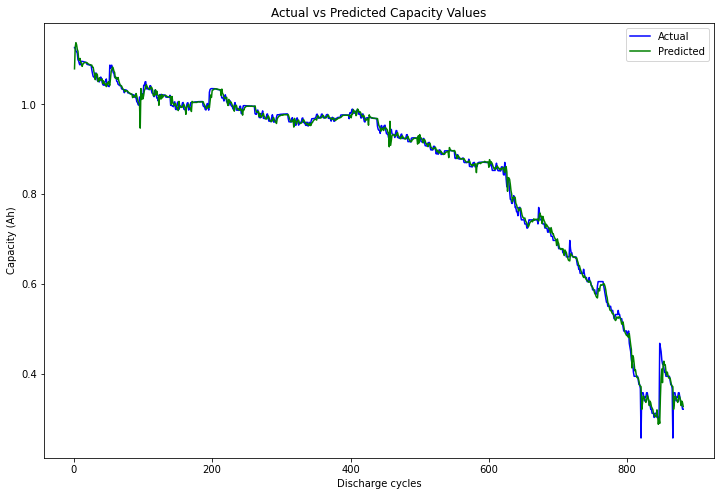

In [ ]:
# timer
start_time = timer()
tracemalloc.start()

test_name = 'CS2_35'
test_loss, Y_test, y_pred = test(best_model=best_model_B35,
                                 input_data=Input22Dim,
                                 y_battery=y_battery,
                                 test_name=test_name)

acc = accuracy(Y_test.cpu().detach().numpy(), y_pred.squeeze(-1).cpu().detach().numpy())
mae = mean_absolute_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy())
mse = sqrt(mean_squared_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy()))
print(f"Test Loss: {test_loss:.4f} | MAE: {mae:.4f} | MSE: {mse:.4f} | Accuracy: {acc:.2f}")

end_time = timer()
snapshot = tracemalloc.take_snapshot()

print_inference_time(start_time, end_time, device)
memory_stats(snapshot)
y_pred = y_pred.cpu().detach().numpy().squeeze()
fig, ax = plt.subplots(1, figsize=(12, 8))
color_list = ['b:', 'g--', 'r-.', 'c.']
y = list(range(1, len(y_pred)+1))
ax.plot(y, y_battery[test_name], 'b', label='Actual')
ax.plot(y, y_pred, 'g', label='Predicted')
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Actual vs Predicted Capacity Values')
plt.legend()

Test Loss: 0.0001 | MAE: 0.0075 | MSE: 0.0155 | Accuracy: 0.99
True RUL: 639 | Prediction RUL: 641 | RUL Error: -2
Inference time on cuda: 0.128 seconds
Allocated memory: 2788.9 KiB


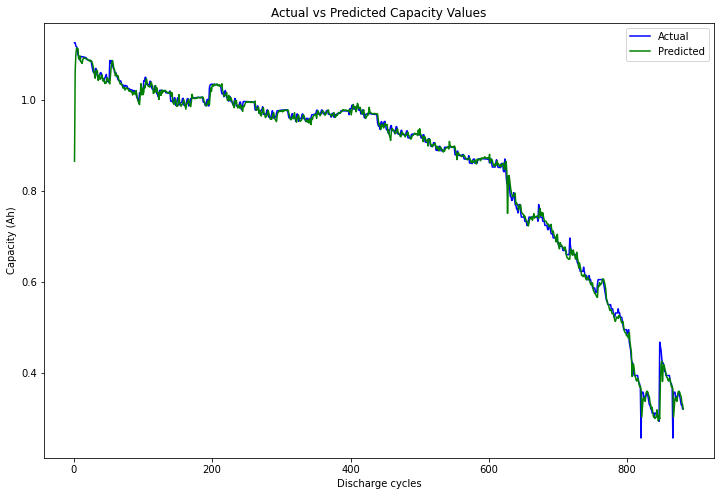

In [ ]:
# timer
start_time = timer()
tracemalloc.start()
Rated_Capacity = 1.1
test_name = 'CS2_35'
test_loss, Y_test, y_pred = test(best_model=model_1,
                                 input_data=Input22Dim,
                                 y_battery=y_battery,
                                 test_name=test_name)

acc = accuracy(Y_test.cpu().detach().numpy(), y_pred.squeeze(-1).cpu().detach().numpy())
mae = mean_absolute_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy())
mse = sqrt(mean_squared_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy()))
# Computing RUL Error
Threshold = 0.7 * Rated_Capacity
idx_true = (Y_test<Threshold).nonzero().squeeze()
RUL_true = idx_true[0][0]
if(torch.Tensor(Y_test[int(RUL_true + 1)])>Threshold):
    RUL_true = idx_true[1][0]

idx_pred = (y_pred<Threshold).nonzero().squeeze()  # search idx less than threshold
RUL_pred = idx_pred[0][0]                        # first entry is pred RUL
if(torch.Tensor(Y_test[int(RUL_pred + 1)])>Threshold):
        RUL_pred = idx_pred[1][0]
RUL_error = RUL_true - RUL_pred
print(f"Test Loss: {test_loss:.4f} | MAE: {mae:.4f} | MSE: {mse:.4f} | Accuracy: {acc:.2f}")
print(f"True RUL: {int(RUL_true)} | Prediction RUL: {int(RUL_pred)} | RUL Error: {int(RUL_error)}")

end_time = timer()
snapshot = tracemalloc.take_snapshot()

print_inference_time(start_time, end_time, device)
memory_stats(snapshot)
y_pred = y_pred.cpu().detach().numpy().squeeze()
fig, ax = plt.subplots(1, figsize=(12, 8))
color_list = ['b:', 'g--', 'r-.', 'c.']
y = list(range(1, len(y_pred)+1))
ax.plot(y, y_battery[test_name], 'b', label='Actual')
ax.plot(y, y_pred, 'g', label='Predicted')
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Actual vs Predicted Capacity Values')
plt.legend()

## Training Using Datasets CS2_35, CS2_37 and CS2_38 and Test on CS2_36

In [ ]:
from tqdm.auto import tqdm
import sys
torch.manual_seed(42)

input_size = 22
hidden_size = 10
output_size = 1
model_2 = RNNScratch(input_size=input_size, 
                     hidden_size=hidden_size, 
                     output_size=output_size)
model_2 = model_2.to(device)

loss_fn = nn.HuberLoss()
#loss_fn = nn.MSELoss()
learning_rate = 0.005
epochs = 1000
#weight_decay = 1e-4
optimizer = torch.optim.Adam(model_2.parameters(), lr=learning_rate) #, weight_decay=weight_decay)

In [ ]:
train_names = ['CS2_35', 'CS2_37', 'CS2_38']
test_name = 'CS2_36'
iterations = 1
total_loss, best_model_B36, min_val_loss_B36 = train(model_2, Input22Dim, y_battery, epochs, train_names, test_name, iterations)

Iteration: 0


  0%|          | 0/1000 [00:00<?, ?it/s]

Train Set: CS2_35 | Epoch: 0 | Train Loss: 0.387386 | Test Set: CS2_36 Test Loss: 0.331787
Train Set: CS2_37 | Epoch: 0 | Train Loss: 0.339288 | Test Set: CS2_36 Test Loss: 0.299263
Train Set: CS2_38 | Epoch: 0 | Train Loss: 0.311077 | Test Set: CS2_36 Test Loss: 0.278177
Train Set: CS2_35 | Epoch: 100 | Train Loss: 0.000402 | Test Set: CS2_36 Test Loss: 0.000375
Train Set: CS2_37 | Epoch: 100 | Train Loss: 0.000399 | Test Set: CS2_36 Test Loss: 0.000366
Train Set: CS2_38 | Epoch: 100 | Train Loss: 0.000416 | Test Set: CS2_36 Test Loss: 0.000370
Train Set: CS2_35 | Epoch: 200 | Train Loss: 0.000177 | Test Set: CS2_36 Test Loss: 0.000216
Train Set: CS2_37 | Epoch: 200 | Train Loss: 0.000184 | Test Set: CS2_36 Test Loss: 0.000218
Train Set: CS2_38 | Epoch: 200 | Train Loss: 0.000191 | Test Set: CS2_36 Test Loss: 0.000213
Train Set: CS2_35 | Epoch: 300 | Train Loss: 0.000136 | Test Set: CS2_36 Test Loss: 0.000197
Train Set: CS2_37 | Epoch: 300 | Train Loss: 0.000138 | Test Set: CS2_36 Tes

In [ ]:
train_names = ['CS2_35', 'CS2_37', 'CS2_38']
iterations = 1
total_loss = trainv2(model_2, Input22Dim, y_battery, epochs, train_names, iterations)

Iteration: 0


  0%|          | 0/1000 [00:00<?, ?it/s]

Train Set: CS2_37 | Epoch: 0 | Train Loss: 0.380281 | Test Set: CS2_35 Test Loss: 0.345979
Train Set: CS2_38 | Epoch: 0 | Train Loss: 0.345284 | Test Set: CS2_35 Test Loss: 0.312310
Train Set: CS2_37 | Epoch: 100 | Train Loss: 0.001146 | Test Set: CS2_35 Test Loss: 0.000843
Train Set: CS2_38 | Epoch: 100 | Train Loss: 0.002136 | Test Set: CS2_35 Test Loss: 0.000815
Train Set: CS2_35 | Epoch: 200 | Train Loss: 0.000483 | Test Set: CS2_37 Test Loss: 0.000551
Train Set: CS2_38 | Epoch: 200 | Train Loss: 0.000549 | Test Set: CS2_37 Test Loss: 0.000546
Train Set: CS2_37 | Epoch: 300 | Train Loss: 0.000472 | Test Set: CS2_35 Test Loss: 0.000394
Train Set: CS2_38 | Epoch: 300 | Train Loss: 0.000443 | Test Set: CS2_35 Test Loss: 0.000394
Train Set: CS2_37 | Epoch: 400 | Train Loss: 0.000396 | Test Set: CS2_35 Test Loss: 0.000326
Train Set: CS2_38 | Epoch: 400 | Train Loss: 0.000368 | Test Set: CS2_35 Test Loss: 0.000327
Train Set: CS2_35 | Epoch: 500 | Train Loss: 0.000264 | Test Set: CS2_38 T

Test Loss: 0.0001 | MAE: 0.0086 | MSE: 0.0159 | Accuracy: 0.98
Inference time on cuda: 0.108 seconds
Allocated memory: 3058.0 KiB


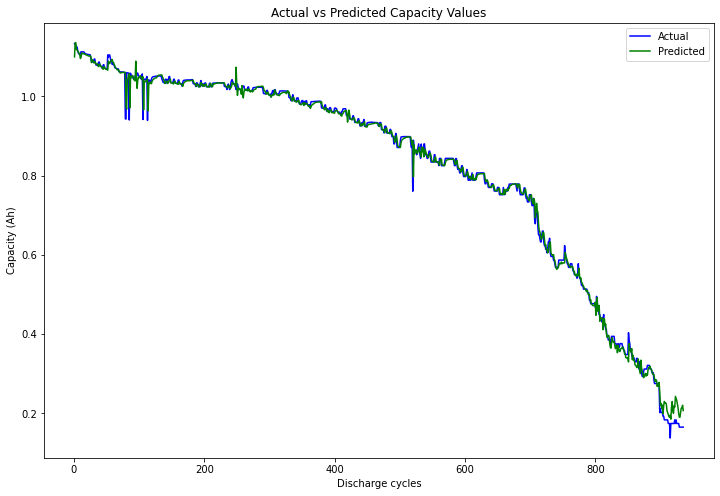

In [ ]:
# timer
start_time = timer()
tracemalloc.start()

test_name = 'CS2_36'
test_loss, Y_test, y_pred = test(best_model=best_model_B36,
                                 input_data=Input22Dim,
                                 y_battery=y_battery,
                                 test_name=test_name)

acc = accuracy(Y_test.cpu().detach().numpy(), y_pred.squeeze(-1).cpu().detach().numpy())
mae = mean_absolute_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy())
mse = sqrt(mean_squared_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy()))
print(f"Test Loss: {test_loss:.4f} | MAE: {mae:.4f} | MSE: {mse:.4f} | Accuracy: {acc:.2f}")

end_time = timer()
snapshot = tracemalloc.take_snapshot()

print_inference_time(start_time, end_time, device)
memory_stats(snapshot)
y_pred = y_pred.cpu().detach().numpy().squeeze()
fig, ax = plt.subplots(1, figsize=(12, 8))
color_list = ['b:', 'g--', 'r-.', 'c.']
y = list(range(1, len(y_pred)+1))
ax.plot(y, y_battery[test_name], 'b', label='Actual')
ax.plot(y, y_pred, 'g', label='Predicted')
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Actual vs Predicted Capacity Values')
plt.legend()

Test Loss: 0.0004 | MAE: 0.0133 | MSE: 0.0288 | Accuracy: 0.96
True RUL: 644 | Prediction RUL: 646 | RUL Error: -2
Inference time on cuda: 0.217 seconds
Allocated memory: 3670.3 KiB


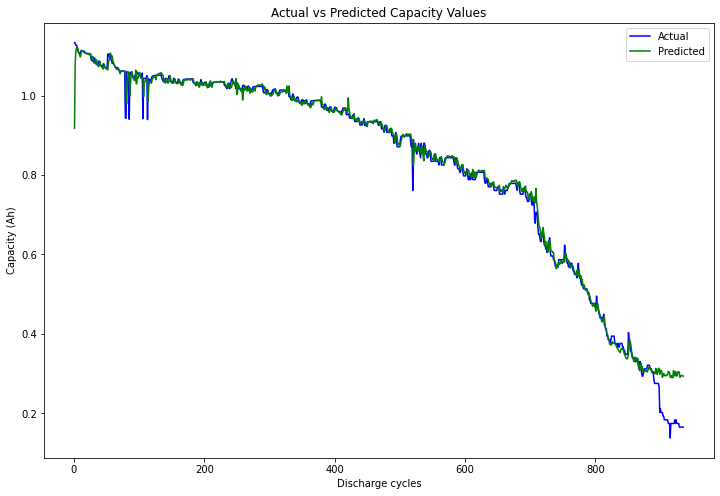

In [ ]:
# timer
start_time = timer()
tracemalloc.start()
Rated_Capacity = 1.1
test_name = 'CS2_36'
test_loss, Y_test, y_pred = test(best_model=model_2,
                                 input_data=Input22Dim,
                                 y_battery=y_battery,
                                 test_name=test_name)

acc = accuracy(Y_test.cpu().detach().numpy(), y_pred.squeeze(-1).cpu().detach().numpy())
mae = mean_absolute_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy())
mse = sqrt(mean_squared_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy()))
# Computing RUL Error
Threshold = 0.7 * Rated_Capacity
idx_true = (Y_test<Threshold).nonzero().squeeze()
RUL_true = idx_true[0][0]
if(torch.Tensor(Y_test[int(RUL_true + 1)])>Threshold):
    RUL_true = idx_true[1][0]

idx_pred = (y_pred<Threshold).nonzero().squeeze()  # search idx less than threshold
RUL_pred = idx_pred[0][0]                        # first entry is pred RUL
if(torch.Tensor(Y_test[int(RUL_pred + 1)])>Threshold):
        RUL_pred = idx_pred[1][0]
RUL_error = RUL_true - RUL_pred
print(f"Test Loss: {test_loss:.4f} | MAE: {mae:.4f} | MSE: {mse:.4f} | Accuracy: {acc:.2f}")
print(f"True RUL: {int(RUL_true)} | Prediction RUL: {int(RUL_pred)} | RUL Error: {int(RUL_error)}")

end_time = timer()
snapshot = tracemalloc.take_snapshot()

print_inference_time(start_time, end_time, device)
memory_stats(snapshot)
y_pred = y_pred.cpu().detach().numpy().squeeze()
fig, ax = plt.subplots(1, figsize=(12, 8))
color_list = ['b:', 'g--', 'r-.', 'c.']
y = list(range(1, len(y_pred)+1))
ax.plot(y, y_battery[test_name], 'b', label='Actual')
ax.plot(y, y_pred, 'g', label='Predicted')
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Actual vs Predicted Capacity Values')
plt.legend()

## Training Using Datasets CS2_35, CS2_36 and CS2_38 and Test on CS2_37

In [ ]:
from tqdm.auto import tqdm
import sys
torch.manual_seed(42)

input_size = 22
hidden_size = 10
output_size = 1
model_3 = RNNScratch(input_size=input_size, 
                     hidden_size=hidden_size, 
                     output_size=output_size)
model_3 = model_3.to(device)

loss_fn = nn.HuberLoss()
#loss_fn = nn.MSELoss()
learning_rate = 0.005
epochs = 1000
#weight_decay = 1e-4
optimizer = torch.optim.Adam(model_3.parameters(), lr=learning_rate) #, weight_decay=weight_decay)

In [ ]:
train_names = ['CS2_35', 'CS2_36', 'CS2_38']
test_name = 'CS2_37'
iterations = 1
total_loss, best_model_B37, min_val_loss_B37 = train(model_3, Input22Dim, y_battery, epochs, train_names, test_name, iterations)

Iteration: 0


  0%|          | 0/1000 [00:00<?, ?it/s]

Train Set: CS2_35 | Epoch: 0 | Train Loss: 0.387386 | Test Set: CS2_37 Test Loss: 0.339288
Train Set: CS2_36 | Epoch: 0 | Train Loss: 0.331787 | Test Set: CS2_37 Test Loss: 0.306188
Train Set: CS2_38 | Epoch: 0 | Train Loss: 0.311148 | Test Set: CS2_37 Test Loss: 0.283976
Train Set: CS2_35 | Epoch: 100 | Train Loss: 0.000426 | Test Set: CS2_37 Test Loss: 0.000433
Train Set: CS2_36 | Epoch: 100 | Train Loss: 0.000395 | Test Set: CS2_37 Test Loss: 0.000430
Train Set: CS2_38 | Epoch: 100 | Train Loss: 0.000475 | Test Set: CS2_37 Test Loss: 0.000429
Train Set: CS2_35 | Epoch: 200 | Train Loss: 0.000227 | Test Set: CS2_37 Test Loss: 0.000235
Train Set: CS2_36 | Epoch: 200 | Train Loss: 0.000251 | Test Set: CS2_37 Test Loss: 0.000235
Train Set: CS2_38 | Epoch: 200 | Train Loss: 0.000250 | Test Set: CS2_37 Test Loss: 0.000235
Train Set: CS2_35 | Epoch: 300 | Train Loss: 0.000148 | Test Set: CS2_37 Test Loss: 0.000156
Train Set: CS2_36 | Epoch: 300 | Train Loss: 0.000200 | Test Set: CS2_37 Tes

In [ ]:
train_names = ['CS2_35', 'CS2_36', 'CS2_38']
test_name = 'CS2_37'
iterations = 1
total_loss = trainv2(model_3, Input22Dim, y_battery, epochs, train_names, iterations)

Iteration: 0


  0%|          | 0/1000 [00:00<?, ?it/s]

Train Set: CS2_35 | Epoch: 0 | Train Loss: 0.387386 | Test Set: CS2_38 Test Loss: 0.345284
Train Set: CS2_36 | Epoch: 0 | Train Loss: 0.331787 | Test Set: CS2_38 Test Loss: 0.311148
Train Set: CS2_35 | Epoch: 100 | Train Loss: 0.000503 | Test Set: CS2_36 Test Loss: 0.000525
Train Set: CS2_38 | Epoch: 100 | Train Loss: 0.001191 | Test Set: CS2_36 Test Loss: 0.000676
Train Set: CS2_38 | Epoch: 200 | Train Loss: 0.000430 | Test Set: CS2_36 Test Loss: 0.000360
Train Set: CS2_35 | Epoch: 200 | Train Loss: 0.000388 | Test Set: CS2_36 Test Loss: 0.000373
Train Set: CS2_38 | Epoch: 300 | Train Loss: 0.000314 | Test Set: CS2_36 Test Loss: 0.000277
Train Set: CS2_35 | Epoch: 300 | Train Loss: 0.000282 | Test Set: CS2_36 Test Loss: 0.000283
Train Set: CS2_36 | Epoch: 400 | Train Loss: 0.000230 | Test Set: CS2_38 Test Loss: 0.000223
Train Set: CS2_35 | Epoch: 400 | Train Loss: 0.000200 | Test Set: CS2_38 Test Loss: 0.000225
Train Set: CS2_38 | Epoch: 500 | Train Loss: 0.000174 | Test Set: CS2_36 T

Test Loss: 0.0001 | MAE: 0.0074 | MSE: 0.0131 | Accuracy: 0.99
Inference time on cuda: 0.112 seconds
Allocated memory: 4129.2 KiB


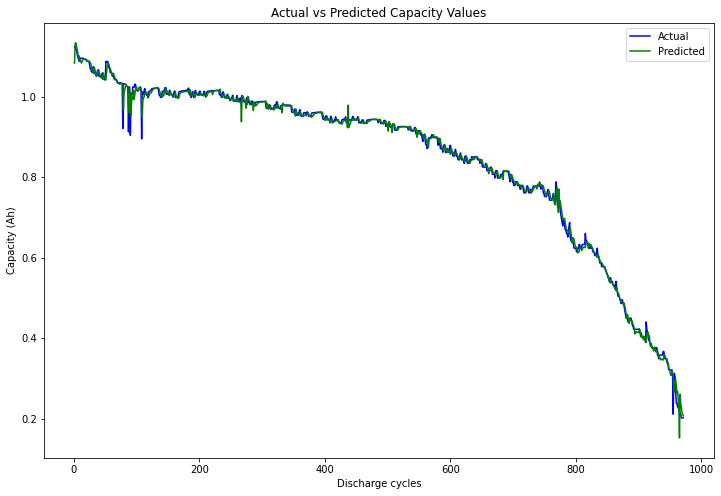

In [ ]:
# timer
start_time = timer()
tracemalloc.start()

test_name = 'CS2_37'
test_loss, Y_test, y_pred = test(best_model=best_model_B37,
                                 input_data=Input22Dim,
                                 y_battery=y_battery,
                                 test_name=test_name)

acc = accuracy(Y_test.cpu().detach().numpy(), y_pred.squeeze(-1).cpu().detach().numpy())
mae = mean_absolute_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy())
mse = sqrt(mean_squared_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy()))
print(f"Test Loss: {test_loss:.4f} | MAE: {mae:.4f} | MSE: {mse:.4f} | Accuracy: {acc:.2f}")

end_time = timer()
snapshot = tracemalloc.take_snapshot()

print_inference_time(start_time, end_time, device)
memory_stats(snapshot)
y_pred = y_pred.cpu().detach().numpy().squeeze()
fig, ax = plt.subplots(1, figsize=(12, 8))
color_list = ['b:', 'g--', 'r-.', 'c.']
y = list(range(1, len(y_pred)+1))
ax.plot(y, y_battery[test_name], 'b', label='Actual')
ax.plot(y, y_pred, 'g', label='Predicted')
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Actual vs Predicted Capacity Values')
plt.legend()

Test Loss: 0.0001 | MAE: 0.0086 | MSE: 0.0142 | Accuracy: 0.99
True RUL: 715 | Prediction RUL: 717 | RUL Error: -2
Inference time on cuda: 0.206 seconds
Allocated memory: 4892.5 KiB


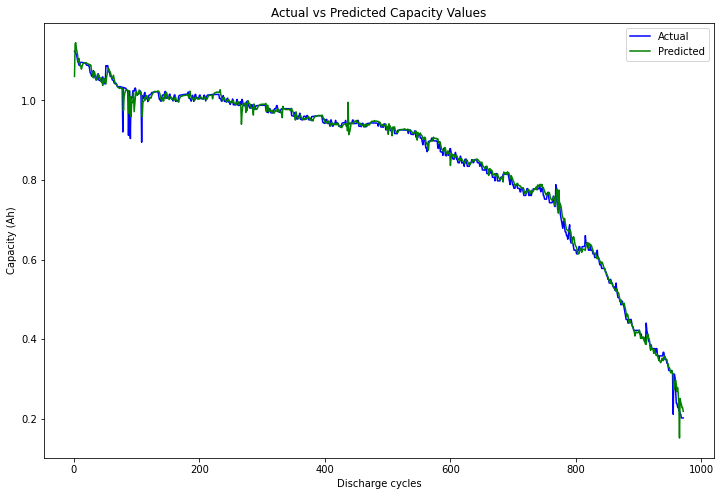

In [ ]:
# timer
start_time = timer()
tracemalloc.start()
Rated_Capacity = 1.1
test_name = 'CS2_37'
test_loss, Y_test, y_pred = test(best_model=model_3,
                                 input_data=Input22Dim,
                                 y_battery=y_battery,
                                 test_name=test_name)

acc = accuracy(Y_test.cpu().detach().numpy(), y_pred.squeeze(-1).cpu().detach().numpy())
mae = mean_absolute_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy())
mse = sqrt(mean_squared_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy()))
# Computing RUL Error
Threshold = 0.7 * Rated_Capacity
idx_true = (Y_test<Threshold).nonzero().squeeze()
RUL_true = idx_true[0][0]
if(torch.Tensor(Y_test[int(RUL_true + 1)])>Threshold):
    RUL_true = idx_true[1][0]

idx_pred = (y_pred<Threshold).nonzero().squeeze()  # search idx less than threshold
RUL_pred = idx_pred[0][0]                        # first entry is pred RUL
if(torch.Tensor(Y_test[int(RUL_pred + 1)])>Threshold):
        RUL_pred = idx_pred[1][0]
RUL_error = RUL_true - RUL_pred
print(f"Test Loss: {test_loss:.4f} | MAE: {mae:.4f} | MSE: {mse:.4f} | Accuracy: {acc:.2f}")
print(f"True RUL: {int(RUL_true)} | Prediction RUL: {int(RUL_pred)} | RUL Error: {int(RUL_error)}")

end_time = timer()
snapshot = tracemalloc.take_snapshot()

print_inference_time(start_time, end_time, device)
memory_stats(snapshot)
y_pred = y_pred.cpu().detach().numpy().squeeze()
fig, ax = plt.subplots(1, figsize=(12, 8))
color_list = ['b:', 'g--', 'r-.', 'c.']
y = list(range(1, len(y_pred)+1))
ax.plot(y, y_battery[test_name], 'b', label='Actual')
ax.plot(y, y_pred, 'g', label='Predicted')
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Actual vs Predicted Capacity Values')
plt.legend()

## Save `model.state_dict()`

In [ ]:
state_dicts = [best_model_B35.state_dict(), best_model_B36.state_dict(), best_model_B37.state_dict(), best_model_B38.state_dict()]

In [ ]:
state_dicts[0]

OrderedDict([('i2h.weight',
              tensor([[-1.1019e-01,  1.7166e-01, -2.5387e-02,  2.3004e-01, -3.0238e-03,
                        9.4044e-02, -4.2232e-02,  1.9888e-01,  2.7648e-01, -4.4736e-02,
                        3.3265e-01,  1.8151e-01,  2.9653e-01,  1.5793e-01,  2.2323e-01,
                        8.7704e-02,  2.8214e-01,  1.4597e-01,  2.9166e-02,  1.1304e-01,
                       -7.0395e-02,  2.4470e-01],
                      [ 1.3505e-03,  2.4546e-01, -7.2663e-02, -1.3042e-02,  3.2767e-02,
                       -4.3473e-02,  9.9424e-02, -1.4573e-01,  2.3774e-01, -1.0314e-01,
                        2.6053e-01,  1.2785e-01,  2.0095e-02,  2.0929e-01,  9.4853e-02,
                        1.9896e-01,  6.2473e-02,  9.1349e-02,  1.3262e-01,  1.4131e-02,
                        1.2983e-01,  5.6417e-01],
                      [ 7.1356e-02, -1.4493e-01,  7.1368e-02, -1.3553e-02,  5.6572e-02,
                       -1.8164e-01, -2.6274e-01, -1.3406e-01, -2.1521e-01,  1.23

In [ ]:
from pathlib import Path

# 1. Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAMES = ['RNNModelvB35.pth', 'RNNModelvB36.pth', 'RNNModelvB37.pth', 'RNNModelvB38.pth'] 
state_dicts = [best_model_B35.state_dict(), best_model_B36.state_dict(), best_model_B37.state_dict(), best_model_B38.state_dict()]
# 3. Save the model state dict 
for model_name, state_model in zip(MODEL_NAMES, state_dicts):
    MODEL_SAVE_PATH = MODEL_PATH / model_name
    print(f"Saving model to: {MODEL_SAVE_PATH}")
    torch.save(obj=state_model, # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/RNNModelvB35.pth
Saving model to: models/RNNModelvB36.pth
Saving model to: models/RNNModelvB37.pth
Saving model to: models/RNNModelvB38.pth


In [ ]:
from pathlib import Path

# 1. Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAMES = ['RNNModelvB35.pth', 'RNNModelvB36.pth', 'RNNModelvB37.pth', 'RNNModelvB38.pth'] 
state_dicts = [model_1.state_dict(), model_2.state_dict(), model_3.state_dict(), model_0.state_dict()]
# 3. Save the model state dict 
for model_name, state_model in zip(MODEL_NAMES, state_dicts):
    MODEL_SAVE_PATH = MODEL_PATH / model_name
    print(f"Saving model to: {MODEL_SAVE_PATH}")
    torch.save(obj=state_model, # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/RNNModelvB35.pth
Saving model to: models/RNNModelvB36.pth
Saving model to: models/RNNModelvB37.pth
Saving model to: models/RNNModelvB38.pth


## Load saved models

In [ ]:
MODEL_SAVE_PATH = 'models/RNNModelvB38.pth'

# Instantiate a new instance of our model (this will be instantiated with random weights)
torch.manual_seed(42)
input_size = 22
hidden_size = 10
output_size = 1
loadedmodelvB38 = RNNScratch(input_size=input_size,
                             hidden_size=hidden_size,
                             output_size=output_size)

# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
loadedmodelvB38.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
loadedmodelvB38.to(device) 

RNNScratch(
  (i2h): Linear(in_features=22, out_features=10, bias=False)
  (h2h): Linear(in_features=10, out_features=10, bias=True)
  (h2o): Linear(in_features=10, out_features=1, bias=True)
)

Test Loss: 0.0001 | MAE: 0.0089 | MSE: 0.0158 | Accuracy: 0.99
Inference time on cuda: 0.148 seconds
Allocated memory: 5352.6 KiB


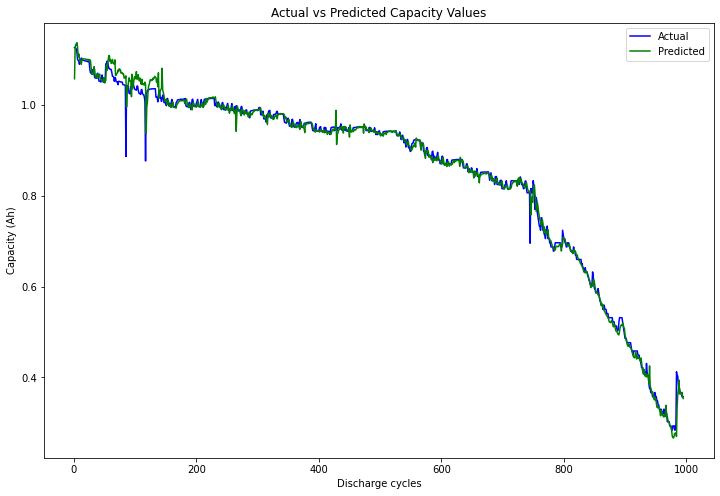

In [ ]:
# timer
start_time = timer()
tracemalloc.start()

test_name = 'CS2_38'
test_loss, Y_test, y_pred = test(best_model=loadedmodelvB38,
                                 input_data=Input22Dim,
                                 y_battery=y_battery,
                                 test_name=test_name)

acc = accuracy(Y_test.cpu().detach().numpy(), y_pred.squeeze(-1).cpu().detach().numpy())
mae = mean_absolute_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy())
mse = sqrt(mean_squared_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy()))
print(f"Test Loss: {test_loss:.4f} | MAE: {mae:.4f} | MSE: {mse:.4f} | Accuracy: {acc:.2f}")

end_time = timer()
snapshot = tracemalloc.take_snapshot()

print_inference_time(start_time, end_time, device)
memory_stats(snapshot)
y_pred = y_pred.cpu().detach().numpy().squeeze()
fig, ax = plt.subplots(1, figsize=(12, 8))
color_list = ['b:', 'g--', 'r-.', 'c.']
y = list(range(1, len(y_pred)+1))
ax.plot(y, y_battery[test_name], 'b', label='Actual')
ax.plot(y, y_pred, 'g', label='Predicted')
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Actual vs Predicted Capacity Values')
plt.legend()

## Inference 

### if the file is in `.zip`

Load Dataset CS2_38/*.xlsx
Load /content/data/calce/CS2_38/CS2_38_8_19_10.xlsx ...
Load /content/data/calce/CS2_38/CS2_38_1_18_11.xlsx ...
Load /content/data/calce/CS2_38/CS2_38_2_4_11.xlsx ...
Load /content/data/calce/CS2_38/CS2_38_12_20_10.xlsx ...
Load /content/data/calce/CS2_38/CS2_38_12_06_10.xlsx ...
Load /content/data/calce/CS2_38/CS2_38_1_28_11.xlsx ...
Load /content/data/calce/CS2_38/CS2_38_9_7_10.xlsx ...
Load /content/data/calce/CS2_38/CS2_38_10_05_10.xlsx ...
Load /content/data/calce/CS2_38/CS2_38_10_04_10.xlsx ...
Load /content/data/calce/CS2_38/CS2_38_1_10_11.xlsx ...
Load /content/data/calce/CS2_38/CS2_38_9_21_10.xlsx ...
Load /content/data/calce/CS2_38/CS2_38_2_10_11.xlsx ...
Load /content/data/calce/CS2_38/CS2_38_11_08_10.xlsx ...
Load /content/data/calce/CS2_38/CS2_38_10_14_10.xlsx ...
Load /content/data/calce/CS2_38/CS2_38_12_13_10.xlsx ...
Load /content/data/calce/CS2_38/CS2_38_8_17_10.xlsx ...
Load /content/data/calce/CS2_38/CS2_38_11_24_10.xlsx ...
Load /content/d

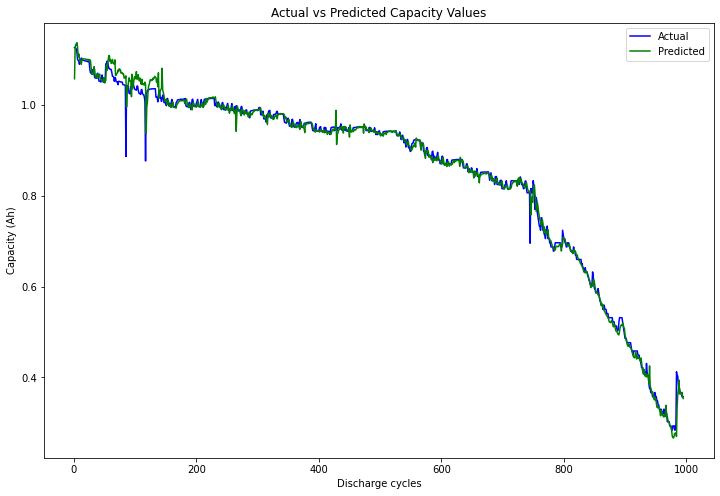

In [ ]:
# Whole python code for inference
# Import all modules
import numpy as np
import random
import math
import os
import sys
import copy
import shutil
import zipfile
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import pandas as pd
import glob
import linecache
import tracemalloc
%matplotlib inline

from torch import optim
from math import sqrt
from datetime import datetime
from timeit import default_timer as timer
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from pathlib import Path
from collections import Counter

# drop outliers to get indexes
def drop_outlier(array, count, bins):
    index = []
    out_range = np.arange(1, count, bins)
    for i in out_range[:-1]:
        array_lim = array[i : i + bins]
        sigma = np.std(array_lim)
        mean = np.mean(array_lim)
        th_max, th_min = mean + sigma*2, mean - sigma*2
        idx = np.where((array_lim < th_max) & (array_lim > th_min))
        idx = idx[0] + i
        index.extend(list(idx))
    return np.array(index)

def dataprocessing(dir_path, test_name):
    battery = {}
    charge_profile = {}
    print('Load Dataset ' + test_name + '/*.xlsx')
    path = glob.glob(dir_path + test_name + '/*.xlsx')
    dates = []
    for p in path:
        df = pd.read_excel(p, sheet_name=1)
        #print('Load ' + str(p) + ' ...')
        dates.append(df['Date_Time'][0])
    idx = np.argsort(dates)
    path_sorted = np.array(path)[idx]

    count = 0
    discharge_capacities = []
    internal_resistance = []
    dict1 = {}
    volt = []       # list for voltage values
    amp = []        # list for current values
    for p in path_sorted:
        df = pd.read_excel(p, sheet_name=1)
        #print('Load ' + str(p) + ' ...')
        cycles = list(set(df['Cycle_Index']))
        for c in cycles:
            df_lim = df[df['Cycle_Index'] == c]

            # Charging Parameters
            df_c = df_lim[(df_lim['Step_Index'] == 2)|(df_lim['Step_Index'] == 4)]
            c_v = np.array(df_c['Voltage(V)'])
            c_c = np.array(df_c['Current(A)'])
            
            volt.append(c_v)
            amp.append(c_c)

            # Discharging Parameters
            df_d = df_lim[df_lim['Step_Index'] == 7]
            d_v = df_d['Voltage(V)']
            d_c = df_d['Current(A)']
            d_t = df_d['Test_Time(s)']
            d_im = df_d['Internal_Resistance(Ohm)']

            if(len(list(d_c)) != 0):
                time_diff = np.diff(list(d_t))
                d_c = np.array(list(d_c))[1:]
                discharge_capacity = time_diff*d_c/3600     # Q = A*h
                discharge_capacity = [np.sum(discharge_capacity[:n]) for n in range(discharge_capacity.shape[0])]
                discharge_capacities.append(-1*discharge_capacity[-1])

                internal_resistance.append(np.mean(np.array(d_im)))
                count += 1
    
    discharge_capacities = np.array(discharge_capacities)
    internal_resistance = np.array(internal_resistance)

    idx = drop_outlier(discharge_capacities, count, 40)
    df_result = pd.DataFrame({'cycle':np.linspace(1,idx.shape[0],idx.shape[0]),
                              'capacity':discharge_capacities[idx],
                              'resistance':internal_resistance[idx]})
    volt = [volt[idx[i]] for i in range(len(idx))]
    amp = [amp[idx[i]] for i in range(len(idx))]
    d1['Voltage'], d1['Current'] = volt, amp
                              
    battery[test_name] = df_result
    charge_profile[test_name] = d1
    return battery, charge_profile

def Normalize_Data(charge_profile, test_name, volt_max, volt_min, current_max, current_min):
    params = ['Voltage', 'Current']

    df = copy.deepcopy(charge_profile)
    # normalize voltage
    for i in range(len(df[test_name][params[0]])):
        for j in range(len(df[test_name][params[0]][i])):
            df[test_name][params[0]][i][j] = (df[test_name][params[0]][i][j] - volt_min) / (volt_max - volt_min)
    # normalize currents
    for i in range(len(df[test_name][params[1]])):
        for j in range(len(df[test_name][params[1]][i])):
            df[test_name][params[1]][i][j] = (df[test_name][params[1]][i][j] - current_min) / (current_max - current_min)

    return df

# Systematic sampling for voltages and currents
def SystematicSampling(df, sample_size):
    random.seed(1)
    population = len(df)
    step = math.ceil(population/sample_size)
    selected_index = np.arange(0, population, step)
    if len(selected_index) < 10:
        len_list = list(range(0, population))
        selected_index = random.sample(len_list, sample_size)
        selected_index.sort()
    samples = []
    for i in range(len(selected_index)):
        selected_sample = df[selected_index[i]]
        samples.append(selected_sample)
    return samples

def ChargeProfileSampling(df, test_name, sample_size):
    parameters = ['Voltage', 'Current']
    sampled_profile = {}
    d1 = {}
    for params in parameters:
        samples = []
        for i in range(len(df[test_name][params])):
            sampled_list = SystematicSampling(df=df[test_name][params][i],
                                              sample_size=sample_size)
            samples.append(sampled_list)
        d1[params] = samples
    sampled_profile[test_name] = d1
    return sampled_profile

def Normalize_CapRes(battery, test_name, cap_max, cap_min, res_max, res_min):
    df = copy.deepcopy(battery)
    params = ['capacity', 'resistance']

    # normalizing capacity    
    for i in range(len(df[test_name][params[0]])):
        df[test_name][params[0]][i] = (df[test_name][params[0]][i] - cap_min) / (cap_max - cap_min)
    # normalizing internal resistance
    for i in range(len(df[test_name][params[1]])):
        df[test_name][params[1]][i] = (df[test_name][params[1]][i] - res_min) / (res_max - res_min)
    
    return df

def concatCPandCap(sampled_profile, normalized, test_name):
    input = {}
    V = sampled_profile[test_name]['Voltage']
    V.pop(-1)
    C = sampled_profile[test_name]['Current']
    C.pop(-1)
    IR = list(normalized[test_name]['resistance'])
    IR.pop(-1)
    Cap = list(normalized[test_name]['capacity'])
    Cap.pop(-1)

    inputs = []
    for i in range(len(V)):
        one_row = [*V[i], *C[i], IR[i], Cap[i]]
        inputs.append(one_row)
    
    input[test_name] = inputs
    
    return input

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.i2h = nn.Linear(input_size, hidden_size, bias=False)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden_state):
        x = self.i2h(x)
        hidden_state = self.h2h(hidden_state)
        hidden_state = F.relu(x + hidden_state)
        out = self.h2o(hidden_state)
        return out, hidden_state

    def init_zero_hidden(self):
        return torch.zeros(1, self.hidden_size)

# Compute for accuracy
def accuracy(y_test, y_pred):
    error = np.abs(y_pred-y_test)/y_test
    acc = np.ones_like(error) - error
    acc = np.sum(acc)/len(y_pred)
    return float(acc)

# Print Inference Time
def print_inference_time(start: float,
                         end: float,
                         device: torch.device = None):
    
    """
    Prints difference between start and end time
    """

    total_time = end - start
    print(f"Inference time on {device}: {total_time:.3f} seconds")

    return total_time

# Print Memory Usage

def memory_stats(snapshot, key_type='lineno'):
    snapshot = snapshot.filter_traces((
        tracemalloc.Filter(False, "<frozen importlib._bootstrap>"),
        tracemalloc.Filter(False, "<unknown>"),
    ))
    usage_stat = snapshot.statistics(key_type)

    total = sum(stat.size for stat in usage_stat)

    print("Allocated memory: %.1f KiB" % (total / 1024))

def test(loaded_model, input, y_battery, test_name):
    loss_fn = nn.HuberLoss()
    loaded_model.eval()
    with torch.inference_mode():
        x_test = torch.tensor(input[test_name], dtype=torch.float32)
        y_test = torch.tensor(y_battery[test_name], dtype=torch.float32).unsqueeze(1)
        X_test = x_test.to(device)
        Y_test = y_test.to(device)
        hidden = loaded_model.init_zero_hidden()
        hidden = hidden.to(device)
        test_out = []
        for i in range(X_test.size()[0]):
            # 1. Forward Pass
            test_output, hidden = loaded_model(X_test[i], hidden)
            test_out.append(test_output)
                
        y_pred = torch.stack(test_out).to(device)
        # 2. Calculate Loss
        test_loss = loss_fn(y_pred.squeeze(-1), Y_test)
    return test_loss, Y_test, y_pred


if __name__ == "__main__":
    # timer
    start_time = timer()
    tracemalloc.start()
    torch.manual_seed(42)
    # put the path where the dataset is stored
    #batt_zippath = 'data/CS2_35.zip'
    #batt_zippath = 'data/CS2_36.zip'
    #batt_zippath = 'data/CS2_37.zip'
    batt_zippath = Path("data/CS2_38.zip")
    
    # create inference directory
    inference_dir = Path("inference/calce")
    inference_dir.mkdir(parents=True, exist_ok=True)
    
    with zipfile.ZipFile(batt_zippath, "r") as zip_ref:
        zip_ref.extractall(inference_dir)
    
    test_name = 'CS2_38'
    dir_path = '/content/inference/calce/'
    model_save_path = 'models/RNNModelvB38.pth'

    # hyperparameters
    volt_max = 4.2155985832214355
    volt_min = 3.419985055923462
    current_max = 1.1539158821105957
    current_min = -0.6620013117790222
    cap_max = 1.1338066110520781
    cap_min = 0.13754795953533758
    res_max = 0.18449176847934723
    res_min = 0.0820472314953804
    sample_size = 10
    input_size = 22
    hidden_size = 10
    output_size = 1

    # reading files
    battery, charge_profile = dataprocessing(dir_path, test_name)

    # normalizing charge_profile
    df = Normalize_Data(charge_profile, test_name, volt_max, volt_min, current_max, current_min)

    # sampling charge_profile
    sampled_profile = ChargeProfileSampling(df, test_name, sample_size)

    # normalize capacity & internal resistance
    normalized_capres = Normalize_CapRes(battery, test_name, cap_max, cap_min, res_max, res_min)

    # join everything together to create a 22 dimension input
    input = concatCPandCap(sampled_profile, normalized_capres, test_name)

    # test outputs
    y_battery = {}
    df_cap = copy.deepcopy(battery[test_name]['capacity'])
    df_cap = list(df_cap)
    df_cap.pop(0)                                 # remove first element
    y_battery[test_name] = df_cap

    # load saved model
    # Instantiate a new instance of our model (this will be instantiated with random weights
    loadedmodelvB38 = RNNModel(input_size=input_size,
                               hidden_size=hidden_size,
                               output_size=output_size)

    # Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
    loadedmodelvB38.load_state_dict(torch.load(f=model_save_path))
    loadedmodelvB38.to(device)

    # get predictions
    test_loss, Y_test, y_pred = test(loaded_model=loadedmodelvB38,
                                     input=input,
                                     y_battery=y_battery,
                                     test_name=test_name)

    acc = accuracy(Y_test.cpu().detach().numpy(), y_pred.squeeze(-1).cpu().detach().numpy())
    mae = mean_absolute_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy())
    mse = sqrt(mean_squared_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy()))
    print(f"Test Loss: {test_loss:.4f} | MAE: {mae:.4f} | MSE: {mse:.4f} | Accuracy: {acc:.2f}")

    end_time = timer()
    snapshot = tracemalloc.take_snapshot()

    print_inference_time(start_time, end_time, device)
    memory_stats(snapshot)

    y_pred = y_pred.cpu().detach().numpy().squeeze()
    fig, ax = plt.subplots(1, figsize=(12, 8))
    color_list = ['b:', 'g--', 'r-.', 'c.']
    y = list(range(1, len(y_pred)+1))
    ax.plot(y, y_battery[test_name], 'b', label='Actual')
    ax.plot(y, y_pred, 'g', label='Predicted')
    ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Actual vs Predicted Capacity Values')
    plt.legend()

### Inference on CALCE CS2_38

Load Dataset CS2_38/*.xlsx
Load /content/inference/calce/CS2_38/CS2_38_8_17_10.xlsx ...
Load /content/inference/calce/CS2_38/CS2_38_8_18_10.xlsx ...
Load /content/inference/calce/CS2_38/CS2_38_8_19_10.xlsx ...
Load /content/inference/calce/CS2_38/CS2_38_8_30_10.xlsx ...
Load /content/inference/calce/CS2_38/CS2_38_9_7_10.xlsx ...
Load /content/inference/calce/CS2_38/CS2_38_9_14_10.xlsx ...
Load /content/inference/calce/CS2_38/CS2_38_9_21_10.xlsx ...
Load /content/inference/calce/CS2_38/CS2_38_9_28_10.xlsx ...
Load /content/inference/calce/CS2_38/CS2_38_10_04_10.xlsx ...
Load /content/inference/calce/CS2_38/CS2_38_10_05_10.xlsx ...
Load /content/inference/calce/CS2_38/CS2_38_10_14_10.xlsx ...
Load /content/inference/calce/CS2_38/CS2_38_10_21_10.xlsx ...
Load /content/inference/calce/CS2_38/CS2_38_10_28_10.xlsx ...
Load /content/inference/calce/CS2_38/CS2_38_11_01_10.xlsx ...
Load /content/inference/calce/CS2_38/CS2_38_11_08_10.xlsx ...
Load /content/inference/calce/CS2_38/CS2_38_11_15_10

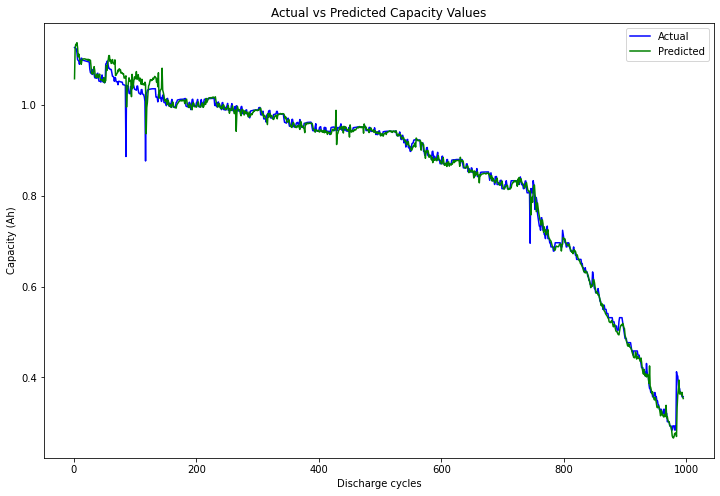

In [ ]:
# Whole python code for inference
# Import all modules
import numpy as np
import random
import math
import os
import sys
import copy
import shutil
import zipfile
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import pandas as pd
import glob
import linecache
import tracemalloc
%matplotlib inline

from torch import optim
from math import sqrt
from datetime import datetime
from timeit import default_timer as timer
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from pathlib import Path
from collections import Counter

# drop outliers to get indexes
def drop_outlier(array, count, bins):
    index = []
    out_range = np.arange(1, count, bins)
    for i in out_range[:-1]:
        array_lim = array[i : i + bins]
        sigma = np.std(array_lim)
        mean = np.mean(array_lim)
        th_max, th_min = mean + sigma*2, mean - sigma*2
        idx = np.where((array_lim < th_max) & (array_lim > th_min))
        idx = idx[0] + i
        index.extend(list(idx))
    return np.array(index)

def dataprocessing(dir_path, test_name):
    battery = {}
    charge_profile = {}
    path = glob.glob(dir_path + test_name + '/*.xlsx')
    print('Load Dataset ' + test_name + '/*.xlsx')
    dates = []
    for p in path:
        file_path = p.split("/")[-1].split(".")[0].split("_")[-3:]
        date_str = str(file_path[0] + "/" + file_path[1] + "/" + file_path[2]) 
        date = datetime.strptime(date_str, '%m/%d/%y')
        dates.append(date)
        '''
        df = pd.read_excel(p, sheet_name=1)
        #print('Load ' + str(p) + ' ...')
        dates.append(df['Date_Time'][0])
        '''
    idx = np.argsort(dates)
    path_sorted = np.array(path)[idx]

    count = 0
    discharge_capacities = []
    internal_resistance = []
    dict1 = {}
    volt = []       # list for voltage values
    amp = []        # list for current values
    for p in path_sorted:
        df = pd.read_excel(p, sheet_name=1)
        print('Load ' + str(p) + ' ...')
        cycles = list(set(df['Cycle_Index']))
        for c in cycles:
            df_lim = df[df['Cycle_Index'] == c]

            # Charging Parameters
            df_c = df_lim[(df_lim['Step_Index'] == 2)|(df_lim['Step_Index'] == 4)]
            c_v = np.array(df_c['Voltage(V)'])
            c_c = np.array(df_c['Current(A)'])
            
            volt.append(c_v)
            amp.append(c_c)

            # Discharging Parameters
            df_d = df_lim[df_lim['Step_Index'] == 7]
            d_v = df_d['Voltage(V)']
            d_c = df_d['Current(A)']
            d_t = df_d['Test_Time(s)']
            d_im = df_d['Internal_Resistance(Ohm)']

            if(len(list(d_c)) != 0):
                time_diff = np.diff(list(d_t))
                d_c = np.array(list(d_c))[1:]
                discharge_capacity = time_diff*d_c/3600     # Q = A*h
                discharge_capacity = [np.sum(discharge_capacity[:n]) for n in range(discharge_capacity.shape[0])]
                discharge_capacities.append(-1*discharge_capacity[-1])

                internal_resistance.append(np.mean(np.array(d_im)))
                count += 1
    
    discharge_capacities = np.array(discharge_capacities)
    internal_resistance = np.array(internal_resistance)

    idx = drop_outlier(discharge_capacities, count, 40)
    df_result = pd.DataFrame({'cycle':np.linspace(1,idx.shape[0],idx.shape[0]),
                              'capacity':discharge_capacities[idx],
                              'resistance':internal_resistance[idx]})
    volt = [volt[idx[i]] for i in range(len(idx))]
    amp = [amp[idx[i]] for i in range(len(idx))]
    d1['Voltage'], d1['Current'] = volt, amp
                              
    battery[test_name] = df_result
    charge_profile[test_name] = d1
    return battery, charge_profile

def Normalize_Data(charge_profile, test_name, volt_max, volt_min, current_max, current_min):
    params = ['Voltage', 'Current']

    df = copy.deepcopy(charge_profile)
    # normalize voltage
    for i in range(len(df[test_name][params[0]])):
        for j in range(len(df[test_name][params[0]][i])):
            df[test_name][params[0]][i][j] = (df[test_name][params[0]][i][j] - volt_min) / (volt_max - volt_min)
    # normalize currents
    for i in range(len(df[test_name][params[1]])):
        for j in range(len(df[test_name][params[1]][i])):
            df[test_name][params[1]][i][j] = (df[test_name][params[1]][i][j] - current_min) / (current_max - current_min)

    return df

# Systematic sampling for voltages and currents
def SystematicSampling(df, sample_size):
    random.seed(1)
    population = len(df)
    step = math.ceil(population/sample_size)
    selected_index = np.arange(0, population, step)
    if len(selected_index) < 10:
        len_list = list(range(0, population))
        selected_index = random.sample(len_list, sample_size)
        selected_index.sort()
    samples = []
    for i in range(len(selected_index)):
        selected_sample = df[selected_index[i]]
        samples.append(selected_sample)
    return samples

def ChargeProfileSampling(df, test_name, sample_size):
    parameters = ['Voltage', 'Current']
    sampled_profile = {}
    d1 = {}
    for params in parameters:
        samples = []
        for i in range(len(df[test_name][params])):
            sampled_list = SystematicSampling(df=df[test_name][params][i],
                                              sample_size=sample_size)
            samples.append(sampled_list)
        d1[params] = samples
    sampled_profile[test_name] = d1
    return sampled_profile

def Normalize_CapRes(battery, test_name, cap_max, cap_min, res_max, res_min):
    df = copy.deepcopy(battery)
    params = ['capacity', 'resistance']

    # normalizing capacity    
    for i in range(len(df[test_name][params[0]])):
        df[test_name][params[0]][i] = (df[test_name][params[0]][i] - cap_min) / (cap_max - cap_min)
    # normalizing internal resistance
    for i in range(len(df[test_name][params[1]])):
        df[test_name][params[1]][i] = (df[test_name][params[1]][i] - res_min) / (res_max - res_min)
    
    return df

def concatCPandCap(sampled_profile, normalized, test_name):
    input = {}
    V = sampled_profile[test_name]['Voltage']
    V.pop(-1)
    C = sampled_profile[test_name]['Current']
    C.pop(-1)
    IR = list(normalized[test_name]['resistance'])
    IR.pop(-1)
    Cap = list(normalized[test_name]['capacity'])
    Cap.pop(-1)

    inputs = []
    for i in range(len(V)):
        one_row = [*V[i], *C[i], IR[i], Cap[i]]
        inputs.append(one_row)
    
    input[test_name] = inputs
    
    return input

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.i2h = nn.Linear(input_size, hidden_size, bias=False)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden_state):
        x = self.i2h(x)
        hidden_state = self.h2h(hidden_state)
        hidden_state = F.relu(x + hidden_state)
        out = self.h2o(hidden_state)
        return out, hidden_state

    def init_zero_hidden(self):
        return torch.zeros(1, self.hidden_size)

# Compute for accuracy
def accuracy(y_test, y_pred):
    error = np.abs(y_pred-y_test)/y_test
    acc = np.ones_like(error) - error
    acc = np.sum(acc)/len(y_pred)
    return float(acc)

# Print Inference Time
def print_inference_time(start: float,
                         end: float,
                         device: torch.device = None):
    
    """
    Prints difference between start and end time
    """

    total_time = end - start
    print(f"Inference time on {device}: {total_time:.3f} seconds")

    return total_time

# Print Memory Usage

def memory_stats(snapshot, key_type='lineno'):
    snapshot = snapshot.filter_traces((
        tracemalloc.Filter(False, "<frozen importlib._bootstrap>"),
        tracemalloc.Filter(False, "<unknown>"),
    ))
    usage_stat = snapshot.statistics(key_type)

    total = sum(stat.size for stat in usage_stat)

    print("Allocated memory: %.1f KiB" % (total / 1024))

def test(loaded_model, input, y_battery, test_name):
    loss_fn = nn.HuberLoss()
    loaded_model.eval()
    with torch.inference_mode():
        x_test = torch.tensor(input[test_name], dtype=torch.float32)
        y_test = torch.tensor(y_battery[test_name], dtype=torch.float32).unsqueeze(1)
        X_test = x_test.to(device)
        Y_test = y_test.to(device)
        hidden = loaded_model.init_zero_hidden()
        hidden = hidden.to(device)
        test_out = []
        for i in range(X_test.size()[0]):
            # 1. Forward Pass
            test_output, hidden = loaded_model(X_test[i], hidden)
            test_out.append(test_output)
                
        y_pred = torch.stack(test_out).to(device)
        # 2. Calculate Loss
        test_loss = loss_fn(y_pred.squeeze(-1), Y_test)
    return test_loss, Y_test, y_pred


if __name__ == "__main__":
    # timer
    start_time = timer()
    tracemalloc.start()
    torch.manual_seed(42)
    # put the path where the dataset is stored
    #batt_zippath = 'data/CS2_35.zip'
    #batt_zippath = 'data/CS2_36.zip'
    #batt_zippath = 'data/CS2_37.zip'
    batt_zippath = Path("data/CS2_38.zip")
    
    # create inference directory
    inference_dir = Path("inference/calce")
    inference_dir.mkdir(parents=True, exist_ok=True)
    
    with zipfile.ZipFile(batt_zippath, "r") as zip_ref:
        zip_ref.extractall(inference_dir)
    
    #test_name = 'CS2_35'
    #test_name = 'CS2_36'
    #test_name = 'CS2_37'
    test_name = 'CS2_38'
    dir_path = '/content/inference/calce/'
    #model_save_path = 'models/RNNModelvB35.pth'
    #model_save_path = 'models/RNNModelvB36.pth'
    #model_save_path = 'models/RNNModelvB37.pth'
    model_save_path = 'models/RNNModelvB38.pth'

    # hyperparameters
    volt_max = 4.2155985832214355
    volt_min = 3.419985055923462
    current_max = 1.1539158821105957
    current_min = -0.6620013117790222
    cap_max = 1.1338066110520781
    cap_min = 0.13754795953533758
    res_max = 0.18449176847934723
    res_min = 0.0820472314953804
    sample_size = 10
    input_size = 22
    hidden_size = 10
    output_size = 1

    # reading files
    battery, charge_profile = dataprocessing(dir_path, test_name)

    # normalizing charge_profile
    df = Normalize_Data(charge_profile, test_name, volt_max, volt_min, current_max, current_min)

    # sampling charge_profile
    sampled_profile = ChargeProfileSampling(df, test_name, sample_size)

    # normalize capacity & internal resistance
    normalized_capres = Normalize_CapRes(battery, test_name, cap_max, cap_min, res_max, res_min)

    # join everything together to create a 22 dimension input
    input = concatCPandCap(sampled_profile, normalized_capres, test_name)

    # test outputs
    y_battery = {}
    df_cap = copy.deepcopy(battery[test_name]['capacity'])
    df_cap = list(df_cap)
    df_cap.pop(0)                                 # remove first element
    y_battery[test_name] = df_cap

    # load saved model
    # Instantiate a new instance of our model (this will be instantiated with random weights
    loadedmodelvB38 = RNNModel(input_size=input_size,
                               hidden_size=hidden_size,
                               output_size=output_size)

    # Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
    loadedmodelvB38.load_state_dict(torch.load(f=model_save_path))
    loadedmodelvB38.to(device)

    # get predictions
    test_loss, Y_test, y_pred = test(loaded_model=loadedmodelvB38,
                                     input=input,
                                     y_battery=y_battery,
                                     test_name=test_name)

    acc = accuracy(Y_test.cpu().detach().numpy(), y_pred.squeeze(-1).cpu().detach().numpy())
    mae = mean_absolute_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy())
    mse = sqrt(mean_squared_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy()))
    print(f"Test Loss: {test_loss:.4f} | MAE: {mae:.4f} | MSE: {mse:.4f} | Accuracy: {acc:.2f}")

    end_time = timer()
    snapshot = tracemalloc.take_snapshot()

    print_inference_time(start_time, end_time, device)
    memory_stats(snapshot)

    y_pred = y_pred.cpu().detach().numpy().squeeze()
    fig, ax = plt.subplots(1, figsize=(12, 8))
    color_list = ['b:', 'g--', 'r-.', 'c.']
    y = list(range(1, len(y_pred)+1))
    ax.plot(y, y_battery[test_name], 'b', label='Actual')
    ax.plot(y, y_pred, 'g', label='Predicted')
    ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Actual vs Predicted Capacity Values')
    plt.legend()

### Inference on CALCE CS2_35

Load Dataset CS2_35/*.xlsx
Load /content/inference/calce/CS2_35/CS2_35_8_17_10.xlsx ...
Load /content/inference/calce/CS2_35/CS2_35_8_18_10.xlsx ...
Load /content/inference/calce/CS2_35/CS2_35_8_19_10.xlsx ...
Load /content/inference/calce/CS2_35/CS2_35_8_30_10.xlsx ...
Load /content/inference/calce/CS2_35/CS2_35_9_7_10.xlsx ...
Load /content/inference/calce/CS2_35/CS2_35_9_8_10.xlsx ...
Load /content/inference/calce/CS2_35/CS2_35_9_21_10.xlsx ...
Load /content/inference/calce/CS2_35/CS2_35_9_30_10.xlsx ...
Load /content/inference/calce/CS2_35/CS2_35_10_15_10.xlsx ...
Load /content/inference/calce/CS2_35/CS2_35_10_22_10.xlsx ...
Load /content/inference/calce/CS2_35/CS2_35_10_29_10.xlsx ...
Load /content/inference/calce/CS2_35/CS2_35_11_01_10.xlsx ...
Load /content/inference/calce/CS2_35/CS2_35_11_08_10.xlsx ...
Load /content/inference/calce/CS2_35/CS2_35_11_23_10.xlsx ...
Load /content/inference/calce/CS2_35/CS2_35_11_24_10.xlsx ...
Load /content/inference/calce/CS2_35/CS2_35_12_06_10.

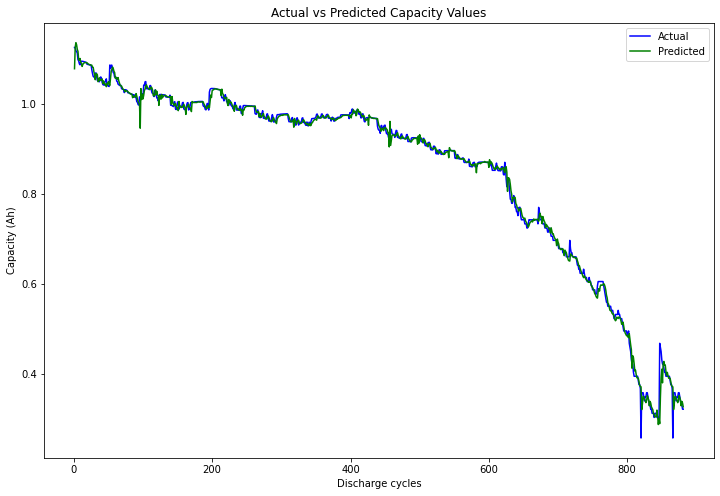

In [ ]:
# Whole python code for inference
# Import all modules
import numpy as np
import random
import math
import os
import sys
import copy
import shutil
import zipfile
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import pandas as pd
import glob
import linecache
import tracemalloc
%matplotlib inline

from torch import optim
from math import sqrt
from datetime import datetime
from timeit import default_timer as timer
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from pathlib import Path
from collections import Counter

# drop outliers to get indexes
def drop_outlier(array, count, bins):
    index = []
    out_range = np.arange(1, count, bins)
    for i in out_range[:-1]:
        array_lim = array[i : i + bins]
        sigma = np.std(array_lim)
        mean = np.mean(array_lim)
        th_max, th_min = mean + sigma*2, mean - sigma*2
        idx = np.where((array_lim < th_max) & (array_lim > th_min))
        idx = idx[0] + i
        index.extend(list(idx))
    return np.array(index)

def dataprocessing(dir_path, test_name):
    battery = {}
    charge_profile = {}
    path = glob.glob(dir_path + test_name + '/*.xlsx')
    print('Load Dataset ' + test_name + '/*.xlsx')
    dates = []
    for p in path:
        file_path = p.split("/")[-1].split(".")[0].split("_")[-3:]
        date_str = str(file_path[0] + "/" + file_path[1] + "/" + file_path[2]) 
        date = datetime.strptime(date_str, '%m/%d/%y')
        dates.append(date)
        '''
        df = pd.read_excel(p, sheet_name=1)
        #print('Load ' + str(p) + ' ...')
        dates.append(df['Date_Time'][0])
        '''
    idx = np.argsort(dates)
    path_sorted = np.array(path)[idx]

    count = 0
    discharge_capacities = []
    internal_resistance = []
    dict1 = {}
    volt = []       # list for voltage values
    amp = []        # list for current values
    for p in path_sorted:
        df = pd.read_excel(p, sheet_name=1)
        print('Load ' + str(p) + ' ...')
        cycles = list(set(df['Cycle_Index']))
        for c in cycles:
            df_lim = df[df['Cycle_Index'] == c]

            # Charging Parameters
            df_c = df_lim[(df_lim['Step_Index'] == 2)|(df_lim['Step_Index'] == 4)]
            c_v = np.array(df_c['Voltage(V)'])
            c_c = np.array(df_c['Current(A)'])
            
            volt.append(c_v)
            amp.append(c_c)

            # Discharging Parameters
            df_d = df_lim[df_lim['Step_Index'] == 7]
            d_v = df_d['Voltage(V)']
            d_c = df_d['Current(A)']
            d_t = df_d['Test_Time(s)']
            d_im = df_d['Internal_Resistance(Ohm)']

            if(len(list(d_c)) != 0):
                time_diff = np.diff(list(d_t))
                d_c = np.array(list(d_c))[1:]
                discharge_capacity = time_diff*d_c/3600     # Q = A*h
                discharge_capacity = [np.sum(discharge_capacity[:n]) for n in range(discharge_capacity.shape[0])]
                discharge_capacities.append(-1*discharge_capacity[-1])

                internal_resistance.append(np.mean(np.array(d_im)))
                count += 1
    
    discharge_capacities = np.array(discharge_capacities)
    internal_resistance = np.array(internal_resistance)

    idx = drop_outlier(discharge_capacities, count, 40)
    df_result = pd.DataFrame({'cycle':np.linspace(1,idx.shape[0],idx.shape[0]),
                              'capacity':discharge_capacities[idx],
                              'resistance':internal_resistance[idx]})
    volt = [volt[idx[i]] for i in range(len(idx))]
    amp = [amp[idx[i]] for i in range(len(idx))]
    d1['Voltage'], d1['Current'] = volt, amp
                              
    battery[test_name] = df_result
    charge_profile[test_name] = d1
    return battery, charge_profile

def Normalize_Data(charge_profile, test_name, volt_max, volt_min, current_max, current_min):
    params = ['Voltage', 'Current']

    df = copy.deepcopy(charge_profile)
    # normalize voltage
    for i in range(len(df[test_name][params[0]])):
        for j in range(len(df[test_name][params[0]][i])):
            df[test_name][params[0]][i][j] = (df[test_name][params[0]][i][j] - volt_min) / (volt_max - volt_min)
    # normalize currents
    for i in range(len(df[test_name][params[1]])):
        for j in range(len(df[test_name][params[1]][i])):
            df[test_name][params[1]][i][j] = (df[test_name][params[1]][i][j] - current_min) / (current_max - current_min)

    return df

# Systematic sampling for voltages and currents
def SystematicSampling(df, sample_size):
    random.seed(1)
    population = len(df)
    step = math.ceil(population/sample_size)
    selected_index = np.arange(0, population, step)
    if len(selected_index) < 10:
        len_list = list(range(0, population))
        selected_index = random.sample(len_list, sample_size)
        selected_index.sort()
    samples = []
    for i in range(len(selected_index)):
        selected_sample = df[selected_index[i]]
        samples.append(selected_sample)
    return samples

def ChargeProfileSampling(df, test_name, sample_size):
    parameters = ['Voltage', 'Current']
    sampled_profile = {}
    d1 = {}
    for params in parameters:
        samples = []
        for i in range(len(df[test_name][params])):
            sampled_list = SystematicSampling(df=df[test_name][params][i],
                                              sample_size=sample_size)
            samples.append(sampled_list)
        d1[params] = samples
    sampled_profile[test_name] = d1
    return sampled_profile

def Normalize_CapRes(battery, test_name, cap_max, cap_min, res_max, res_min):
    df = copy.deepcopy(battery)
    params = ['capacity', 'resistance']

    # normalizing capacity    
    for i in range(len(df[test_name][params[0]])):
        df[test_name][params[0]][i] = (df[test_name][params[0]][i] - cap_min) / (cap_max - cap_min)
    # normalizing internal resistance
    for i in range(len(df[test_name][params[1]])):
        df[test_name][params[1]][i] = (df[test_name][params[1]][i] - res_min) / (res_max - res_min)
    
    return df

def concatCPandCap(sampled_profile, normalized, test_name):
    input = {}
    V = sampled_profile[test_name]['Voltage']
    V.pop(-1)
    C = sampled_profile[test_name]['Current']
    C.pop(-1)
    IR = list(normalized[test_name]['resistance'])
    IR.pop(-1)
    Cap = list(normalized[test_name]['capacity'])
    Cap.pop(-1)

    inputs = []
    for i in range(len(V)):
        one_row = [*V[i], *C[i], IR[i], Cap[i]]
        inputs.append(one_row)
    
    input[test_name] = inputs
    
    return input

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.i2h = nn.Linear(input_size, hidden_size, bias=False)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden_state):
        x = self.i2h(x)
        hidden_state = self.h2h(hidden_state)
        hidden_state = F.relu(x + hidden_state)
        out = self.h2o(hidden_state)
        return out, hidden_state

    def init_zero_hidden(self):
        return torch.zeros(1, self.hidden_size)

# Compute for accuracy
def accuracy(y_test, y_pred):
    error = np.abs(y_pred-y_test)/y_test
    acc = np.ones_like(error) - error
    acc = np.sum(acc)/len(y_pred)
    return float(acc)

# Print Inference Time
def print_inference_time(start: float,
                         end: float,
                         device: torch.device = None):
    
    """
    Prints difference between start and end time
    """

    total_time = end - start
    print(f"Inference time on {device}: {total_time:.3f} seconds")

    return total_time

# Print Memory Usage

def memory_stats(snapshot, key_type='lineno'):
    snapshot = snapshot.filter_traces((
        tracemalloc.Filter(False, "<frozen importlib._bootstrap>"),
        tracemalloc.Filter(False, "<unknown>"),
    ))
    usage_stat = snapshot.statistics(key_type)

    total = sum(stat.size for stat in usage_stat)

    print("Allocated memory: %.1f KiB" % (total / 1024))

def test(loaded_model, input, y_battery, test_name):
    loss_fn = nn.HuberLoss()
    loaded_model.eval()
    with torch.inference_mode():
        x_test = torch.tensor(input[test_name], dtype=torch.float32)
        y_test = torch.tensor(y_battery[test_name], dtype=torch.float32).unsqueeze(1)
        X_test = x_test.to(device)
        Y_test = y_test.to(device)
        hidden = loaded_model.init_zero_hidden()
        hidden = hidden.to(device)
        test_out = []
        for i in range(X_test.size()[0]):
            # 1. Forward Pass
            test_output, hidden = loaded_model(X_test[i], hidden)
            test_out.append(test_output)
                
        y_pred = torch.stack(test_out).to(device)
        # 2. Calculate Loss
        test_loss = loss_fn(y_pred.squeeze(-1), Y_test)
    return test_loss, Y_test, y_pred


if __name__ == "__main__":
    # timer
    start_time = timer()
    tracemalloc.start()
    torch.manual_seed(42)
    # put the path where the dataset is stored
    batt_zippath = 'data/CS2_35.zip'
    #batt_zippath = 'data/CS2_36.zip'
    #batt_zippath = 'data/CS2_37.zip'
    #batt_zippath = Path("data/CS2_38.zip")
    
    # create inference directory
    inference_dir = Path("inference/calce")
    inference_dir.mkdir(parents=True, exist_ok=True)
    
    with zipfile.ZipFile(batt_zippath, "r") as zip_ref:
        zip_ref.extractall(inference_dir)
    
    test_name = 'CS2_35'
    #test_name = 'CS2_36'
    #test_name = 'CS2_37'
    #test_name = 'CS2_38'
    dir_path = '/content/inference/calce/'
    model_save_path = 'models/RNNModelvB35.pth'
    #model_save_path = 'models/RNNModelvB36.pth'
    #model_save_path = 'models/RNNModelvB37.pth'
    #model_save_path = 'models/RNNModelvB38.pth'

    # hyperparameters
    volt_max = 4.2155985832214355
    volt_min = 3.419985055923462
    current_max = 1.1539158821105957
    current_min = -0.6620013117790222
    cap_max = 1.1338066110520781
    cap_min = 0.13754795953533758
    res_max = 0.18449176847934723
    res_min = 0.0820472314953804
    sample_size = 10
    input_size = 22
    hidden_size = 10
    output_size = 1

    # reading files
    battery, charge_profile = dataprocessing(dir_path, test_name)

    # normalizing charge_profile
    df = Normalize_Data(charge_profile, test_name, volt_max, volt_min, current_max, current_min)

    # sampling charge_profile
    sampled_profile = ChargeProfileSampling(df, test_name, sample_size)

    # normalize capacity & internal resistance
    normalized_capres = Normalize_CapRes(battery, test_name, cap_max, cap_min, res_max, res_min)

    # join everything together to create a 22 dimension input
    input = concatCPandCap(sampled_profile, normalized_capres, test_name)

    # test outputs
    y_battery = {}
    df_cap = copy.deepcopy(battery[test_name]['capacity'])
    df_cap = list(df_cap)
    df_cap.pop(0)                                 # remove first element
    y_battery[test_name] = df_cap

    # load saved model
    # Instantiate a new instance of our model (this will be instantiated with random weights
    loadedmodelvB38 = RNNModel(input_size=input_size,
                               hidden_size=hidden_size,
                               output_size=output_size)

    # Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
    loadedmodelvB38.load_state_dict(torch.load(f=model_save_path))
    loadedmodelvB38.to(device)

    # get predictions
    test_loss, Y_test, y_pred = test(loaded_model=loadedmodelvB38,
                                     input=input,
                                     y_battery=y_battery,
                                     test_name=test_name)

    acc = accuracy(Y_test.cpu().detach().numpy(), y_pred.squeeze(-1).cpu().detach().numpy())
    mae = mean_absolute_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy())
    mse = sqrt(mean_squared_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy()))
    print(f"Test Loss: {test_loss:.4f} | MAE: {mae:.4f} | MSE: {mse:.4f} | Accuracy: {acc:.2f}")

    end_time = timer()
    snapshot = tracemalloc.take_snapshot()

    print_inference_time(start_time, end_time, device)
    memory_stats(snapshot)

    y_pred = y_pred.cpu().detach().numpy().squeeze()
    fig, ax = plt.subplots(1, figsize=(12, 8))
    color_list = ['b:', 'g--', 'r-.', 'c.']
    y = list(range(1, len(y_pred)+1))
    ax.plot(y, y_battery[test_name], 'b', label='Actual')
    ax.plot(y, y_pred, 'g', label='Predicted')
    ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Actual vs Predicted Capacity Values')
    plt.legend()

### Inference on CALCE CS2_36

Load Dataset CS2_36/*.xlsx
Load /content/inference/calce/CS2_36/CS2_36_8_17_10.xlsx ...
Load /content/inference/calce/CS2_36/CS2_36_8_18_10.xlsx ...
Load /content/inference/calce/CS2_36/CS2_36_8_19_10.xlsx ...
Load /content/inference/calce/CS2_36/CS2_36_8_30_10.xlsx ...
Load /content/inference/calce/CS2_36/CS2_36_9_7_10.xlsx ...
Load /content/inference/calce/CS2_36/CS2_36_9_14_10.xlsx ...
Load /content/inference/calce/CS2_36/CS2_36_9_21_10.xlsx ...
Load /content/inference/calce/CS2_36/CS2_36_9_30_10.xlsx ...
Load /content/inference/calce/CS2_36/CS2_36_10_04_10.xlsx ...
Load /content/inference/calce/CS2_36/CS2_36_10_05_10.xlsx ...
Load /content/inference/calce/CS2_36/CS2_36_10_14_10.xlsx ...
Load /content/inference/calce/CS2_36/CS2_36_10_21_10.xlsx ...
Load /content/inference/calce/CS2_36/CS2_36_10_28_10.xlsx ...
Load /content/inference/calce/CS2_36/CS2_36_11_01_10.xlsx ...
Load /content/inference/calce/CS2_36/CS2_36_11_15_10.xlsx ...
Load /content/inference/calce/CS2_36/CS2_36_11_22_10

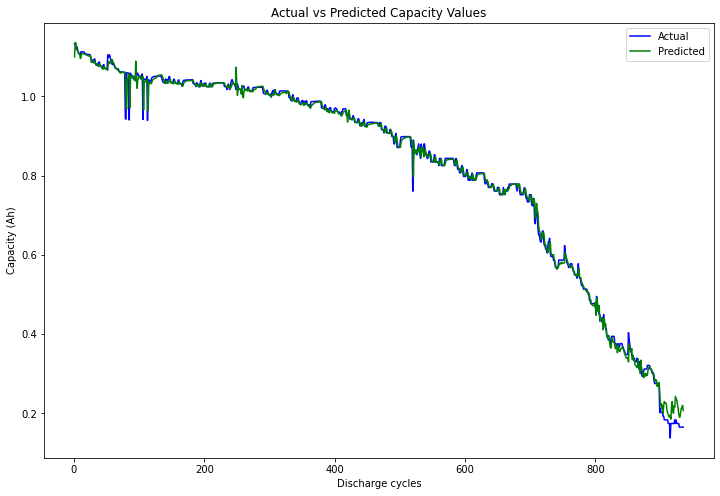

In [ ]:
# Whole python code for inference
# Import all modules
import numpy as np
import random
import math
import os
import sys
import copy
import shutil
import zipfile
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import pandas as pd
import glob
import linecache
import tracemalloc
%matplotlib inline

from torch import optim
from math import sqrt
from datetime import datetime
from timeit import default_timer as timer
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from pathlib import Path
from collections import Counter

# drop outliers to get indexes
def drop_outlier(array, count, bins):
    index = []
    out_range = np.arange(1, count, bins)
    for i in out_range[:-1]:
        array_lim = array[i : i + bins]
        sigma = np.std(array_lim)
        mean = np.mean(array_lim)
        th_max, th_min = mean + sigma*2, mean - sigma*2
        idx = np.where((array_lim < th_max) & (array_lim > th_min))
        idx = idx[0] + i
        index.extend(list(idx))
    return np.array(index)

def dataprocessing(dir_path, test_name):
    battery = {}
    charge_profile = {}
    path = glob.glob(dir_path + test_name + '/*.xlsx')
    print('Load Dataset ' + test_name + '/*.xlsx')
    dates = []
    for p in path:
        file_path = p.split("/")[-1].split(".")[0].split("_")[-3:]
        date_str = str(file_path[0] + "/" + file_path[1] + "/" + file_path[2]) 
        date = datetime.strptime(date_str, '%m/%d/%y')
        dates.append(date)
        '''
        df = pd.read_excel(p, sheet_name=1)
        #print('Load ' + str(p) + ' ...')
        dates.append(df['Date_Time'][0])
        '''
    idx = np.argsort(dates)
    path_sorted = np.array(path)[idx]

    count = 0
    discharge_capacities = []
    internal_resistance = []
    dict1 = {}
    volt = []       # list for voltage values
    amp = []        # list for current values
    for p in path_sorted:
        df = pd.read_excel(p, sheet_name=1)
        print('Load ' + str(p) + ' ...')
        cycles = list(set(df['Cycle_Index']))
        for c in cycles:
            df_lim = df[df['Cycle_Index'] == c]

            # Charging Parameters
            df_c = df_lim[(df_lim['Step_Index'] == 2)|(df_lim['Step_Index'] == 4)]
            c_v = np.array(df_c['Voltage(V)'])
            c_c = np.array(df_c['Current(A)'])
            
            volt.append(c_v)
            amp.append(c_c)

            # Discharging Parameters
            df_d = df_lim[df_lim['Step_Index'] == 7]
            d_v = df_d['Voltage(V)']
            d_c = df_d['Current(A)']
            d_t = df_d['Test_Time(s)']
            d_im = df_d['Internal_Resistance(Ohm)']

            if(len(list(d_c)) != 0):
                time_diff = np.diff(list(d_t))
                d_c = np.array(list(d_c))[1:]
                discharge_capacity = time_diff*d_c/3600     # Q = A*h
                discharge_capacity = [np.sum(discharge_capacity[:n]) for n in range(discharge_capacity.shape[0])]
                discharge_capacities.append(-1*discharge_capacity[-1])

                internal_resistance.append(np.mean(np.array(d_im)))
                count += 1
    
    discharge_capacities = np.array(discharge_capacities)
    internal_resistance = np.array(internal_resistance)

    idx = drop_outlier(discharge_capacities, count, 40)
    df_result = pd.DataFrame({'cycle':np.linspace(1,idx.shape[0],idx.shape[0]),
                              'capacity':discharge_capacities[idx],
                              'resistance':internal_resistance[idx]})
    volt = [volt[idx[i]] for i in range(len(idx))]
    amp = [amp[idx[i]] for i in range(len(idx))]
    d1['Voltage'], d1['Current'] = volt, amp
                              
    battery[test_name] = df_result
    charge_profile[test_name] = d1
    return battery, charge_profile

def Normalize_Data(charge_profile, test_name, volt_max, volt_min, current_max, current_min):
    params = ['Voltage', 'Current']

    df = copy.deepcopy(charge_profile)
    # normalize voltage
    for i in range(len(df[test_name][params[0]])):
        for j in range(len(df[test_name][params[0]][i])):
            df[test_name][params[0]][i][j] = (df[test_name][params[0]][i][j] - volt_min) / (volt_max - volt_min)
    # normalize currents
    for i in range(len(df[test_name][params[1]])):
        for j in range(len(df[test_name][params[1]][i])):
            df[test_name][params[1]][i][j] = (df[test_name][params[1]][i][j] - current_min) / (current_max - current_min)

    return df

# Systematic sampling for voltages and currents
def SystematicSampling(df, sample_size):
    random.seed(1)
    population = len(df)
    step = math.ceil(population/sample_size)
    selected_index = np.arange(0, population, step)
    if len(selected_index) < 10:
        len_list = list(range(0, population))
        selected_index = random.sample(len_list, sample_size)
        selected_index.sort()
    samples = []
    for i in range(len(selected_index)):
        selected_sample = df[selected_index[i]]
        samples.append(selected_sample)
    return samples

def ChargeProfileSampling(df, test_name, sample_size):
    parameters = ['Voltage', 'Current']
    sampled_profile = {}
    d1 = {}
    for params in parameters:
        samples = []
        for i in range(len(df[test_name][params])):
            sampled_list = SystematicSampling(df=df[test_name][params][i],
                                              sample_size=sample_size)
            samples.append(sampled_list)
        d1[params] = samples
    sampled_profile[test_name] = d1
    return sampled_profile

def Normalize_CapRes(battery, test_name, cap_max, cap_min, res_max, res_min):
    df = copy.deepcopy(battery)
    params = ['capacity', 'resistance']

    # normalizing capacity    
    for i in range(len(df[test_name][params[0]])):
        df[test_name][params[0]][i] = (df[test_name][params[0]][i] - cap_min) / (cap_max - cap_min)
    # normalizing internal resistance
    for i in range(len(df[test_name][params[1]])):
        df[test_name][params[1]][i] = (df[test_name][params[1]][i] - res_min) / (res_max - res_min)
    
    return df

def concatCPandCap(sampled_profile, normalized, test_name):
    input = {}
    V = sampled_profile[test_name]['Voltage']
    V.pop(-1)
    C = sampled_profile[test_name]['Current']
    C.pop(-1)
    IR = list(normalized[test_name]['resistance'])
    IR.pop(-1)
    Cap = list(normalized[test_name]['capacity'])
    Cap.pop(-1)

    inputs = []
    for i in range(len(V)):
        one_row = [*V[i], *C[i], IR[i], Cap[i]]
        inputs.append(one_row)
    
    input[test_name] = inputs
    
    return input

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.i2h = nn.Linear(input_size, hidden_size, bias=False)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden_state):
        x = self.i2h(x)
        hidden_state = self.h2h(hidden_state)
        hidden_state = F.relu(x + hidden_state)
        out = self.h2o(hidden_state)
        return out, hidden_state

    def init_zero_hidden(self):
        return torch.zeros(1, self.hidden_size)

# Compute for accuracy
def accuracy(y_test, y_pred):
    error = np.abs(y_pred-y_test)/y_test
    acc = np.ones_like(error) - error
    acc = np.sum(acc)/len(y_pred)
    return float(acc)

# Print Inference Time
def print_inference_time(start: float,
                         end: float,
                         device: torch.device = None):
    
    """
    Prints difference between start and end time
    """

    total_time = end - start
    print(f"Inference time on {device}: {total_time:.3f} seconds")

    return total_time

# Print Memory Usage

def memory_stats(snapshot, key_type='lineno'):
    snapshot = snapshot.filter_traces((
        tracemalloc.Filter(False, "<frozen importlib._bootstrap>"),
        tracemalloc.Filter(False, "<unknown>"),
    ))
    usage_stat = snapshot.statistics(key_type)

    total = sum(stat.size for stat in usage_stat)

    print("Allocated memory: %.1f KiB" % (total / 1024))

def test(loaded_model, input, y_battery, test_name):
    loss_fn = nn.HuberLoss()
    loaded_model.eval()
    with torch.inference_mode():
        x_test = torch.tensor(input[test_name], dtype=torch.float32)
        y_test = torch.tensor(y_battery[test_name], dtype=torch.float32).unsqueeze(1)
        X_test = x_test.to(device)
        Y_test = y_test.to(device)
        hidden = loaded_model.init_zero_hidden()
        hidden = hidden.to(device)
        test_out = []
        for i in range(X_test.size()[0]):
            # 1. Forward Pass
            test_output, hidden = loaded_model(X_test[i], hidden)
            test_out.append(test_output)
                
        y_pred = torch.stack(test_out).to(device)
        # 2. Calculate Loss
        test_loss = loss_fn(y_pred.squeeze(-1), Y_test)
    return test_loss, Y_test, y_pred


if __name__ == "__main__":
    # timer
    start_time = timer()
    tracemalloc.start()
    torch.manual_seed(42)
    # put the path where the dataset is stored
    #batt_zippath = 'data/CS2_35.zip'
    batt_zippath = 'data/CS2_36.zip'
    #batt_zippath = 'data/CS2_37.zip'
    #batt_zippath = Path("data/CS2_38.zip")
    
    # create inference directory
    inference_dir = Path("inference/calce")
    inference_dir.mkdir(parents=True, exist_ok=True)
    
    with zipfile.ZipFile(batt_zippath, "r") as zip_ref:
        zip_ref.extractall(inference_dir)
    
    #test_name = 'CS2_35'
    test_name = 'CS2_36'
    #test_name = 'CS2_37'
    #test_name = 'CS2_38'
    dir_path = '/content/inference/calce/'
    #model_save_path = 'models/RNNModelvB35.pth'
    model_save_path = 'models/RNNModelvB36.pth'
    #model_save_path = 'models/RNNModelvB37.pth'
    #model_save_path = 'models/RNNModelvB38.pth'

    # hyperparameters
    volt_max = 4.2155985832214355
    volt_min = 3.419985055923462
    current_max = 1.1539158821105957
    current_min = -0.6620013117790222
    cap_max = 1.1338066110520781
    cap_min = 0.13754795953533758
    res_max = 0.18449176847934723
    res_min = 0.0820472314953804
    sample_size = 10
    input_size = 22
    hidden_size = 10
    output_size = 1

    # reading files
    battery, charge_profile = dataprocessing(dir_path, test_name)

    # normalizing charge_profile
    df = Normalize_Data(charge_profile, test_name, volt_max, volt_min, current_max, current_min)

    # sampling charge_profile
    sampled_profile = ChargeProfileSampling(df, test_name, sample_size)

    # normalize capacity & internal resistance
    normalized_capres = Normalize_CapRes(battery, test_name, cap_max, cap_min, res_max, res_min)

    # join everything together to create a 22 dimension input
    input = concatCPandCap(sampled_profile, normalized_capres, test_name)

    # test outputs
    y_battery = {}
    df_cap = copy.deepcopy(battery[test_name]['capacity'])
    df_cap = list(df_cap)
    df_cap.pop(0)                                 # remove first element
    y_battery[test_name] = df_cap

    # load saved model
    # Instantiate a new instance of our model (this will be instantiated with random weights
    loadedmodelvB38 = RNNModel(input_size=input_size,
                               hidden_size=hidden_size,
                               output_size=output_size)

    # Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
    loadedmodelvB38.load_state_dict(torch.load(f=model_save_path))
    loadedmodelvB38.to(device)

    # get predictions
    test_loss, Y_test, y_pred = test(loaded_model=loadedmodelvB38,
                                     input=input,
                                     y_battery=y_battery,
                                     test_name=test_name)

    acc = accuracy(Y_test.cpu().detach().numpy(), y_pred.squeeze(-1).cpu().detach().numpy())
    mae = mean_absolute_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy())
    mse = sqrt(mean_squared_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy()))
    print(f"Test Loss: {test_loss:.4f} | MAE: {mae:.4f} | MSE: {mse:.4f} | Accuracy: {acc:.2f}")

    end_time = timer()
    snapshot = tracemalloc.take_snapshot()

    print_inference_time(start_time, end_time, device)
    memory_stats(snapshot)

    y_pred = y_pred.cpu().detach().numpy().squeeze()
    fig, ax = plt.subplots(1, figsize=(12, 8))
    color_list = ['b:', 'g--', 'r-.', 'c.']
    y = list(range(1, len(y_pred)+1))
    ax.plot(y, y_battery[test_name], 'b', label='Actual')
    ax.plot(y, y_pred, 'g', label='Predicted')
    ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Actual vs Predicted Capacity Values')
    plt.legend()

### Inference on CALCE CS2_37

Load Dataset CS2_37/*.xlsx
Load /content/inference/calce/CS2_37/CS2_37_8_17_10.xlsx ...
Load /content/inference/calce/CS2_37/CS2_37_8_18_10.xlsx ...
Load /content/inference/calce/CS2_37/CS2_37_8_19_10.xlsx ...
Load /content/inference/calce/CS2_37/CS2_37_8_30_10.xlsx ...
Load /content/inference/calce/CS2_37/CS2_37_9_7_10.xlsx ...
Load /content/inference/calce/CS2_37/CS2_37_9_14_10.xlsx ...
Load /content/inference/calce/CS2_37/CS2_37_9_21_10.xlsx ...
Load /content/inference/calce/CS2_37/CS2_37_9_28_10.xlsx ...
Load /content/inference/calce/CS2_37/CS2_37_10_04_10.xlsx ...
Load /content/inference/calce/CS2_37/CS2_37_10_05_10.xlsx ...
Load /content/inference/calce/CS2_37/CS2_37_10_14_10.xlsx ...
Load /content/inference/calce/CS2_37/CS2_37_10_21_10.xlsx ...
Load /content/inference/calce/CS2_37/CS2_37_10_28_10.xlsx ...
Load /content/inference/calce/CS2_37/CS2_37_11_01_10.xlsx ...
Load /content/inference/calce/CS2_37/CS2_37_11_08_10.xlsx ...
Load /content/inference/calce/CS2_37/CS2_37_11_15_10

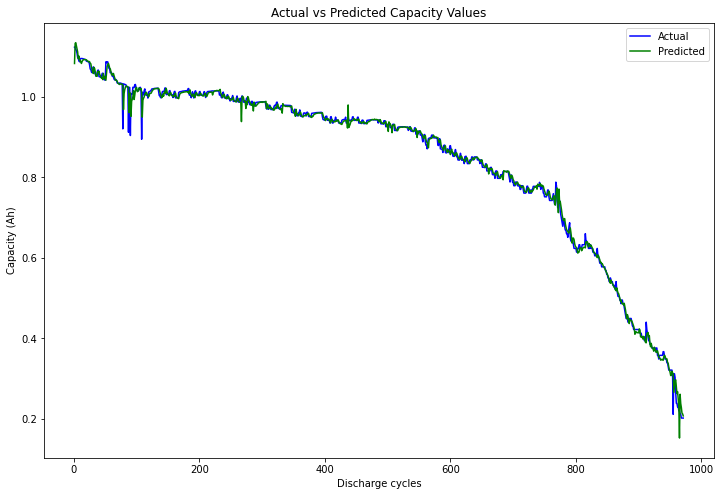

In [ ]:
# Whole python code for inference
# Import all modules
import numpy as np
import random
import math
import os
import sys
import copy
import shutil
import zipfile
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import pandas as pd
import glob
import linecache
import tracemalloc
%matplotlib inline

from torch import optim
from math import sqrt
from datetime import datetime
from timeit import default_timer as timer
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from pathlib import Path
from collections import Counter

# drop outliers to get indexes
def drop_outlier(array, count, bins):
    index = []
    out_range = np.arange(1, count, bins)
    for i in out_range[:-1]:
        array_lim = array[i : i + bins]
        sigma = np.std(array_lim)
        mean = np.mean(array_lim)
        th_max, th_min = mean + sigma*2, mean - sigma*2
        idx = np.where((array_lim < th_max) & (array_lim > th_min))
        idx = idx[0] + i
        index.extend(list(idx))
    return np.array(index)

def dataprocessing(dir_path, test_name):
    battery = {}
    charge_profile = {}
    path = glob.glob(dir_path + test_name + '/*.xlsx')
    print('Load Dataset ' + test_name + '/*.xlsx')
    dates = []
    for p in path:
        file_path = p.split("/")[-1].split(".")[0].split("_")[-3:]
        date_str = str(file_path[0] + "/" + file_path[1] + "/" + file_path[2]) 
        date = datetime.strptime(date_str, '%m/%d/%y')
        dates.append(date)
        '''
        df = pd.read_excel(p, sheet_name=1)
        #print('Load ' + str(p) + ' ...')
        dates.append(df['Date_Time'][0])
        '''
    idx = np.argsort(dates)
    path_sorted = np.array(path)[idx]

    count = 0
    discharge_capacities = []
    internal_resistance = []
    dict1 = {}
    volt = []       # list for voltage values
    amp = []        # list for current values
    for p in path_sorted:
        df = pd.read_excel(p, sheet_name=1)
        print('Load ' + str(p) + ' ...')
        cycles = list(set(df['Cycle_Index']))
        for c in cycles:
            df_lim = df[df['Cycle_Index'] == c]

            # Charging Parameters
            df_c = df_lim[(df_lim['Step_Index'] == 2)|(df_lim['Step_Index'] == 4)]
            c_v = np.array(df_c['Voltage(V)'])
            c_c = np.array(df_c['Current(A)'])
            
            volt.append(c_v)
            amp.append(c_c)

            # Discharging Parameters
            df_d = df_lim[df_lim['Step_Index'] == 7]
            d_v = df_d['Voltage(V)']
            d_c = df_d['Current(A)']
            d_t = df_d['Test_Time(s)']
            d_im = df_d['Internal_Resistance(Ohm)']

            if(len(list(d_c)) != 0):
                time_diff = np.diff(list(d_t))
                d_c = np.array(list(d_c))[1:]
                discharge_capacity = time_diff*d_c/3600     # Q = A*h
                discharge_capacity = [np.sum(discharge_capacity[:n]) for n in range(discharge_capacity.shape[0])]
                discharge_capacities.append(-1*discharge_capacity[-1])

                internal_resistance.append(np.mean(np.array(d_im)))
                count += 1
    
    discharge_capacities = np.array(discharge_capacities)
    internal_resistance = np.array(internal_resistance)

    idx = drop_outlier(discharge_capacities, count, 40)
    df_result = pd.DataFrame({'cycle':np.linspace(1,idx.shape[0],idx.shape[0]),
                              'capacity':discharge_capacities[idx],
                              'resistance':internal_resistance[idx]})
    volt = [volt[idx[i]] for i in range(len(idx))]
    amp = [amp[idx[i]] for i in range(len(idx))]
    d1['Voltage'], d1['Current'] = volt, amp
                              
    battery[test_name] = df_result
    charge_profile[test_name] = d1
    return battery, charge_profile

def Normalize_Data(charge_profile, test_name, volt_max, volt_min, current_max, current_min):
    params = ['Voltage', 'Current']

    df = copy.deepcopy(charge_profile)
    # normalize voltage
    for i in range(len(df[test_name][params[0]])):
        for j in range(len(df[test_name][params[0]][i])):
            df[test_name][params[0]][i][j] = (df[test_name][params[0]][i][j] - volt_min) / (volt_max - volt_min)
    # normalize currents
    for i in range(len(df[test_name][params[1]])):
        for j in range(len(df[test_name][params[1]][i])):
            df[test_name][params[1]][i][j] = (df[test_name][params[1]][i][j] - current_min) / (current_max - current_min)

    return df

# Systematic sampling for voltages and currents
def SystematicSampling(df, sample_size):
    random.seed(1)
    population = len(df)
    step = math.ceil(population/sample_size)
    selected_index = np.arange(0, population, step)
    if len(selected_index) < 10:
        len_list = list(range(0, population))
        selected_index = random.sample(len_list, sample_size)
        selected_index.sort()
    samples = []
    for i in range(len(selected_index)):
        selected_sample = df[selected_index[i]]
        samples.append(selected_sample)
    return samples

def ChargeProfileSampling(df, test_name, sample_size):
    parameters = ['Voltage', 'Current']
    sampled_profile = {}
    d1 = {}
    for params in parameters:
        samples = []
        for i in range(len(df[test_name][params])):
            sampled_list = SystematicSampling(df=df[test_name][params][i],
                                              sample_size=sample_size)
            samples.append(sampled_list)
        d1[params] = samples
    sampled_profile[test_name] = d1
    return sampled_profile

def Normalize_CapRes(battery, test_name, cap_max, cap_min, res_max, res_min):
    df = copy.deepcopy(battery)
    params = ['capacity', 'resistance']

    # normalizing capacity    
    for i in range(len(df[test_name][params[0]])):
        df[test_name][params[0]][i] = (df[test_name][params[0]][i] - cap_min) / (cap_max - cap_min)
    # normalizing internal resistance
    for i in range(len(df[test_name][params[1]])):
        df[test_name][params[1]][i] = (df[test_name][params[1]][i] - res_min) / (res_max - res_min)
    
    return df

def concatCPandCap(sampled_profile, normalized, test_name):
    input = {}
    V = sampled_profile[test_name]['Voltage']
    V.pop(-1)
    C = sampled_profile[test_name]['Current']
    C.pop(-1)
    IR = list(normalized[test_name]['resistance'])
    IR.pop(-1)
    Cap = list(normalized[test_name]['capacity'])
    Cap.pop(-1)

    inputs = []
    for i in range(len(V)):
        one_row = [*V[i], *C[i], IR[i], Cap[i]]
        inputs.append(one_row)
    
    input[test_name] = inputs
    
    return input

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.i2h = nn.Linear(input_size, hidden_size, bias=False)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden_state):
        x = self.i2h(x)
        hidden_state = self.h2h(hidden_state)
        hidden_state = F.relu(x + hidden_state)
        out = self.h2o(hidden_state)
        return out, hidden_state

    def init_zero_hidden(self):
        return torch.zeros(1, self.hidden_size)

# Compute for accuracy
def accuracy(y_test, y_pred):
    error = np.abs(y_pred-y_test)/y_test
    acc = np.ones_like(error) - error
    acc = np.sum(acc)/len(y_pred)
    return float(acc)

# Print Inference Time
def print_inference_time(start: float,
                         end: float,
                         device: torch.device = None):
    
    """
    Prints difference between start and end time
    """

    total_time = end - start
    print(f"Inference time on {device}: {total_time:.3f} seconds")

    return total_time

# Print Memory Usage

def memory_stats(snapshot, key_type='lineno'):
    snapshot = snapshot.filter_traces((
        tracemalloc.Filter(False, "<frozen importlib._bootstrap>"),
        tracemalloc.Filter(False, "<unknown>"),
    ))
    usage_stat = snapshot.statistics(key_type)

    total = sum(stat.size for stat in usage_stat)

    print("Allocated memory: %.1f KiB" % (total / 1024))

def test(loaded_model, input, y_battery, test_name):
    loss_fn = nn.HuberLoss()
    loaded_model.eval()
    with torch.inference_mode():
        x_test = torch.tensor(input[test_name], dtype=torch.float32)
        y_test = torch.tensor(y_battery[test_name], dtype=torch.float32).unsqueeze(1)
        X_test = x_test.to(device)
        Y_test = y_test.to(device)
        hidden = loaded_model.init_zero_hidden()
        hidden = hidden.to(device)
        test_out = []
        for i in range(X_test.size()[0]):
            # 1. Forward Pass
            test_output, hidden = loaded_model(X_test[i], hidden)
            test_out.append(test_output)
                
        y_pred = torch.stack(test_out).to(device)
        # 2. Calculate Loss
        test_loss = loss_fn(y_pred.squeeze(-1), Y_test)
    return test_loss, Y_test, y_pred


if __name__ == "__main__":
    # timer
    start_time = timer()
    tracemalloc.start()
    torch.manual_seed(42)
    # put the path where the dataset is stored
    #batt_zippath = 'data/CS2_35.zip'
    #batt_zippath = 'data/CS2_36.zip'
    batt_zippath = 'data/CS2_37.zip'
    #batt_zippath = Path("data/CS2_38.zip")
    
    # create inference directory
    inference_dir = Path("inference/calce")
    inference_dir.mkdir(parents=True, exist_ok=True)
    
    with zipfile.ZipFile(batt_zippath, "r") as zip_ref:
        zip_ref.extractall(inference_dir)
    
    #test_name = 'CS2_35'
    #test_name = 'CS2_36'
    test_name = 'CS2_37'
    #test_name = 'CS2_38'
    dir_path = '/content/inference/calce/'
    #model_save_path = 'models/RNNModelvB35.pth'
    #model_save_path = 'models/RNNModelvB36.pth'
    model_save_path = 'models/RNNModelvB37.pth'
    #model_save_path = 'models/RNNModelvB38.pth'

    # hyperparameters
    volt_max = 4.2155985832214355
    volt_min = 3.419985055923462
    current_max = 1.1539158821105957
    current_min = -0.6620013117790222
    cap_max = 1.1338066110520781
    cap_min = 0.13754795953533758
    res_max = 0.18449176847934723
    res_min = 0.0820472314953804
    sample_size = 10
    input_size = 22
    hidden_size = 10
    output_size = 1

    # reading files
    battery, charge_profile = dataprocessing(dir_path, test_name)

    # normalizing charge_profile
    df = Normalize_Data(charge_profile, test_name, volt_max, volt_min, current_max, current_min)

    # sampling charge_profile
    sampled_profile = ChargeProfileSampling(df, test_name, sample_size)

    # normalize capacity & internal resistance
    normalized_capres = Normalize_CapRes(battery, test_name, cap_max, cap_min, res_max, res_min)

    # join everything together to create a 22 dimension input
    input = concatCPandCap(sampled_profile, normalized_capres, test_name)

    # test outputs
    y_battery = {}
    df_cap = copy.deepcopy(battery[test_name]['capacity'])
    df_cap = list(df_cap)
    df_cap.pop(0)                                 # remove first element
    y_battery[test_name] = df_cap

    # load saved model
    # Instantiate a new instance of our model (this will be instantiated with random weights
    loadedmodelvB38 = RNNModel(input_size=input_size,
                               hidden_size=hidden_size,
                               output_size=output_size)

    # Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
    loadedmodelvB38.load_state_dict(torch.load(f=model_save_path))
    loadedmodelvB38.to(device)

    # get predictions
    test_loss, Y_test, y_pred = test(loaded_model=loadedmodelvB38,
                                     input=input,
                                     y_battery=y_battery,
                                     test_name=test_name)

    acc = accuracy(Y_test.cpu().detach().numpy(), y_pred.squeeze(-1).cpu().detach().numpy())
    mae = mean_absolute_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy())
    mse = sqrt(mean_squared_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy()))
    print(f"Test Loss: {test_loss:.4f} | MAE: {mae:.4f} | MSE: {mse:.4f} | Accuracy: {acc:.2f}")

    end_time = timer()
    snapshot = tracemalloc.take_snapshot()

    print_inference_time(start_time, end_time, device)
    memory_stats(snapshot)

    y_pred = y_pred.cpu().detach().numpy().squeeze()
    fig, ax = plt.subplots(1, figsize=(12, 8))
    color_list = ['b:', 'g--', 'r-.', 'c.']
    y = list(range(1, len(y_pred)+1))
    ax.plot(y, y_battery[test_name], 'b', label='Actual')
    ax.plot(y, y_pred, 'g', label='Predicted')
    ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Actual vs Predicted Capacity Values')
    plt.legend()

### if the file is already unzipped

In [ ]:
# Whole python code for inference
# Import all modules
import numpy as np
import random
import math
import os
import sys
import copy
import shutil
import zipfile
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import pandas as pd
import glob
import linecache
import tracemalloc
%matplotlib inline

from torch import optim
from math import sqrt
from datetime import datetime
from timeit import default_timer as timer
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from pathlib import Path
from collections import Counter

# drop outliers to get indexes
def drop_outlier(array, count, bins):
    index = []
    out_range = np.arange(1, count, bins)
    for i in out_range[:-1]:
        array_lim = array[i : i + bins]
        sigma = np.std(array_lim)
        mean = np.mean(array_lim)
        th_max, th_min = mean + sigma*2, mean - sigma*2
        idx = np.where((array_lim < th_max) & (array_lim > th_min))
        idx = idx[0] + i
        index.extend(list(idx))
    return np.array(index)

def dataprocessing(dir_path, test_name):
    battery = {}
    charge_profile = {}
    path = glob.glob(dir_path + test_name + '/*.xlsx')
    print('Load Dataset ' + test_name + '/*.xlsx')
    dates = []
    for p in path:
        file_path = p.split("/")[-1].split(".")[0].split("_")[-3:]
        date_str = str(file_path[0] + "/" + file_path[1] + "/" + file_path[2]) 
        date = datetime.strptime(date_str, '%m/%d/%y')
        dates.append(date)
        '''
        df = pd.read_excel(p, sheet_name=1)
        #print('Load ' + str(p) + ' ...')
        dates.append(df['Date_Time'][0])
        '''
    idx = np.argsort(dates)
    path_sorted = np.array(path)[idx]

    count = 0
    discharge_capacities = []
    internal_resistance = []
    dict1 = {}
    volt = []       # list for voltage values
    amp = []        # list for current values
    for p in path_sorted:
        df = pd.read_excel(p, sheet_name=1)
        print('Load ' + str(p) + ' ...')
        cycles = list(set(df['Cycle_Index']))
        for c in cycles:
            df_lim = df[df['Cycle_Index'] == c]

            # Charging Parameters
            df_c = df_lim[(df_lim['Step_Index'] == 2)|(df_lim['Step_Index'] == 4)]
            c_v = np.array(df_c['Voltage(V)'])
            c_c = np.array(df_c['Current(A)'])
            
            volt.append(c_v)
            amp.append(c_c)

            # Discharging Parameters
            df_d = df_lim[df_lim['Step_Index'] == 7]
            d_v = df_d['Voltage(V)']
            d_c = df_d['Current(A)']
            d_t = df_d['Test_Time(s)']
            d_im = df_d['Internal_Resistance(Ohm)']

            if(len(list(d_c)) != 0):
                time_diff = np.diff(list(d_t))
                d_c = np.array(list(d_c))[1:]
                discharge_capacity = time_diff*d_c/3600     # Q = A*h
                discharge_capacity = [np.sum(discharge_capacity[:n]) for n in range(discharge_capacity.shape[0])]
                discharge_capacities.append(-1*discharge_capacity[-1])

                internal_resistance.append(np.mean(np.array(d_im)))
                count += 1
    
    discharge_capacities = np.array(discharge_capacities)
    internal_resistance = np.array(internal_resistance)

    idx = drop_outlier(discharge_capacities, count, 40)
    df_result = pd.DataFrame({'cycle':np.linspace(1,idx.shape[0],idx.shape[0]),
                              'capacity':discharge_capacities[idx],
                              'resistance':internal_resistance[idx]})
    volt = [volt[idx[i]] for i in range(len(idx))]
    amp = [amp[idx[i]] for i in range(len(idx))]
    d1['Voltage'], d1['Current'] = volt, amp
                              
    battery[test_name] = df_result
    charge_profile[test_name] = d1
    return battery, charge_profile

def Normalize_Data(charge_profile, test_name, volt_max, volt_min, current_max, current_min):
    params = ['Voltage', 'Current']

    df = copy.deepcopy(charge_profile)
    # normalize voltage
    for i in range(len(df[test_name][params[0]])):
        for j in range(len(df[test_name][params[0]][i])):
            df[test_name][params[0]][i][j] = (df[test_name][params[0]][i][j] - volt_min) / (volt_max - volt_min)
    # normalize currents
    for i in range(len(df[test_name][params[1]])):
        for j in range(len(df[test_name][params[1]][i])):
            df[test_name][params[1]][i][j] = (df[test_name][params[1]][i][j] - current_min) / (current_max - current_min)

    return df

# Systematic sampling for voltages and currents
def SystematicSampling(df, sample_size):
    random.seed(1)
    population = len(df)
    step = math.ceil(population/sample_size)
    selected_index = np.arange(0, population, step)
    if len(selected_index) < 10:
        len_list = list(range(0, population))
        selected_index = random.sample(len_list, sample_size)
        selected_index.sort()
    samples = []
    for i in range(len(selected_index)):
        selected_sample = df[selected_index[i]]
        samples.append(selected_sample)
    return samples

def ChargeProfileSampling(df, test_name, sample_size):
    parameters = ['Voltage', 'Current']
    sampled_profile = {}
    d1 = {}
    for params in parameters:
        samples = []
        for i in range(len(df[test_name][params])):
            sampled_list = SystematicSampling(df=df[test_name][params][i],
                                              sample_size=sample_size)
            samples.append(sampled_list)
        d1[params] = samples
    sampled_profile[test_name] = d1
    return sampled_profile

def Normalize_CapRes(battery, test_name, cap_max, cap_min, res_max, res_min):
    df = copy.deepcopy(battery)
    params = ['capacity', 'resistance']

    # normalizing capacity    
    for i in range(len(df[test_name][params[0]])):
        df[test_name][params[0]][i] = (df[test_name][params[0]][i] - cap_min) / (cap_max - cap_min)
    # normalizing internal resistance
    for i in range(len(df[test_name][params[1]])):
        df[test_name][params[1]][i] = (df[test_name][params[1]][i] - res_min) / (res_max - res_min)
    
    return df

def concatCPandCap(sampled_profile, normalized, test_name):
    input = {}
    V = sampled_profile[test_name]['Voltage']
    V.pop(-1)
    C = sampled_profile[test_name]['Current']
    C.pop(-1)
    IR = list(normalized[test_name]['resistance'])
    IR.pop(-1)
    Cap = list(normalized[test_name]['capacity'])
    Cap.pop(-1)

    inputs = []
    for i in range(len(V)):
        one_row = [*V[i], *C[i], IR[i], Cap[i]]
        inputs.append(one_row)
    
    input[test_name] = inputs
    
    return input

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.i2h = nn.Linear(input_size, hidden_size, bias=False)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden_state):
        x = self.i2h(x)
        hidden_state = self.h2h(hidden_state)
        hidden_state = F.relu(x + hidden_state)
        out = self.h2o(hidden_state)
        return out, hidden_state

    def init_zero_hidden(self):
        return torch.zeros(1, self.hidden_size)

# Compute for accuracy
def accuracy(y_test, y_pred):
    error = np.abs(y_pred-y_test)/y_test
    acc = np.ones_like(error) - error
    acc = np.sum(acc)/len(y_pred)
    return float(acc)

# Print Inference Time
def print_inference_time(start: float,
                         end: float,
                         device: torch.device = None):
    
    """
    Prints difference between start and end time
    """

    total_time = end - start
    print(f"Inference time on {device}: {total_time:.3f} seconds")

    return total_time

# Print Memory Usage

def memory_stats(snapshot, key_type='lineno'):
    snapshot = snapshot.filter_traces((
        tracemalloc.Filter(False, "<frozen importlib._bootstrap>"),
        tracemalloc.Filter(False, "<unknown>"),
    ))
    usage_stat = snapshot.statistics(key_type)

    total = sum(stat.size for stat in usage_stat)

    print("Allocated memory: %.1f KiB" % (total / 1024))

def test(loaded_model, input, y_battery, test_name):
    loss_fn = nn.HuberLoss()
    loaded_model.eval()
    with torch.inference_mode():
        x_test = torch.tensor(input[test_name], dtype=torch.float32)
        y_test = torch.tensor(y_battery[test_name], dtype=torch.float32).unsqueeze(1)
        X_test = x_test.to(device)
        Y_test = y_test.to(device)
        hidden = loaded_model.init_zero_hidden()
        hidden = hidden.to(device)
        test_out = []
        for i in range(X_test.size()[0]):
            # 1. Forward Pass
            test_output, hidden = loaded_model(X_test[i], hidden)
            test_out.append(test_output)
                
        y_pred = torch.stack(test_out).to(device)
        # 2. Calculate Loss
        test_loss = loss_fn(y_pred.squeeze(-1), Y_test)
    return test_loss, Y_test, y_pred


if __name__ == "__main__":
    # timer
    start_time = timer()
    tracemalloc.start()
    torch.manual_seed(42)
    # put the path where the dataset is stored
    #batt_zippath = 'data/CS2_35.zip'
    #batt_zippath = 'data/CS2_36.zip'
    #batt_zippath = 'data/CS2_37.zip'
    batt_zippath = Path("data/CS2_38.zip")
    
    # create inference directory
    inference_dir = Path("inference/calce")
    inference_dir.mkdir(parents=True, exist_ok=True)
    
    with zipfile.ZipFile(batt_zippath, "r") as zip_ref:
        zip_ref.extractall(inference_dir)
    
    #test_name = 'CS2_35'
    #test_name = 'CS2_36'
    #test_name = 'CS2_37'
    test_name = 'CS2_38'
    dir_path = '/content/inference/calce/'
    #model_save_path = 'models/RNNModelvB35.pth'
    #model_save_path = 'models/RNNModelvB36.pth'
    #model_save_path = 'models/RNNModelvB37.pth'
    model_save_path = 'models/RNNModelvB38.pth'

    # hyperparameters
    volt_max = 4.2155985832214355
    volt_min = 3.419985055923462
    current_max = 1.1539158821105957
    current_min = -0.6620013117790222
    cap_max = 1.1338066110520781
    cap_min = 0.13754795953533758
    res_max = 0.18449176847934723
    res_min = 0.0820472314953804
    sample_size = 10
    input_size = 22
    hidden_size = 10
    output_size = 1

    # reading files
    battery, charge_profile = dataprocessing(dir_path, test_name)

    # normalizing charge_profile
    df = Normalize_Data(charge_profile, test_name, volt_max, volt_min, current_max, current_min)

    # sampling charge_profile
    sampled_profile = ChargeProfileSampling(df, test_name, sample_size)

    # normalize capacity & internal resistance
    normalized_capres = Normalize_CapRes(battery, test_name, cap_max, cap_min, res_max, res_min)

    # join everything together to create a 22 dimension input
    input = concatCPandCap(sampled_profile, normalized_capres, test_name)

    # test outputs
    y_battery = {}
    df_cap = copy.deepcopy(battery[test_name]['capacity'])
    df_cap = list(df_cap)
    df_cap.pop(0)                                 # remove first element
    y_battery[test_name] = df_cap

    # load saved model
    # Instantiate a new instance of our model (this will be instantiated with random weights
    loadedmodelvB38 = RNNModel(input_size=input_size,
                               hidden_size=hidden_size,
                               output_size=output_size)

    # Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
    loadedmodelvB38.load_state_dict(torch.load(f=model_save_path))
    loadedmodelvB38.to(device)

    # get predictions
    test_loss, Y_test, y_pred = test(loaded_model=loadedmodelvB38,
                                     input=input,
                                     y_battery=y_battery,
                                     test_name=test_name)

    acc = accuracy(Y_test.cpu().detach().numpy(), y_pred.squeeze(-1).cpu().detach().numpy())
    mae = mean_absolute_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy())
    mse = sqrt(mean_squared_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy()))
    print(f"Test Loss: {test_loss:.4f} | MAE: {mae:.4f} | MSE: {mse:.4f} | Accuracy: {acc:.2f}")

    end_time = timer()
    snapshot = tracemalloc.take_snapshot()

    print_inference_time(start_time, end_time, device)
    memory_stats(snapshot)

    y_pred = y_pred.cpu().detach().numpy().squeeze()
    fig, ax = plt.subplots(1, figsize=(12, 8))
    color_list = ['b:', 'g--', 'r-.', 'c.']
    y = list(range(1, len(y_pred)+1))
    ax.plot(y, y_battery[test_name], 'b', label='Actual')
    ax.plot(y, y_pred, 'g', label='Predicted')
    ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Actual vs Predicted Capacity Values')
    plt.legend()

## New Inference scripts

### Saving tensors

In [ ]:
# Whole python code for inference
# Import all modules
import numpy as np
import random
import math
import os
import sys
import copy
import shutil
import zipfile
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import pandas as pd
import glob
import linecache
import tracemalloc
%matplotlib inline

from torch import optim
from math import sqrt
from datetime import datetime
from timeit import default_timer as timer
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from pathlib import Path
from collections import Counter

# drop outliers to get indexes
def drop_outlier(array, count, bins):
    index = []
    out_range = np.arange(1, count, bins)
    for i in out_range[:-1]:
        array_lim = array[i : i + bins]
        sigma = np.std(array_lim)
        mean = np.mean(array_lim)
        th_max, th_min = mean + sigma*2, mean - sigma*2
        idx = np.where((array_lim < th_max) & (array_lim > th_min))
        idx = idx[0] + i
        index.extend(list(idx))
    return np.array(index)

def dataprocessing(dir_path, test_name):
    battery = {}
    charge_profile = {}
    path = glob.glob(dir_path + test_name + '/*.xlsx')
    print('Load Dataset ' + test_name + '/*.xlsx')
    dates = []
    for p in path:
        file_path = p.split("/")[-1].split(".")[0].split("_")[-3:]
        date_str = str(file_path[0] + "/" + file_path[1] + "/" + file_path[2]) 
        date = datetime.strptime(date_str, '%m/%d/%y')
        dates.append(date)
        '''
        df = pd.read_excel(p, sheet_name=1)
        #print('Load ' + str(p) + ' ...')
        dates.append(df['Date_Time'][0])
        '''
    idx = np.argsort(dates)
    path_sorted = np.array(path)[idx]

    count = 0
    discharge_capacities = []
    internal_resistance = []
    dict1 = {}
    volt = []       # list for voltage values
    amp = []        # list for current values
    for p in path_sorted:
        df = pd.read_excel(p, sheet_name=1)
        print('Load ' + str(p) + ' ...')
        cycles = list(set(df['Cycle_Index']))
        for c in cycles:
            df_lim = df[df['Cycle_Index'] == c]

            # Charging Parameters
            df_c = df_lim[(df_lim['Step_Index'] == 2)|(df_lim['Step_Index'] == 4)]
            c_v = np.array(df_c['Voltage(V)'])
            c_c = np.array(df_c['Current(A)'])
            
            volt.append(c_v)
            amp.append(c_c)

            # Discharging Parameters
            df_d = df_lim[df_lim['Step_Index'] == 7]
            d_v = df_d['Voltage(V)']
            d_c = df_d['Current(A)']
            d_t = df_d['Test_Time(s)']
            d_im = df_d['Internal_Resistance(Ohm)']

            if(len(list(d_c)) != 0):
                time_diff = np.diff(list(d_t))
                d_c = np.array(list(d_c))[1:]
                discharge_capacity = time_diff*d_c/3600     # Q = A*h
                discharge_capacity = [np.sum(discharge_capacity[:n]) for n in range(discharge_capacity.shape[0])]
                discharge_capacities.append(-1*discharge_capacity[-1])

                internal_resistance.append(np.mean(np.array(d_im)))
                count += 1
    
    discharge_capacities = np.array(discharge_capacities)
    internal_resistance = np.array(internal_resistance)

    idx = drop_outlier(discharge_capacities, count, 40)
    df_result = pd.DataFrame({'cycle':np.linspace(1,idx.shape[0],idx.shape[0]),
                              'capacity':discharge_capacities[idx],
                              'resistance':internal_resistance[idx]})
    volt = [volt[idx[i]] for i in range(len(idx))]
    amp = [amp[idx[i]] for i in range(len(idx))]
    dict1['Voltage'], dict1['Current'] = volt, amp
                              
    battery[test_name] = df_result
    charge_profile[test_name] = dict1
    return battery, charge_profile

def Normalize_Data(charge_profile, test_name, volt_max, volt_min, current_max, current_min):
    params = ['Voltage', 'Current']

    df = copy.deepcopy(charge_profile)
    # normalize voltage
    for i in range(len(df[test_name][params[0]])):
        for j in range(len(df[test_name][params[0]][i])):
            df[test_name][params[0]][i][j] = (df[test_name][params[0]][i][j] - volt_min) / (volt_max - volt_min)
    # normalize currents
    for i in range(len(df[test_name][params[1]])):
        for j in range(len(df[test_name][params[1]][i])):
            df[test_name][params[1]][i][j] = (df[test_name][params[1]][i][j] - current_min) / (current_max - current_min)

    return df

# Systematic sampling for voltages and currents
def SystematicSampling(df, sample_size):
    random.seed(1)
    population = len(df)
    step = math.ceil(population/sample_size)
    selected_index = np.arange(0, population, step)
    if len(selected_index) < 10:
        len_list = list(range(0, population))
        selected_index = random.sample(len_list, sample_size)
        selected_index.sort()
    samples = []
    for i in range(len(selected_index)):
        selected_sample = df[selected_index[i]]
        samples.append(selected_sample)
    return samples

def ChargeProfileSampling(df, test_name, sample_size):
    parameters = ['Voltage', 'Current']
    sampled_profile = {}
    d1 = {}
    for params in parameters:
        samples = []
        for i in range(len(df[test_name][params])):
            sampled_list = SystematicSampling(df=df[test_name][params][i],
                                              sample_size=sample_size)
            samples.append(sampled_list)
        d1[params] = samples
    sampled_profile[test_name] = d1
    return sampled_profile

def Normalize_CapRes(battery, test_name, cap_max, cap_min, res_max, res_min):
    df = copy.deepcopy(battery)
    params = ['capacity', 'resistance']

    # normalizing capacity    
    for i in range(len(df[test_name][params[0]])):
        df[test_name][params[0]][i] = (df[test_name][params[0]][i] - cap_min) / (cap_max - cap_min)
    # normalizing internal resistance
    for i in range(len(df[test_name][params[1]])):
        df[test_name][params[1]][i] = (df[test_name][params[1]][i] - res_min) / (res_max - res_min)
    
    return df

def concatCPandCap(sampled_profile, normalized, test_name):
    input = {}
    V = sampled_profile[test_name]['Voltage']
    V.pop(-1)
    C = sampled_profile[test_name]['Current']
    C.pop(-1)
    IR = list(normalized[test_name]['resistance'])
    IR.pop(-1)
    Cap = list(normalized[test_name]['capacity'])
    Cap.pop(-1)

    inputs = []
    for i in range(len(V)):
        one_row = [*V[i], *C[i], IR[i], Cap[i]]
        inputs.append(one_row)
    
    input[test_name] = inputs
    
    return input

In [ ]:
# Setting up device-agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

#### loop

In [ ]:
batt_zippath = ['data/CS2_35.zip', 'data/CS2_36.zip', 'data/CS2_37.zip', 'data/CS2_38.zip'] 
Battery_names = ['CS2_35', 'CS2_36', 'CS2_37', 'CS2_38']

# hyperparameters
volt_max = 4.2155985832214355
volt_min = 3.419985055923462
current_max = 1.1539158821105957
current_min = -0.6620013117790222
cap_max = 1.1338066110520781
cap_min = 0.13754795953533758
res_max = 0.18449176847934723
res_min = 0.0820472314953804
sample_size = 10

for i in range(0,4):
    # create inference directory
    inference_dir = Path("inference/calce")
    inference_dir.mkdir(parents=True, exist_ok=True)
    
    with zipfile.ZipFile(batt_zippath[i], "r") as zip_ref:
        zip_ref.extractall(inference_dir)

    dir_path = '/content/inference/calce/'
    # reading files
    battery, charge_profile = dataprocessing(dir_path, Battery_names[i])

    # normalizing charge_profile
    df = Normalize_Data(charge_profile, Battery_names[i], volt_max, volt_min, current_max, current_min)

    # sampling charge_profile
    sampled_profile = ChargeProfileSampling(df, Battery_names[i], sample_size)

    # normalize capacity & internal resistance
    normalized_capres = Normalize_CapRes(battery, Battery_names[i], cap_max, cap_min, res_max, res_min)

    # join everything together to create a 22 dimension input
    input = concatCPandCap(sampled_profile, normalized_capres, Battery_names[i])

    # test outputs
    y_battery = {}
    df_cap = copy.deepcopy(battery[Battery_names[i]]['capacity'])
    df_cap = list(df_cap)
    df_cap.pop(0)                                 # remove first element
    y_battery[Battery_names[i]] = df_cap

    x_test = torch.tensor(input[Battery_names[i]], dtype=torch.float32)
    y_test = torch.tensor(y_battery[Battery_names[i]], dtype=torch.float32).unsqueeze(1)
    X_test = x_test.to(device)
    Y_test = y_test.to(device)
    tensor_input = Battery_names[i] + "_input.pt"
    tensor_target = Battery_names[i] + "_target.pt"
    tensor_path = "tensors/" + Battery_names[i] + "/"
    Path(tensor_path).mkdir(parents=True, exist_ok=True)
    torch.save(X_test, tensor_path + tensor_input)
    torch.save(Y_test, tensor_path + tensor_target)


Load Dataset CS2_35/*.xlsx
Load /content/inference/calce/CS2_35/CS2_35_8_17_10.xlsx ...
Load /content/inference/calce/CS2_35/CS2_35_8_18_10.xlsx ...
Load /content/inference/calce/CS2_35/CS2_35_8_19_10.xlsx ...
Load /content/inference/calce/CS2_35/CS2_35_8_30_10.xlsx ...
Load /content/inference/calce/CS2_35/CS2_35_9_7_10.xlsx ...
Load /content/inference/calce/CS2_35/CS2_35_9_8_10.xlsx ...
Load /content/inference/calce/CS2_35/CS2_35_9_21_10.xlsx ...
Load /content/inference/calce/CS2_35/CS2_35_9_30_10.xlsx ...
Load /content/inference/calce/CS2_35/CS2_35_10_15_10.xlsx ...
Load /content/inference/calce/CS2_35/CS2_35_10_22_10.xlsx ...
Load /content/inference/calce/CS2_35/CS2_35_10_29_10.xlsx ...
Load /content/inference/calce/CS2_35/CS2_35_11_01_10.xlsx ...
Load /content/inference/calce/CS2_35/CS2_35_11_08_10.xlsx ...
Load /content/inference/calce/CS2_35/CS2_35_11_23_10.xlsx ...
Load /content/inference/calce/CS2_35/CS2_35_11_24_10.xlsx ...
Load /content/inference/calce/CS2_35/CS2_35_12_06_10.

### Loading tensors & models

In [ ]:
import shutil
import os
from pathlib import Path

Battery_names = ['CS2_35', 'CS2_36', 'CS2_37', 'CS2_38']
# Setup path to date folder
data_path = Path("tensors/")
for name in Battery_names:
    destination_folder = data_path / name

    # If the dataset folder doesn't exist download it and prepare it...
    if destination_folder.is_dir():
        print(f"{destination_folder} directory exists.")
    else:
        print(f"Did not find {destination_folder} directory, creating one...")
        destination_folder.mkdir(parents=True, exist_ok=True)

    # move zip file to data_path
    print("Moving .pt files to directory...")
    source_folder = "drive/MyDrive/RNN_CALCE/tensors/"+name+"/"
    for file_name in os.listdir(source_folder):
        source = source_folder + file_name
        destination = destination_folder / file_name
        # move only files
        if os.path.isfile(source):
            shutil.move(source, destination)
            print('Moved:', file_name)

Did not find tensors/CS2_35 directory, creating one...
Moving .pt files to directory...
Moved: CS2_35_input.pt
Moved: CS2_35_target.pt
Did not find tensors/CS2_36 directory, creating one...
Moving .pt files to directory...
Moved: CS2_36_input.pt
Moved: CS2_36_target.pt
Did not find tensors/CS2_37 directory, creating one...
Moving .pt files to directory...
Moved: CS2_37_input.pt
Moved: CS2_37_target.pt
Did not find tensors/CS2_38 directory, creating one...
Moving .pt files to directory...
Moved: CS2_38_input.pt
Moved: CS2_38_target.pt


In [ ]:
Battery_names = ['CS2_35', 'CS2_36', 'CS2_37', 'CS2_38']
# Setup path to date folder
data_path = Path("models/")
destination_folder = data_path

# If the dataset folder doesn't exist download it and prepare it...
if destination_folder.is_dir():
    print(f"{destination_folder} directory exists.")
else:
    print(f"Did not find {destination_folder} directory, creating one...")
    destination_folder.mkdir(parents=True, exist_ok=True)

# move zip file to data_path
print("Moving .pt files to directory...")
source_folder = "drive/MyDrive/RNN_CALCE/models/"
for file_name in os.listdir(source_folder):
    source = source_folder + file_name
    destination = destination_folder / file_name
    # move only files
    if os.path.isfile(source):
        shutil.move(source, destination)
        print('Moved:', file_name)

Did not find models directory, creating one...
Moving .pt files to directory...
Moved: RNNModelvB37.pth
Moved: RNNModelvB38.pth
Moved: RNNModelvB36.pth
Moved: RNNModelvB35.pth


### CS2_35

In [ ]:
# Whole python code for inference
# Import all modules
import numpy as np
import random
import math
import os
import sys
import copy
import shutil
import zipfile
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import pandas as pd
import glob
import linecache
import tracemalloc
%matplotlib inline

from torch import optim
from math import sqrt
from datetime import datetime
from timeit import default_timer as timer
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from pathlib import Path
from collections import Counter

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.i2h = nn.Linear(input_size, hidden_size, bias=False)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden_state):
        x = self.i2h(x)
        hidden_state = self.h2h(hidden_state)
        hidden_state = F.relu(x + hidden_state)
        out = self.h2o(hidden_state)
        return out, hidden_state

    def init_zero_hidden(self):
        return torch.zeros(1, self.hidden_size)

# Compute for accuracy
def accuracy(y_test, y_pred):
    error = np.abs(y_pred-y_test)/y_test
    acc = np.ones_like(error) - error
    acc = np.sum(acc)/len(y_pred)
    return float(acc)

# Print Inference Time
def print_inference_time(start: float,
                         end: float,
                         device: torch.device = None):
    
    """
    Prints difference between start and end time
    """

    total_time = end - start
    print(f"Inference time on {device}: {total_time:.3f} seconds")

    return total_time

# Print Memory Usage

def memory_stats(snapshot, key_type='lineno'):
    snapshot = snapshot.filter_traces((
        tracemalloc.Filter(False, "<frozen importlib._bootstrap>"),
        tracemalloc.Filter(False, "<unknown>"),
    ))
    usage_stat = snapshot.statistics(key_type)

    total = sum(stat.size for stat in usage_stat)

    print("Allocated memory: %.1f KiB" % (total / 1024))

def test(loaded_model, X_test, Y_test):
    loss_fn = nn.HuberLoss()
    loaded_model.eval()
    with torch.inference_mode():
        hidden = loaded_model.init_zero_hidden()
        hidden = hidden.to(device)
        test_out = []
        for i in range(X_test.size()[0]):
            # 1. Forward Pass
            test_output, hidden = loaded_model(X_test[i], hidden)
            test_out.append(test_output)
                
        y_pred = torch.stack(test_out).to(device)
        # 2. Calculate Loss
        test_loss = loss_fn(y_pred.squeeze(-1), Y_test)
    return test_loss, Y_test, y_pred

if __name__ == "__main__":
    # timer
    start_time = timer()
    tracemalloc.start()
    torch.manual_seed(42)

    # Setting up device-agnostic code
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Rated Capacity
    Rated_Capacity = 1.1

    model_save_path = 'models/RNNModelvB35.pth'
    #model_save_path = 'models/RNNModelvB36.pth'
    #model_save_path = 'models/RNNModelvB37.pth'
    #model_save_path = 'models/RNNModelvB38.pth'

    #test input tensor path
    input_path = "tensors/CS2_35/CS2_35_input.pt"
    #input_path = "tensors/CS2_36/CS2_36_input.pt"
    #input_path = "tensors/CS2_37/CS2_37_input.pt"
    #input_path = "tensors/CS2_38/CS2_38_input.pt"

    #target tensor path
    target_path = "tensors/CS2_35/CS2_35_target.pt"
    #target_path = "tensors/CS2_36/CS2_36_target.pt"
    #target_path = "tensors/CS2_37/CS2_37_target.pt"
    #target_path = "tensors/CS2_38/CS2_38_target.pt"

    X_test = torch.load(input_path)
    Y_test = torch.load(target_path)

    input_size = 22
    hidden_size = 10
    output_size = 1

    # load saved model
    # Instantiate a new instance of our model (this will be instantiated with random weights
    loadedmodel = RNNModel(input_size=input_size,
                           hidden_size=hidden_size,
                           output_size=output_size)

    # Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
    loadedmodel.load_state_dict(torch.load(f=model_save_path,
                                           map_location=torch.device('cpu')))
    loadedmodel.to(device)

    # get predictions
    test_loss, Y_test, y_pred = test(loaded_model=loadedmodel,
                                     X_test=X_test,
                                     Y_test=Y_test)

    acc = accuracy(Y_test.cpu().detach().numpy(), y_pred.squeeze(-1).cpu().detach().numpy())
    mae = mean_absolute_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy())
    mse = sqrt(mean_squared_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy()))

    # Computing RUL Error
    Threshold = 0.7 * Rated_Capacity
    idx_true = (Y_test<Threshold).nonzero().squeeze()
    RUL_true = idx_true[0][0]

    if(torch.Tensor(Y_test[int(RUL_true + 1)])>Threshold):
        RUL_true = idx_true[1][0]

    idx_pred = (y_pred<Threshold).nonzero().squeeze()  # search idx less than threshold
    RUL_pred = idx_pred[0][0]                        # first entry is pred RUL
    if(torch.Tensor(Y_test[int(RUL_pred + 1)])>Threshold):
        RUL_pred = idx_pred[1][0]
    RUL_error = RUL_true - RUL_pred
    # if positive value, earlier than true RUL; 
    # negative value, later than true RUL    
    print(f"Test Loss: {test_loss:.4f} | MAE: {mae:.4f} | MSE: {mse:.4f} | Accuracy: {acc:.2f}")
    print(f"True RUL: {int(RUL_true)} | Prediction RUL: {int(RUL_pred)} | RUL Error: {int(RUL_error)}")

    end_time = timer()
    snapshot = tracemalloc.take_snapshot()

    print_inference_time(start_time, end_time, device)
    memory_stats(snapshot)
    
    y_pred = y_pred.cpu().detach().numpy().squeeze()
    Y_test = Y_test.cpu().detach().numpy()
    fig, ax = plt.subplots(1, figsize=(12, 8))
    y = list(range(1, len(y_pred)+1))
    ax.plot(y, Y_test, 'b', label='Actual')
    ax.plot(y, y_pred, 'g', label='Predicted')
    ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Actual vs Predicted Capacity Values for CS2_35')
    plt.legend()

Test Loss: 0.0001 | MAE: 0.0075 | MSE: 0.0155 | Accuracy: 0.99
True RUL: 639 | Prediction RUL: 641 | RUL Error: -2
Inference time on cpu: 0.187 seconds
Allocated memory: 3357.2 KiB


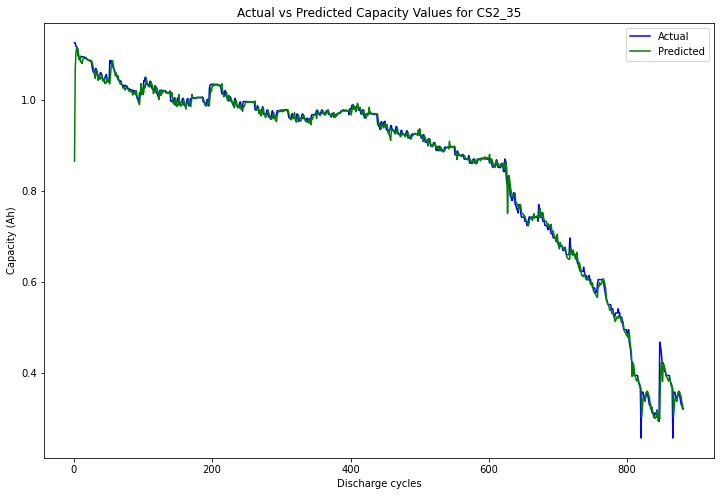

In [ ]:
# Whole python code for inference
# Import all modules
import numpy as np
import random
import math
import os
import sys
import copy
import shutil
import zipfile
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import pandas as pd
import glob
import linecache
import tracemalloc
%matplotlib inline

from torch import optim
from math import sqrt
from datetime import datetime
from timeit import default_timer as timer
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from pathlib import Path
from collections import Counter

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.i2h = nn.Linear(input_size, hidden_size, bias=False)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden_state):
        x = self.i2h(x)
        hidden_state = self.h2h(hidden_state)
        hidden_state = F.relu(x + hidden_state)
        out = self.h2o(hidden_state)
        return out, hidden_state

    def init_zero_hidden(self):
        return torch.zeros(1, self.hidden_size)

# Compute for accuracy
def accuracy(y_test, y_pred):
    error = np.abs(y_pred-y_test)/y_test
    acc = np.ones_like(error) - error
    acc = np.sum(acc)/len(y_pred)
    return float(acc)

# Print Inference Time
def print_inference_time(start: float,
                         end: float,
                         device: torch.device = None):
    
    """
    Prints difference between start and end time
    """

    total_time = end - start
    print(f"Inference time on {device}: {total_time:.3f} seconds")

    return total_time

# Print Memory Usage

def memory_stats(snapshot, key_type='lineno'):
    snapshot = snapshot.filter_traces((
        tracemalloc.Filter(False, "<frozen importlib._bootstrap>"),
        tracemalloc.Filter(False, "<unknown>"),
    ))
    usage_stat = snapshot.statistics(key_type)

    total = sum(stat.size for stat in usage_stat)

    print("Allocated memory: %.1f KiB" % (total / 1024))

def test(loaded_model, X_test, Y_test):
    loss_fn = nn.HuberLoss()
    loaded_model.eval()
    with torch.inference_mode():
        hidden = loaded_model.init_zero_hidden()
        hidden = hidden.to(device)
        test_out = []
        for i in range(X_test.size()[0]):
            # 1. Forward Pass
            test_output, hidden = loaded_model(X_test[i], hidden)
            test_out.append(test_output)
                
        y_pred = torch.stack(test_out).to(device)
        # 2. Calculate Loss
        test_loss = loss_fn(y_pred.squeeze(-1), Y_test)
    return test_loss, Y_test, y_pred

if __name__ == "__main__":
    # timer
    start_time = timer()
    tracemalloc.start()
    torch.manual_seed(42)

    # Setting up device-agnostic code
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Rated Capacity
    Rated_Capacity = 1.1

    model_save_path = 'models/RNNModelvB35.pth'
    #model_save_path = 'models/RNNModelvB36.pth'
    #model_save_path = 'models/RNNModelvB37.pth'
    #model_save_path = 'models/RNNModelvB38.pth'

    #test input tensor path
    input_path = "tensors/CS2_35/CS2_35_input.pt"
    #input_path = "tensors/CS2_36/CS2_36_input.pt"
    #input_path = "tensors/CS2_37/CS2_37_input.pt"
    #input_path = "tensors/CS2_38/CS2_38_input.pt"

    #target tensor path
    target_path = "tensors/CS2_35/CS2_35_target.pt"
    #target_path = "tensors/CS2_36/CS2_36_target.pt"
    #target_path = "tensors/CS2_37/CS2_37_target.pt"
    #target_path = "tensors/CS2_38/CS2_38_target.pt"

    X_test = torch.load(input_path)
    Y_test = torch.load(target_path)

    input_size = 22
    hidden_size = 10
    output_size = 1

    # load saved model
    # Instantiate a new instance of our model (this will be instantiated with random weights
    loadedmodel = RNNModel(input_size=input_size,
                           hidden_size=hidden_size,
                           output_size=output_size)

    # Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
    loadedmodel.load_state_dict(torch.load(f=model_save_path,
                                           map_location=torch.device('cpu')))
    loadedmodel.to(device)

    # get predictions
    test_loss, Y_test, y_pred = test(loaded_model=loadedmodel,
                                     X_test=X_test,
                                     Y_test=Y_test)

    acc = accuracy(Y_test.cpu().detach().numpy(), y_pred.squeeze(-1).cpu().detach().numpy())
    mae = mean_absolute_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy())
    mse = sqrt(mean_squared_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy()))

    # Computing RUL Error
    Threshold = 0.7 * Rated_Capacity
    idx_true = (Y_test<Threshold).nonzero().squeeze()
    RUL_true = idx_true[0][0]

    if(torch.Tensor(Y_test[int(RUL_true + 1)])>Threshold):
        RUL_true = idx_true[1][0]

    idx_pred = (y_pred<Threshold).nonzero().squeeze()  # search idx less than threshold
    RUL_pred = idx_pred[0][0]                        # first entry is pred RUL
    if(torch.Tensor(Y_test[int(RUL_pred + 1)])>Threshold):
        RUL_pred = idx_pred[1][0]
    RUL_error = RUL_true - RUL_pred
    # if positive value, earlier than true RUL; 
    # negative value, later than true RUL    
    print(f"Test Loss: {test_loss:.4f} | MAE: {mae:.4f} | MSE: {mse:.4f} | Accuracy: {acc:.2f}")
    print(f"True RUL: {int(RUL_true)} | Prediction RUL: {int(RUL_pred)} | RUL Error: {int(RUL_error)}")

    end_time = timer()
    snapshot = tracemalloc.take_snapshot()

    print_inference_time(start_time, end_time, device)
    memory_stats(snapshot)
    
    y_pred = y_pred.cpu().detach().numpy().squeeze()
    Y_test = Y_test.cpu().detach().numpy()
    fig, ax = plt.subplots(1, figsize=(12, 8))
    y = list(range(1, len(y_pred)+1))
    ax.plot(y, Y_test, 'b', label='Actual')
    ax.plot(y, y_pred, 'g', label='Predicted')
    ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Actual vs Predicted Capacity Values for CS2_35')
    plt.legend()

###CS2_36

Test Loss: 0.0001 | MAE: 0.0086 | MSE: 0.0159 | Accuracy: 0.98
True RUL: 644 | Prediction RUL: 645 | RUL Error: -1
Inference time on cpu: 0.105 seconds
Allocated memory: 1634.8 KiB


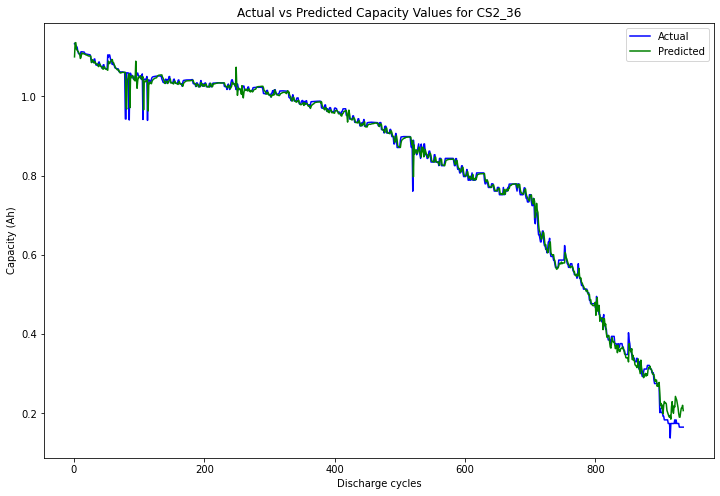

In [ ]:
# Whole python code for inference
# Import all modules
import numpy as np
import random
import math
import os
import sys
import copy
import shutil
import zipfile
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import pandas as pd
import glob
import linecache
import tracemalloc
%matplotlib inline

from torch import optim
from math import sqrt
from datetime import datetime
from timeit import default_timer as timer
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from pathlib import Path
from collections import Counter

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.i2h = nn.Linear(input_size, hidden_size, bias=False)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden_state):
        x = self.i2h(x)
        hidden_state = self.h2h(hidden_state)
        hidden_state = F.relu(x + hidden_state)
        out = self.h2o(hidden_state)
        return out, hidden_state

    def init_zero_hidden(self):
        return torch.zeros(1, self.hidden_size)

# Compute for accuracy
def accuracy(y_test, y_pred):
    error = np.abs(y_pred-y_test)/y_test
    acc = np.ones_like(error) - error
    acc = np.sum(acc)/len(y_pred)
    return float(acc)

# Print Inference Time
def print_inference_time(start: float,
                         end: float,
                         device: torch.device = None):
    
    """
    Prints difference between start and end time
    """

    total_time = end - start
    print(f"Inference time on {device}: {total_time:.3f} seconds")

    return total_time

# Print Memory Usage

def memory_stats(snapshot, key_type='lineno'):
    snapshot = snapshot.filter_traces((
        tracemalloc.Filter(False, "<frozen importlib._bootstrap>"),
        tracemalloc.Filter(False, "<unknown>"),
    ))
    usage_stat = snapshot.statistics(key_type)

    total = sum(stat.size for stat in usage_stat)

    print("Allocated memory: %.1f KiB" % (total / 1024))

def test(loaded_model, X_test, Y_test):
    loss_fn = nn.HuberLoss()
    loaded_model.eval()
    with torch.inference_mode():
        hidden = loaded_model.init_zero_hidden()
        hidden = hidden.to(device)
        test_out = []
        for i in range(X_test.size()[0]):
            # 1. Forward Pass
            test_output, hidden = loaded_model(X_test[i], hidden)
            test_out.append(test_output)
                
        y_pred = torch.stack(test_out).to(device)
        # 2. Calculate Loss
        test_loss = loss_fn(y_pred.squeeze(-1), Y_test)
    return test_loss, Y_test, y_pred

if __name__ == "__main__":
    # timer
    start_time = timer()
    tracemalloc.start()
    torch.manual_seed(42)

    # Setting up device-agnostic code
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Rated Capacity
    Rated_Capacity = 1.1

    #model_save_path = 'models/RNNModelvB35.pth'
    model_save_path = 'models/RNNModelvB36.pth'
    #model_save_path = 'models/RNNModelvB37.pth'
    #model_save_path = 'models/RNNModelvB38.pth'

    #test input tensor path
    #input_path = "tensors/CS2_35/CS2_35_input.pt"
    input_path = "tensors/CS2_36/CS2_36_input.pt"
    #input_path = "tensors/CS2_37/CS2_37_input.pt"
    #input_path = "tensors/CS2_38/CS2_38_input.pt"

    #target tensor path
    #target_path = "tensors/CS2_35/CS2_35_target.pt"
    target_path = "tensors/CS2_36/CS2_36_target.pt"
    #target_path = "tensors/CS2_37/CS2_37_target.pt"
    #target_path = "tensors/CS2_38/CS2_38_target.pt"

    X_test = torch.load(input_path)
    Y_test = torch.load(target_path)

    input_size = 22
    hidden_size = 10
    output_size = 1

    # load saved model
    # Instantiate a new instance of our model (this will be instantiated with random weights
    loadedmodel = RNNModel(input_size=input_size,
                           hidden_size=hidden_size,
                           output_size=output_size)

    # Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
    loadedmodel.load_state_dict(torch.load(f=model_save_path,
                                           map_location=torch.device('cpu')))
    loadedmodel.to(device)

    # get predictions
    test_loss, Y_test, y_pred = test(loaded_model=loadedmodel,
                                     X_test=X_test,
                                     Y_test=Y_test)

    acc = accuracy(Y_test.cpu().detach().numpy(), y_pred.squeeze(-1).cpu().detach().numpy())
    mae = mean_absolute_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy())
    mse = sqrt(mean_squared_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy()))

    # Computing RUL Error
    Threshold = 0.7 * Rated_Capacity
    idx_true = (Y_test<Threshold).nonzero().squeeze()
    RUL_true = idx_true[0][0]

    if(torch.Tensor(Y_test[int(RUL_true + 1)])>Threshold):
        RUL_true = idx_true[1][0]

    idx_pred = (y_pred<Threshold).nonzero().squeeze()  # search idx less than threshold
    RUL_pred = idx_pred[0][0]                        # first entry is pred RUL
    if(torch.Tensor(Y_test[int(RUL_pred + 1)])>Threshold):
        RUL_pred = idx_pred[1][0]
    RUL_error = RUL_true - RUL_pred
    # if positive value, earlier than true RUL; 
    # negative value, later than true RUL    
    print(f"Test Loss: {test_loss:.4f} | MAE: {mae:.4f} | MSE: {mse:.4f} | Accuracy: {acc:.2f}")
    print(f"True RUL: {int(RUL_true)} | Prediction RUL: {int(RUL_pred)} | RUL Error: {int(RUL_error)}")

    end_time = timer()
    snapshot = tracemalloc.take_snapshot()

    print_inference_time(start_time, end_time, device)
    memory_stats(snapshot)
    
    y_pred = y_pred.cpu().detach().numpy().squeeze()
    Y_test = Y_test.cpu().detach().numpy()
    fig, ax = plt.subplots(1, figsize=(12, 8))
    y = list(range(1, len(y_pred)+1))
    ax.plot(y, Y_test, 'b', label='Actual')
    ax.plot(y, y_pred, 'g', label='Predicted')
    ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Actual vs Predicted Capacity Values for CS2_36')
    plt.legend()

Test Loss: 0.0004 | MAE: 0.0133 | MSE: 0.0288 | Accuracy: 0.96
True RUL: 644 | Prediction RUL: 646 | RUL Error: -2
Inference time on cpu: 0.111 seconds
Allocated memory: 4770.3 KiB


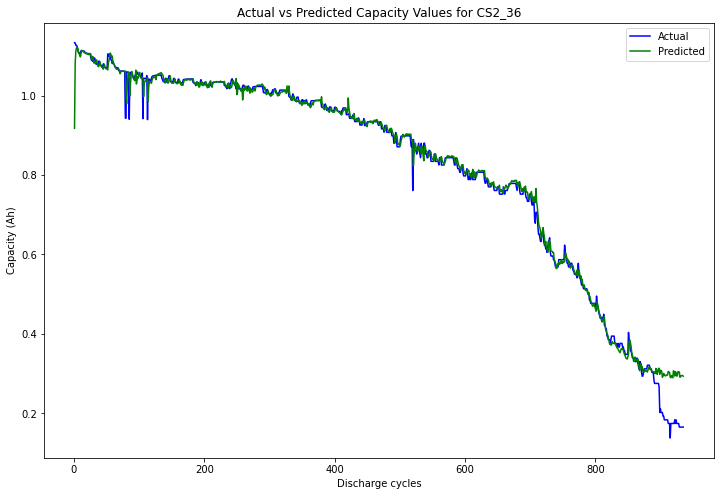

In [ ]:
# Whole python code for inference
# Import all modules
import numpy as np
import random
import math
import os
import sys
import copy
import shutil
import zipfile
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import pandas as pd
import glob
import linecache
import tracemalloc
%matplotlib inline

from torch import optim
from math import sqrt
from datetime import datetime
from timeit import default_timer as timer
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from pathlib import Path
from collections import Counter

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.i2h = nn.Linear(input_size, hidden_size, bias=False)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden_state):
        x = self.i2h(x)
        hidden_state = self.h2h(hidden_state)
        hidden_state = F.relu(x + hidden_state)
        out = self.h2o(hidden_state)
        return out, hidden_state

    def init_zero_hidden(self):
        return torch.zeros(1, self.hidden_size)

# Compute for accuracy
def accuracy(y_test, y_pred):
    error = np.abs(y_pred-y_test)/y_test
    acc = np.ones_like(error) - error
    acc = np.sum(acc)/len(y_pred)
    return float(acc)

# Print Inference Time
def print_inference_time(start: float,
                         end: float,
                         device: torch.device = None):
    
    """
    Prints difference between start and end time
    """

    total_time = end - start
    print(f"Inference time on {device}: {total_time:.3f} seconds")

    return total_time

# Print Memory Usage

def memory_stats(snapshot, key_type='lineno'):
    snapshot = snapshot.filter_traces((
        tracemalloc.Filter(False, "<frozen importlib._bootstrap>"),
        tracemalloc.Filter(False, "<unknown>"),
    ))
    usage_stat = snapshot.statistics(key_type)

    total = sum(stat.size for stat in usage_stat)

    print("Allocated memory: %.1f KiB" % (total / 1024))

def test(loaded_model, X_test, Y_test):
    loss_fn = nn.HuberLoss()
    loaded_model.eval()
    with torch.inference_mode():
        hidden = loaded_model.init_zero_hidden()
        hidden = hidden.to(device)
        test_out = []
        for i in range(X_test.size()[0]):
            # 1. Forward Pass
            test_output, hidden = loaded_model(X_test[i], hidden)
            test_out.append(test_output)
                
        y_pred = torch.stack(test_out).to(device)
        # 2. Calculate Loss
        test_loss = loss_fn(y_pred.squeeze(-1), Y_test)
    return test_loss, Y_test, y_pred

if __name__ == "__main__":
    # timer
    start_time = timer()
    tracemalloc.start()
    torch.manual_seed(42)

    # Setting up device-agnostic code
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Rated Capacity
    Rated_Capacity = 1.1

    #model_save_path = 'models/RNNModelvB35.pth'
    model_save_path = 'models/RNNModelvB36.pth'
    #model_save_path = 'models/RNNModelvB37.pth'
    #model_save_path = 'models/RNNModelvB38.pth'

    #test input tensor path
    #input_path = "tensors/CS2_35/CS2_35_input.pt"
    input_path = "tensors/CS2_36/CS2_36_input.pt"
    #input_path = "tensors/CS2_37/CS2_37_input.pt"
    #input_path = "tensors/CS2_38/CS2_38_input.pt"

    #target tensor path
    #target_path = "tensors/CS2_35/CS2_35_target.pt"
    target_path = "tensors/CS2_36/CS2_36_target.pt"
    #target_path = "tensors/CS2_37/CS2_37_target.pt"
    #target_path = "tensors/CS2_38/CS2_38_target.pt"

    X_test = torch.load(input_path)
    Y_test = torch.load(target_path)

    input_size = 22
    hidden_size = 10
    output_size = 1

    # load saved model
    # Instantiate a new instance of our model (this will be instantiated with random weights
    loadedmodel = RNNModel(input_size=input_size,
                           hidden_size=hidden_size,
                           output_size=output_size)

    # Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
    loadedmodel.load_state_dict(torch.load(f=model_save_path,
                                           map_location=torch.device('cpu')))
    loadedmodel.to(device)

    # get predictions
    test_loss, Y_test, y_pred = test(loaded_model=loadedmodel,
                                     X_test=X_test,
                                     Y_test=Y_test)

    acc = accuracy(Y_test.cpu().detach().numpy(), y_pred.squeeze(-1).cpu().detach().numpy())
    mae = mean_absolute_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy())
    mse = sqrt(mean_squared_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy()))

    # Computing RUL Error
    Threshold = 0.7 * Rated_Capacity
    idx_true = (Y_test<Threshold).nonzero().squeeze()
    RUL_true = idx_true[0][0]

    if(torch.Tensor(Y_test[int(RUL_true + 1)])>Threshold):
        RUL_true = idx_true[1][0]

    idx_pred = (y_pred<Threshold).nonzero().squeeze()  # search idx less than threshold
    RUL_pred = idx_pred[0][0]                        # first entry is pred RUL
    if(torch.Tensor(Y_test[int(RUL_pred + 1)])>Threshold):
        RUL_pred = idx_pred[1][0]
    RUL_error = RUL_true - RUL_pred
    # if positive value, earlier than true RUL; 
    # negative value, later than true RUL    
    print(f"Test Loss: {test_loss:.4f} | MAE: {mae:.4f} | MSE: {mse:.4f} | Accuracy: {acc:.2f}")
    print(f"True RUL: {int(RUL_true)} | Prediction RUL: {int(RUL_pred)} | RUL Error: {int(RUL_error)}")

    end_time = timer()
    snapshot = tracemalloc.take_snapshot()

    print_inference_time(start_time, end_time, device)
    memory_stats(snapshot)
    
    y_pred = y_pred.cpu().detach().numpy().squeeze()
    Y_test = Y_test.cpu().detach().numpy()
    fig, ax = plt.subplots(1, figsize=(12, 8))
    y = list(range(1, len(y_pred)+1))
    ax.plot(y, Y_test, 'b', label='Actual')
    ax.plot(y, y_pred, 'g', label='Predicted')
    ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Actual vs Predicted Capacity Values for CS2_36')
    plt.legend()

###CS2_37

Test Loss: 0.0001 | MAE: 0.0074 | MSE: 0.0131 | Accuracy: 0.99
True RUL: 715 | Prediction RUL: 717 | RUL Error: -2
Inference time on cpu: 0.120 seconds
Allocated memory: 1798.8 KiB


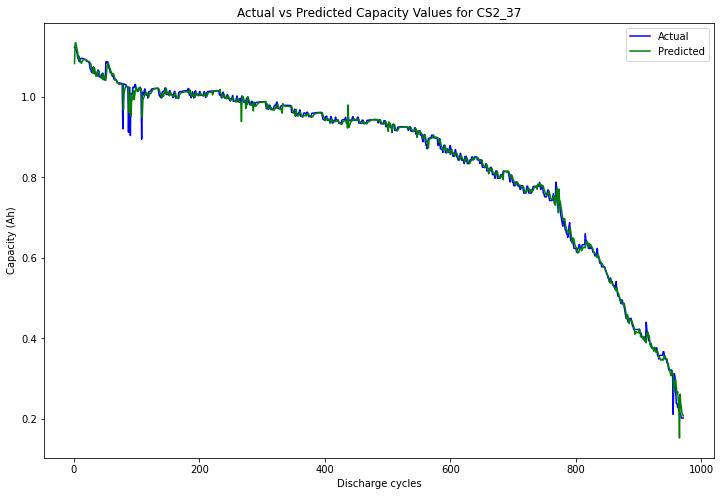

In [ ]:
# Whole python code for inference
# Import all modules
import numpy as np
import random
import math
import os
import sys
import copy
import shutil
import zipfile
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import pandas as pd
import glob
import linecache
import tracemalloc
%matplotlib inline

from torch import optim
from math import sqrt
from datetime import datetime
from timeit import default_timer as timer
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from pathlib import Path
from collections import Counter

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.i2h = nn.Linear(input_size, hidden_size, bias=False)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden_state):
        x = self.i2h(x)
        hidden_state = self.h2h(hidden_state)
        hidden_state = F.relu(x + hidden_state)
        out = self.h2o(hidden_state)
        return out, hidden_state

    def init_zero_hidden(self):
        return torch.zeros(1, self.hidden_size)

# Compute for accuracy
def accuracy(y_test, y_pred):
    error = np.abs(y_pred-y_test)/y_test
    acc = np.ones_like(error) - error
    acc = np.sum(acc)/len(y_pred)
    return float(acc)

# Print Inference Time
def print_inference_time(start: float,
                         end: float,
                         device: torch.device = None):
    
    """
    Prints difference between start and end time
    """

    total_time = end - start
    print(f"Inference time on {device}: {total_time:.3f} seconds")

    return total_time

# Print Memory Usage

def memory_stats(snapshot, key_type='lineno'):
    snapshot = snapshot.filter_traces((
        tracemalloc.Filter(False, "<frozen importlib._bootstrap>"),
        tracemalloc.Filter(False, "<unknown>"),
    ))
    usage_stat = snapshot.statistics(key_type)

    total = sum(stat.size for stat in usage_stat)

    print("Allocated memory: %.1f KiB" % (total / 1024))

def test(loaded_model, X_test, Y_test):
    loss_fn = nn.HuberLoss()
    loaded_model.eval()
    with torch.inference_mode():
        hidden = loaded_model.init_zero_hidden()
        hidden = hidden.to(device)
        test_out = []
        for i in range(X_test.size()[0]):
            # 1. Forward Pass
            test_output, hidden = loaded_model(X_test[i], hidden)
            test_out.append(test_output)
                
        y_pred = torch.stack(test_out).to(device)
        # 2. Calculate Loss
        test_loss = loss_fn(y_pred.squeeze(-1), Y_test)
    return test_loss, Y_test, y_pred

if __name__ == "__main__":
    # timer
    start_time = timer()
    tracemalloc.start()
    torch.manual_seed(42)

    # Setting up device-agnostic code
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Rated Capacity
    Rated_Capacity = 1.1

    #model_save_path = 'models/RNNModelvB35.pth'
    #model_save_path = 'models/RNNModelvB36.pth'
    model_save_path = 'models/RNNModelvB37.pth'
    #model_save_path = 'models/RNNModelvB38.pth'

    #test input tensor path
    #input_path = "tensors/CS2_35/CS2_35_input.pt"
    #input_path = "tensors/CS2_36/CS2_36_input.pt"
    input_path = "tensors/CS2_37/CS2_37_input.pt"
    #input_path = "tensors/CS2_38/CS2_38_input.pt"

    #target tensor path
    #target_path = "tensors/CS2_35/CS2_35_target.pt"
    #target_path = "tensors/CS2_36/CS2_36_target.pt"
    target_path = "tensors/CS2_37/CS2_37_target.pt"
    #target_path = "tensors/CS2_38/CS2_38_target.pt"

    X_test = torch.load(input_path)
    Y_test = torch.load(target_path)

    input_size = 22
    hidden_size = 10
    output_size = 1

    # load saved model
    # Instantiate a new instance of our model (this will be instantiated with random weights
    loadedmodel = RNNModel(input_size=input_size,
                           hidden_size=hidden_size,
                           output_size=output_size)

    # Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
    loadedmodel.load_state_dict(torch.load(f=model_save_path,
                                           map_location=torch.device('cpu')))
    loadedmodel.to(device)

    # get predictions
    test_loss, Y_test, y_pred = test(loaded_model=loadedmodel,
                                     X_test=X_test,
                                     Y_test=Y_test)

    acc = accuracy(Y_test.cpu().detach().numpy(), y_pred.squeeze(-1).cpu().detach().numpy())
    mae = mean_absolute_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy())
    mse = sqrt(mean_squared_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy()))

    # Computing RUL Error
    Threshold = 0.7 * Rated_Capacity
    idx_true = (Y_test<Threshold).nonzero().squeeze()
    RUL_true = idx_true[0][0]

    if(torch.Tensor(Y_test[int(RUL_true + 1)])>Threshold):
        RUL_true = idx_true[1][0]

    idx_pred = (y_pred<Threshold).nonzero().squeeze()  # search idx less than threshold
    RUL_pred = idx_pred[0][0]                        # first entry is pred RUL
    if(torch.Tensor(Y_test[int(RUL_pred + 1)])>Threshold):
        RUL_pred = idx_pred[1][0]
    RUL_error = RUL_true - RUL_pred
    # if positive value, earlier than true RUL; 
    # negative value, later than true RUL    
    print(f"Test Loss: {test_loss:.4f} | MAE: {mae:.4f} | MSE: {mse:.4f} | Accuracy: {acc:.2f}")
    print(f"True RUL: {int(RUL_true)} | Prediction RUL: {int(RUL_pred)} | RUL Error: {int(RUL_error)}")

    end_time = timer()
    snapshot = tracemalloc.take_snapshot()

    print_inference_time(start_time, end_time, device)
    memory_stats(snapshot)
    
    y_pred = y_pred.cpu().detach().numpy().squeeze()
    Y_test = Y_test.cpu().detach().numpy()
    fig, ax = plt.subplots(1, figsize=(12, 8))
    y = list(range(1, len(y_pred)+1))
    ax.plot(y, Y_test, 'b', label='Actual')
    ax.plot(y, y_pred, 'g', label='Predicted')
    ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Actual vs Predicted Capacity Values for CS2_37')
    plt.legend()

Test Loss: 0.0001 | MAE: 0.0086 | MSE: 0.0142 | Accuracy: 0.99
True RUL: 715 | Prediction RUL: 717 | RUL Error: -2
Inference time on cpu: 0.083 seconds
Allocated memory: 4060.6 KiB


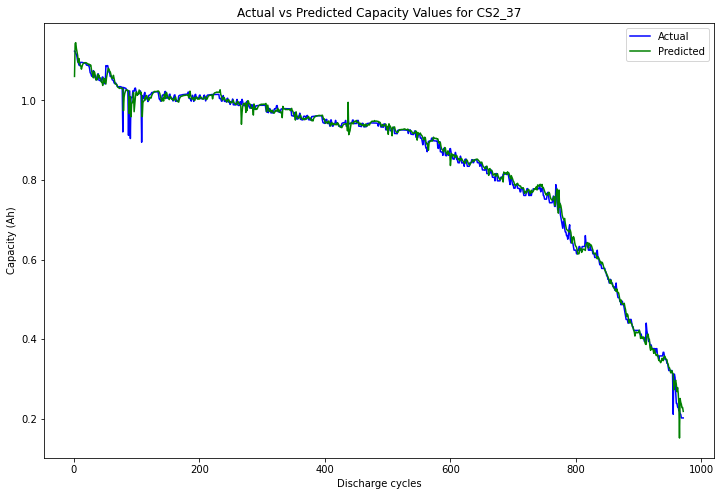

In [ ]:
# Whole python code for inference
# Import all modules
import numpy as np
import random
import math
import os
import sys
import copy
import shutil
import zipfile
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import pandas as pd
import glob
import linecache
import tracemalloc
%matplotlib inline

from torch import optim
from math import sqrt
from datetime import datetime
from timeit import default_timer as timer
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from pathlib import Path
from collections import Counter

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.i2h = nn.Linear(input_size, hidden_size, bias=False)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden_state):
        x = self.i2h(x)
        hidden_state = self.h2h(hidden_state)
        hidden_state = F.relu(x + hidden_state)
        out = self.h2o(hidden_state)
        return out, hidden_state

    def init_zero_hidden(self):
        return torch.zeros(1, self.hidden_size)

# Compute for accuracy
def accuracy(y_test, y_pred):
    error = np.abs(y_pred-y_test)/y_test
    acc = np.ones_like(error) - error
    acc = np.sum(acc)/len(y_pred)
    return float(acc)

# Print Inference Time
def print_inference_time(start: float,
                         end: float,
                         device: torch.device = None):
    
    """
    Prints difference between start and end time
    """

    total_time = end - start
    print(f"Inference time on {device}: {total_time:.3f} seconds")

    return total_time

# Print Memory Usage

def memory_stats(snapshot, key_type='lineno'):
    snapshot = snapshot.filter_traces((
        tracemalloc.Filter(False, "<frozen importlib._bootstrap>"),
        tracemalloc.Filter(False, "<unknown>"),
    ))
    usage_stat = snapshot.statistics(key_type)

    total = sum(stat.size for stat in usage_stat)

    print("Allocated memory: %.1f KiB" % (total / 1024))

def test(loaded_model, X_test, Y_test):
    loss_fn = nn.HuberLoss()
    loaded_model.eval()
    with torch.inference_mode():
        hidden = loaded_model.init_zero_hidden()
        hidden = hidden.to(device)
        test_out = []
        for i in range(X_test.size()[0]):
            # 1. Forward Pass
            test_output, hidden = loaded_model(X_test[i], hidden)
            test_out.append(test_output)
                
        y_pred = torch.stack(test_out).to(device)
        # 2. Calculate Loss
        test_loss = loss_fn(y_pred.squeeze(-1), Y_test)
    return test_loss, Y_test, y_pred

if __name__ == "__main__":
    # timer
    start_time = timer()
    tracemalloc.start()
    torch.manual_seed(42)

    # Setting up device-agnostic code
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Rated Capacity
    Rated_Capacity = 1.1

    #model_save_path = 'models/RNNModelvB35.pth'
    #model_save_path = 'models/RNNModelvB36.pth'
    model_save_path = 'models/RNNModelvB37.pth'
    #model_save_path = 'models/RNNModelvB38.pth'

    #test input tensor path
    #input_path = "tensors/CS2_35/CS2_35_input.pt"
    #input_path = "tensors/CS2_36/CS2_36_input.pt"
    input_path = "tensors/CS2_37/CS2_37_input.pt"
    #input_path = "tensors/CS2_38/CS2_38_input.pt"

    #target tensor path
    #target_path = "tensors/CS2_35/CS2_35_target.pt"
    #target_path = "tensors/CS2_36/CS2_36_target.pt"
    target_path = "tensors/CS2_37/CS2_37_target.pt"
    #target_path = "tensors/CS2_38/CS2_38_target.pt"

    X_test = torch.load(input_path)
    Y_test = torch.load(target_path)

    input_size = 22
    hidden_size = 10
    output_size = 1

    # load saved model
    # Instantiate a new instance of our model (this will be instantiated with random weights
    loadedmodel = RNNModel(input_size=input_size,
                           hidden_size=hidden_size,
                           output_size=output_size)

    # Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
    loadedmodel.load_state_dict(torch.load(f=model_save_path,
                                           map_location=torch.device('cpu')))
    loadedmodel.to(device)

    # get predictions
    test_loss, Y_test, y_pred = test(loaded_model=loadedmodel,
                                     X_test=X_test,
                                     Y_test=Y_test)

    acc = accuracy(Y_test.cpu().detach().numpy(), y_pred.squeeze(-1).cpu().detach().numpy())
    mae = mean_absolute_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy())
    mse = sqrt(mean_squared_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy()))

    # Computing RUL Error
    Threshold = 0.7 * Rated_Capacity
    idx_true = (Y_test<Threshold).nonzero().squeeze()
    RUL_true = idx_true[0][0]

    if(torch.Tensor(Y_test[int(RUL_true + 1)])>Threshold):
        RUL_true = idx_true[1][0]

    idx_pred = (y_pred<Threshold).nonzero().squeeze()  # search idx less than threshold
    RUL_pred = idx_pred[0][0]                        # first entry is pred RUL
    if(torch.Tensor(Y_test[int(RUL_pred + 1)])>Threshold):
        RUL_pred = idx_pred[1][0]
    RUL_error = RUL_true - RUL_pred
    # if positive value, earlier than true RUL; 
    # negative value, later than true RUL    
    print(f"Test Loss: {test_loss:.4f} | MAE: {mae:.4f} | MSE: {mse:.4f} | Accuracy: {acc:.2f}")
    print(f"True RUL: {int(RUL_true)} | Prediction RUL: {int(RUL_pred)} | RUL Error: {int(RUL_error)}")

    end_time = timer()
    snapshot = tracemalloc.take_snapshot()

    print_inference_time(start_time, end_time, device)
    memory_stats(snapshot)
    
    y_pred = y_pred.cpu().detach().numpy().squeeze()
    Y_test = Y_test.cpu().detach().numpy()
    fig, ax = plt.subplots(1, figsize=(12, 8))
    y = list(range(1, len(y_pred)+1))
    ax.plot(y, Y_test, 'b', label='Actual')
    ax.plot(y, y_pred, 'g', label='Predicted')
    ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Actual vs Predicted Capacity Values for CS2_37')
    plt.legend()

###CS2_38

Test Loss: 0.0001 | MAE: 0.0089 | MSE: 0.0158 | Accuracy: 0.99
True RUL: 752 | Prediction RUL: 745 | RUL Error: 7
Inference time on cpu: 0.116 seconds
Allocated memory: 2515.8 KiB


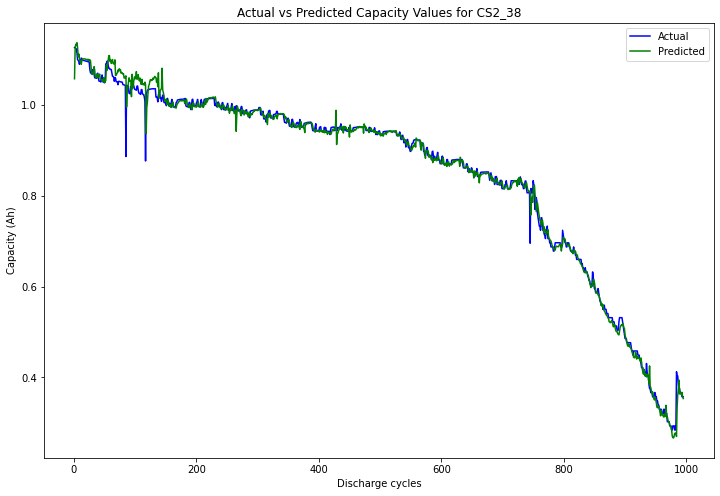

In [ ]:
# Whole python code for inference
# Import all modules
import numpy as np
import random
import math
import os
import sys
import copy
import shutil
import zipfile
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import pandas as pd
import glob
import linecache
import tracemalloc
%matplotlib inline

from torch import optim
from math import sqrt
from datetime import datetime
from timeit import default_timer as timer
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from pathlib import Path
from collections import Counter

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.i2h = nn.Linear(input_size, hidden_size, bias=False)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden_state):
        x = self.i2h(x)
        hidden_state = self.h2h(hidden_state)
        hidden_state = F.relu(x + hidden_state)
        out = self.h2o(hidden_state)
        return out, hidden_state

    def init_zero_hidden(self):
        return torch.zeros(1, self.hidden_size)

# Compute for accuracy
def accuracy(y_test, y_pred):
    error = np.abs(y_pred-y_test)/y_test
    acc = np.ones_like(error) - error
    acc = np.sum(acc)/len(y_pred)
    return float(acc)

# Print Inference Time
def print_inference_time(start: float,
                         end: float,
                         device: torch.device = None):
    
    """
    Prints difference between start and end time
    """

    total_time = end - start
    print(f"Inference time on {device}: {total_time:.3f} seconds")

    return total_time

# Print Memory Usage

def memory_stats(snapshot, key_type='lineno'):
    snapshot = snapshot.filter_traces((
        tracemalloc.Filter(False, "<frozen importlib._bootstrap>"),
        tracemalloc.Filter(False, "<unknown>"),
    ))
    usage_stat = snapshot.statistics(key_type)

    total = sum(stat.size for stat in usage_stat)

    print("Allocated memory: %.1f KiB" % (total / 1024))

def test(loaded_model, X_test, Y_test):
    loss_fn = nn.HuberLoss()
    loaded_model.eval()
    with torch.inference_mode():
        hidden = loaded_model.init_zero_hidden()
        hidden = hidden.to(device)
        test_out = []
        for i in range(X_test.size()[0]):
            # 1. Forward Pass
            test_output, hidden = loaded_model(X_test[i], hidden)
            test_out.append(test_output)
                
        y_pred = torch.stack(test_out).to(device)
        # 2. Calculate Loss
        test_loss = loss_fn(y_pred.squeeze(-1), Y_test)
    return test_loss, Y_test, y_pred

if __name__ == "__main__":
    # timer
    start_time = timer()
    tracemalloc.start()
    torch.manual_seed(42)

    # Setting up device-agnostic code
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Rated Capacity
    Rated_Capacity = 1.1

    #model_save_path = 'models/RNNModelvB35.pth'
    #model_save_path = 'models/RNNModelvB36.pth'
    #model_save_path = 'models/RNNModelvB37.pth'
    model_save_path = 'models/RNNModelvB38.pth'

    #test input tensor path
    #input_path = "tensors/CS2_35/CS2_35_input.pt"
    #input_path = "tensors/CS2_36/CS2_36_input.pt"
    #input_path = "tensors/CS2_37/CS2_37_input.pt"
    input_path = "tensors/CS2_38/CS2_38_input.pt"

    #target tensor path
    #target_path = "tensors/CS2_35/CS2_35_target.pt"
    #target_path = "tensors/CS2_36/CS2_36_target.pt"
    #target_path = "tensors/CS2_37/CS2_37_target.pt"
    target_path = "tensors/CS2_38/CS2_38_target.pt"

    X_test = torch.load(input_path)
    Y_test = torch.load(target_path)

    input_size = 22
    hidden_size = 10
    output_size = 1

    # load saved model
    # Instantiate a new instance of our model (this will be instantiated with random weights
    loadedmodel = RNNModel(input_size=input_size,
                           hidden_size=hidden_size,
                           output_size=output_size)

    # Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
    loadedmodel.load_state_dict(torch.load(f=model_save_path,
                                           map_location=torch.device('cpu')))
    loadedmodel.to(device)

    # get predictions
    test_loss, Y_test, y_pred = test(loaded_model=loadedmodel,
                                     X_test=X_test,
                                     Y_test=Y_test)

    acc = accuracy(Y_test.cpu().detach().numpy(), y_pred.squeeze(-1).cpu().detach().numpy())
    mae = mean_absolute_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy())
    mse = sqrt(mean_squared_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy()))

    # Computing RUL Error
    Threshold = 0.7 * Rated_Capacity
    idx_true = (Y_test<Threshold).nonzero().squeeze()
    RUL_true = idx_true[0][0]

    if(torch.Tensor(Y_test[int(RUL_true + 1)])>Threshold):
        RUL_true = idx_true[1][0]

    idx_pred = (y_pred<Threshold).nonzero().squeeze()  # search idx less than threshold
    RUL_pred = idx_pred[0][0]                        # first entry is pred RUL
    if(torch.Tensor(Y_test[int(RUL_pred + 1)])>Threshold):
        RUL_pred = idx_pred[1][0]
    RUL_error = RUL_true - RUL_pred
    # if positive value, earlier than true RUL; 
    # negative value, later than true RUL    
    print(f"Test Loss: {test_loss:.4f} | MAE: {mae:.4f} | MSE: {mse:.4f} | Accuracy: {acc:.2f}")
    print(f"True RUL: {int(RUL_true)} | Prediction RUL: {int(RUL_pred)} | RUL Error: {int(RUL_error)}")

    end_time = timer()
    snapshot = tracemalloc.take_snapshot()

    print_inference_time(start_time, end_time, device)
    memory_stats(snapshot)
    
    y_pred = y_pred.cpu().detach().numpy().squeeze()
    Y_test = Y_test.cpu().detach().numpy()
    fig, ax = plt.subplots(1, figsize=(12, 8))
    y = list(range(1, len(y_pred)+1))
    ax.plot(y, Y_test, 'b', label='Actual')
    ax.plot(y, y_pred, 'g', label='Predicted')
    ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Actual vs Predicted Capacity Values for CS2_38')
    plt.legend()

Test Loss: 0.0004 | MAE: 0.0163 | MSE: 0.0290 | Accuracy: 0.98
True RUL: 752 | Prediction RUL: 755 | RUL Error: -3
Inference time on cpu: 0.102 seconds
Allocated memory: 3174.0 KiB


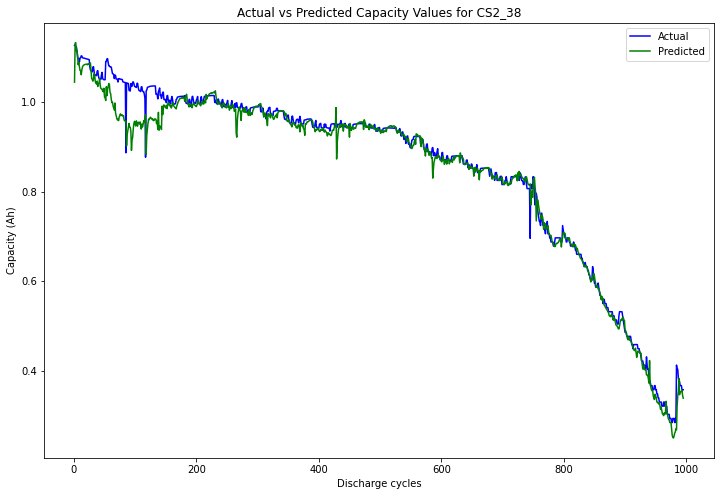

In [ ]:
# Whole python code for inference
# Import all modules
import numpy as np
import random
import math
import os
import sys
import copy
import shutil
import zipfile
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import pandas as pd
import glob
import linecache
import tracemalloc
%matplotlib inline

from torch import optim
from math import sqrt
from datetime import datetime
from timeit import default_timer as timer
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from pathlib import Path
from collections import Counter

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.i2h = nn.Linear(input_size, hidden_size, bias=False)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden_state):
        x = self.i2h(x)
        hidden_state = self.h2h(hidden_state)
        hidden_state = F.relu(x + hidden_state)
        out = self.h2o(hidden_state)
        return out, hidden_state

    def init_zero_hidden(self):
        return torch.zeros(1, self.hidden_size)

# Compute for accuracy
def accuracy(y_test, y_pred):
    error = np.abs(y_pred-y_test)/y_test
    acc = np.ones_like(error) - error
    acc = np.sum(acc)/len(y_pred)
    return float(acc)

# Print Inference Time
def print_inference_time(start: float,
                         end: float,
                         device: torch.device = None):
    
    """
    Prints difference between start and end time
    """

    total_time = end - start
    print(f"Inference time on {device}: {total_time:.3f} seconds")

    return total_time

# Print Memory Usage

def memory_stats(snapshot, key_type='lineno'):
    snapshot = snapshot.filter_traces((
        tracemalloc.Filter(False, "<frozen importlib._bootstrap>"),
        tracemalloc.Filter(False, "<unknown>"),
    ))
    usage_stat = snapshot.statistics(key_type)

    total = sum(stat.size for stat in usage_stat)

    print("Allocated memory: %.1f KiB" % (total / 1024))

def test(loaded_model, X_test, Y_test):
    loss_fn = nn.HuberLoss()
    loaded_model.eval()
    with torch.inference_mode():
        hidden = loaded_model.init_zero_hidden()
        hidden = hidden.to(device)
        test_out = []
        for i in range(X_test.size()[0]):
            # 1. Forward Pass
            test_output, hidden = loaded_model(X_test[i], hidden)
            test_out.append(test_output)
                
        y_pred = torch.stack(test_out).to(device)
        # 2. Calculate Loss
        test_loss = loss_fn(y_pred.squeeze(-1), Y_test)
    return test_loss, Y_test, y_pred

if __name__ == "__main__":
    # timer
    start_time = timer()
    tracemalloc.start()
    torch.manual_seed(42)

    # Setting up device-agnostic code
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Rated Capacity
    Rated_Capacity = 1.1

    #model_save_path = 'models/RNNModelvB35.pth'
    #model_save_path = 'models/RNNModelvB36.pth'
    #model_save_path = 'models/RNNModelvB37.pth'
    model_save_path = 'models/RNNModelvB38.pth'

    #test input tensor path
    #input_path = "tensors/CS2_35/CS2_35_input.pt"
    #input_path = "tensors/CS2_36/CS2_36_input.pt"
    #input_path = "tensors/CS2_37/CS2_37_input.pt"
    input_path = "tensors/CS2_38/CS2_38_input.pt"

    #target tensor path
    #target_path = "tensors/CS2_35/CS2_35_target.pt"
    #target_path = "tensors/CS2_36/CS2_36_target.pt"
    #target_path = "tensors/CS2_37/CS2_37_target.pt"
    target_path = "tensors/CS2_38/CS2_38_target.pt"

    X_test = torch.load(input_path)
    Y_test = torch.load(target_path)

    input_size = 22
    hidden_size = 10
    output_size = 1

    # load saved model
    # Instantiate a new instance of our model (this will be instantiated with random weights
    loadedmodel = RNNModel(input_size=input_size,
                           hidden_size=hidden_size,
                           output_size=output_size)

    # Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
    loadedmodel.load_state_dict(torch.load(f=model_save_path,
                                           map_location=torch.device('cpu')))
    loadedmodel.to(device)

    # get predictions
    test_loss, Y_test, y_pred = test(loaded_model=loadedmodel,
                                     X_test=X_test,
                                     Y_test=Y_test)

    acc = accuracy(Y_test.cpu().detach().numpy(), y_pred.squeeze(-1).cpu().detach().numpy())
    mae = mean_absolute_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy())
    mse = sqrt(mean_squared_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy()))

    # Computing RUL Error
    Threshold = 0.7 * Rated_Capacity
    idx_true = (Y_test<Threshold).nonzero().squeeze()
    RUL_true = idx_true[0][0]

    if(torch.Tensor(Y_test[int(RUL_true + 1)])>Threshold):
        RUL_true = idx_true[1][0]

    idx_pred = (y_pred<Threshold).nonzero().squeeze()  # search idx less than threshold
    RUL_pred = idx_pred[0][0]                        # first entry is pred RUL
    if(torch.Tensor(Y_test[int(RUL_pred + 1)])>Threshold):
        RUL_pred = idx_pred[1][0]
    RUL_error = RUL_true - RUL_pred
    # if positive value, earlier than true RUL; 
    # negative value, later than true RUL    
    print(f"Test Loss: {test_loss:.4f} | MAE: {mae:.4f} | MSE: {mse:.4f} | Accuracy: {acc:.2f}")
    print(f"True RUL: {int(RUL_true)} | Prediction RUL: {int(RUL_pred)} | RUL Error: {int(RUL_error)}")

    end_time = timer()
    snapshot = tracemalloc.take_snapshot()

    print_inference_time(start_time, end_time, device)
    memory_stats(snapshot)
    
    y_pred = y_pred.cpu().detach().numpy().squeeze()
    Y_test = Y_test.cpu().detach().numpy()
    fig, ax = plt.subplots(1, figsize=(12, 8))
    y = list(range(1, len(y_pred)+1))
    ax.plot(y, Y_test, 'b', label='Actual')
    ax.plot(y, y_pred, 'g', label='Predicted')
    ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Actual vs Predicted Capacity Values for CS2_38')
    plt.legend()